In [1]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np

from datetime import datetime;now = datetime.now;t00=now();

import torch
import torch.nn as nn
import torch.optim as optim

import seaborn as sns

In [2]:
from google.colab import drive
drive.mount("/content/drive")
print('done, mounted')
print(now())

Mounted at /content/drive
done, mounted
2020-10-30 18:47:59.075532


In [3]:
#data = np.random.rand(131,160,64,64)
#data = np.load('/content/drive/My Drive/abide_data_60.npy')
data = np.load('/content/drive/My Drive/abide_data_60iso_1060.npy')

for s in range(data.shape[0]):
  data[s,:,:,:] = (data[s,:,:,:]-data[s,:,:,:].min()) / (data[s,:,:,:].max()-data[s,:,:,:].min())
  
print(data.shape)

(1060, 1, 64, 64, 64)


In [4]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


In [5]:
# Autoencoder class
class CAE(nn.Module):
    def __init__(self,input_shape,k=1):
        super().__init__()
        
        # Stuff
        self.input_shape = input_shape
        self.batch_size = input_shape[0]

        self.lrelu = torch.nn.LeakyReLU(negative_slope=.02)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()

        # Shapes and sizes
        #R = np.ones(shape=self.input_shape)
        #R = torch.tensor(R).float()

        bias_bool = False # Do you want padding or not 

        # Encoder
        self.enc_C1 = nn.Conv3d(in_channels=1,out_channels=int(4*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C2 = nn.Conv3d(in_channels=int(4*k),out_channels=int(8*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C3 = nn.Conv3d(in_channels=int(8*k),out_channels=int(16*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C4 = nn.Conv3d(in_channels=int(16*k),out_channels=int(32*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C5 = nn.Conv3d(in_channels=int(32*k),out_channels=int(64*k),kernel_size=5, stride=2, padding=2, bias=bias_bool)

        self.batchNormE1 = nn.BatchNorm3d(int(4*k), affine=False)
        self.batchNormE2 = nn.BatchNorm3d(int(8*k), affine=False)
        self.batchNormE3 = nn.BatchNorm3d(int(16*k), affine=False)
        self.batchNormE4 = nn.BatchNorm3d(int(32*k), affine=False)
        self.batchNormE5 = nn.BatchNorm3d(int(64*k), affine=False)

        self.batchNormD1 = nn.BatchNorm3d(int(32*k), affine=False)
        self.batchNormD2 = nn.BatchNorm3d(int(16*k), affine=False)
        self.batchNormD3 = nn.BatchNorm3d(int(8*k), affine=False)
        self.batchNormD4 = nn.BatchNorm3d(int(4*k), affine=False)
        #self.batchNormD5 = nn.BatchNorm3d(int(4*k), affine=False)

        self.dec_C1 = nn.ConvTranspose3d(in_channels=int(64*k),out_channels=int(32*k),kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C2 = nn.ConvTranspose3d(in_channels=int(32*k),out_channels=int(16*k),kernel_size=4, stride=2, padding=1,bias=bias_bool) 
        self.dec_C3 = nn.ConvTranspose3d(in_channels=int(16*k),out_channels=int(8*k),kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C4 = nn.ConvTranspose3d(in_channels=int(8*k),out_channels=int(4*k),kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C5 = nn.ConvTranspose3d(in_channels=int(4*k),out_channels=1,kernel_size=4, stride=2, padding=1,bias=bias_bool)

    def forward(self,hello):
      
        activation = self.relu( self.enc_C1(hello) )
        activation = self.batchNormE1(activation)

        activation = self.relu( self.enc_C2(activation) )
        activation = self.batchNormE2(activation)

        activation = self.relu( self.enc_C3(activation) )
        activation = self.batchNormE3(activation)

        activation = self.relu( self.enc_C4(activation) )
        activation = self.batchNormE4(activation)

        activation = self.relu( self.enc_C5(activation) )
        activation = self.batchNormE5(activation)

        activation = self.relu( self.dec_C1(activation))
        activation = self.batchNormD1(activation)

        activation = self.relu( self.dec_C2(activation) )
        activation = self.batchNormD2(activation)

        activation = self.relu( self.dec_C3(activation) )
        activation = self.batchNormD3(activation)

        activation = self.relu( self.dec_C4(activation) )
        activation = self.batchNormD4(activation)

        activation = self.relu( self.dec_C5(activation) )
        #activation = self.batchNormD5(activation)

        return activation


In [ ]:
# D = torch.tensor(data[:,:,:,:,:]).float()
# data_batch = D[0:5,:,:,:,:]

# modelPlay = CAE(data_batch.shape,k=.5)
# 



torch.Size([5, 32, 2, 2, 2])
256.0


In [7]:
## Convert data 
D = torch.tensor(data[:,:,:,:,:]).float()
#D = torch.tensor(np.random.rand(1060, 1, 64, 64, 64)*.001).float()
#D = (D-D.min()) / (D.max()-D.min())
data_batch = D[0:5,:,:,:,:]

## Model Definition
model = CAE(data_batch.shape,k=.5) # Initiate mode

latentSpaceSize = model.enc_C5(model.enc_C4(model.enc_C3(model.enc_C2(model.enc_C1(data_batch))))).shape
print(f"latentSpaceSize: {latentSpaceSize}")
latentSpaceDim = np.prod(latentSpaceSize)
print(f"latentSpaceDim: {latentSpaceDim/latentSpaceSize[0]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #  use gpu if available
model.to(device)

# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# create a new model with these weights
model.apply(weights_init_uniform_rule)

#model.to(device)

#optimizer = optim.Adam(model.parameters(), lr=1e-3,)
optimizer = optim.Adam(model.parameters(), lr=.01,weight_decay=.01)
#optimizer = optim.SGD(model.parameters(),lr=.001,weight_decay=.0,momentum=.0)
#optimizer = optim.RMSprop(model.parameters(),lr=.1)
#criterion = nn.MSELoss()
print(device)

## Training Parameters
num_epochs = 501
batch_size = 5
ndata = data.shape[0]
n_batches = np.floor(D.shape[0]/5)
batches = np.array([np.arange((i)*5,(i+1)*5) for i in range(int(n_batches))])
D = D.cuda()
track = list();

ofdir = os.path.join(os.path.curdir,'drive','My Drive','BC-MRI-AE','models')
print(ofdir)

session_name = '5layer-256-batchNorm'

latentSpaceSize: torch.Size([5, 32, 2, 2, 2])
latentSpaceDim: 256.0
cuda
./drive/My Drive/BC-MRI-AE/models


In [9]:
def myLoss(outputs,data_batch):
  return torch.sum(torch.square(outputs.view(-1)-data_batch.view(-1)))

epoch 0/501 | batch 0/212.0 | time 0:00:00.068763 | loss 9354.79883
epoch 0/501 | batch 50/212.0 | time 0:00:01.318737 | loss 8897.05273
epoch 0/501 | batch 100/212.0 | time 0:00:02.429675 | loss 9834.27734
epoch 0/501 | batch 150/212.0 | time 0:00:03.543702 | loss 17295.90625
epoch 0/501 | batch 200/212.0 | time 0:00:04.662558 | loss 7867.65918
saved
./drive/My Drive/BC-MRI-AE/models/5layer-256-batchNorme0_2020-10-30 18:53:18.397344
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0', grad_fn=<ViewBackward>)


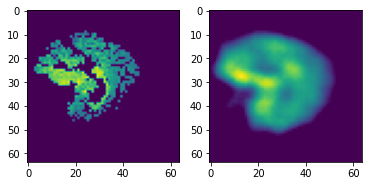

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


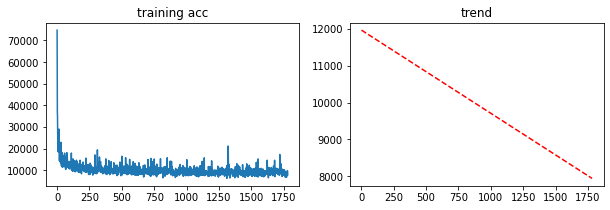

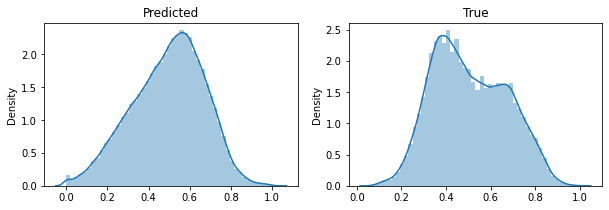

epoch 1/501 | batch 0/212.0 | time 0:00:07.565758 | loss 9114.44629
epoch 1/501 | batch 50/212.0 | time 0:00:08.775469 | loss 7404.93848
epoch 1/501 | batch 100/212.0 | time 0:00:09.886998 | loss 9006.32812
epoch 1/501 | batch 150/212.0 | time 0:00:11.001394 | loss 9296.23242
epoch 1/501 | batch 200/212.0 | time 0:00:12.115429 | loss 9046.51367
epoch 2/501 | batch 0/212.0 | time 0:00:12.395407 | loss 7889.03027
epoch 2/501 | batch 50/212.0 | time 0:00:13.509313 | loss 7844.33789
epoch 2/501 | batch 100/212.0 | time 0:00:14.623931 | loss 7810.11133
epoch 2/501 | batch 150/212.0 | time 0:00:15.739305 | loss 7944.16797
epoch 2/501 | batch 200/212.0 | time 0:00:16.853752 | loss 10447.23145
epoch 3/501 | batch 0/212.0 | time 0:00:17.132341 | loss 7121.35547
epoch 3/501 | batch 50/212.0 | time 0:00:18.243871 | loss 7561.96533
epoch 3/501 | batch 100/212.0 | time 0:00:19.361545 | loss 7068.21484
epoch 3/501 | batch 150/212.0 | time 0:00:20.474293 | loss 7814.60938
epoch 3/501 | batch 200/212.

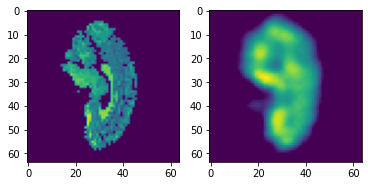

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


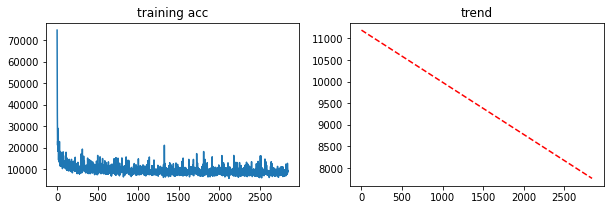

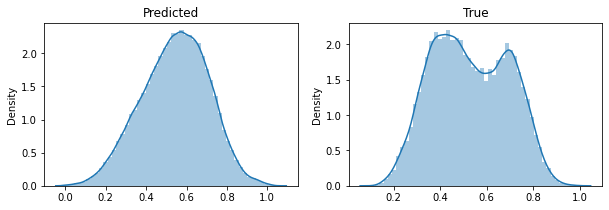

epoch 6/501 | batch 0/212.0 | time 0:00:33.734992 | loss 9178.21484
epoch 6/501 | batch 50/212.0 | time 0:00:34.959927 | loss 7908.18604
epoch 6/501 | batch 100/212.0 | time 0:00:36.065003 | loss 8520.03906
epoch 6/501 | batch 150/212.0 | time 0:00:37.168020 | loss 7719.72314
epoch 6/501 | batch 200/212.0 | time 0:00:38.274466 | loss 7447.61279
epoch 7/501 | batch 0/212.0 | time 0:00:38.549771 | loss 6473.22705
epoch 7/501 | batch 50/212.0 | time 0:00:39.659140 | loss 9819.45703
epoch 7/501 | batch 100/212.0 | time 0:00:40.773427 | loss 8120.47168
epoch 7/501 | batch 150/212.0 | time 0:00:41.875827 | loss 6992.81494
epoch 7/501 | batch 200/212.0 | time 0:00:42.984761 | loss 8631.23535
epoch 8/501 | batch 0/212.0 | time 0:00:43.263691 | loss 8244.2793
epoch 8/501 | batch 50/212.0 | time 0:00:44.370663 | loss 9635.60645
epoch 8/501 | batch 100/212.0 | time 0:00:45.482581 | loss 7925.53809
epoch 8/501 | batch 150/212.0 | time 0:00:46.599476 | loss 7407.62354
epoch 8/501 | batch 200/212.0 

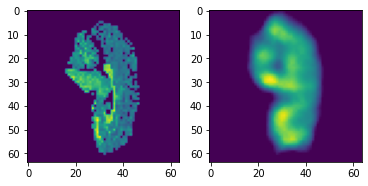

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


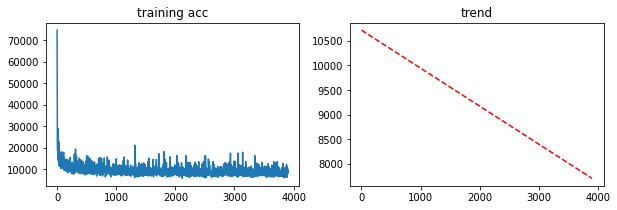

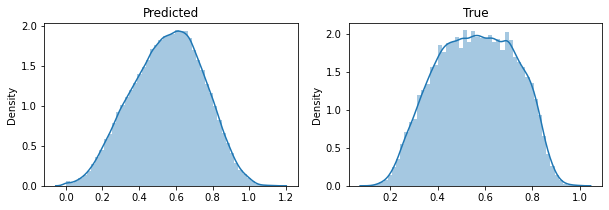

epoch 11/501 | batch 0/212.0 | time 0:00:59.995359 | loss 9196.66602
epoch 11/501 | batch 50/212.0 | time 0:01:01.210663 | loss 8500.40234
epoch 11/501 | batch 100/212.0 | time 0:01:02.323965 | loss 7009.1416
epoch 11/501 | batch 150/212.0 | time 0:01:03.440727 | loss 7653.47998
epoch 11/501 | batch 200/212.0 | time 0:01:04.555374 | loss 8621.69043
epoch 12/501 | batch 0/212.0 | time 0:01:04.835623 | loss 9336.50781
epoch 12/501 | batch 50/212.0 | time 0:01:05.952098 | loss 7824.23438
epoch 12/501 | batch 100/212.0 | time 0:01:07.065810 | loss 7474.81445
epoch 12/501 | batch 150/212.0 | time 0:01:08.185005 | loss 10235.95605
epoch 12/501 | batch 200/212.0 | time 0:01:09.299427 | loss 8015.17578
epoch 13/501 | batch 0/212.0 | time 0:01:09.578972 | loss 8542.97461
epoch 13/501 | batch 50/212.0 | time 0:01:10.693885 | loss 7669.08105
epoch 13/501 | batch 100/212.0 | time 0:01:11.808610 | loss 8695.42285
epoch 13/501 | batch 150/212.0 | time 0:01:12.922481 | loss 7202.08496
epoch 13/501 | 

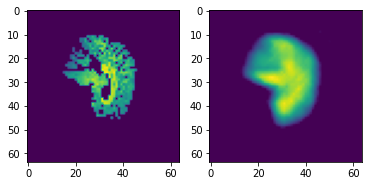

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


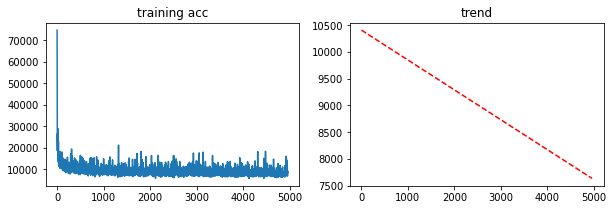

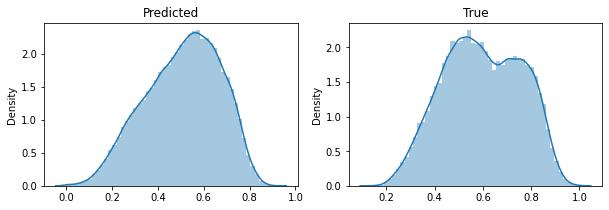

epoch 16/501 | batch 0/212.0 | time 0:01:26.273543 | loss 9191.3291
epoch 16/501 | batch 50/212.0 | time 0:01:27.494062 | loss 9550.92383
epoch 16/501 | batch 100/212.0 | time 0:01:28.610526 | loss 9052.35547
epoch 16/501 | batch 150/212.0 | time 0:01:29.725440 | loss 8491.55859
epoch 16/501 | batch 200/212.0 | time 0:01:30.839680 | loss 9410.31055
epoch 17/501 | batch 0/212.0 | time 0:01:31.117824 | loss 9149.54297
epoch 17/501 | batch 50/212.0 | time 0:01:32.233080 | loss 9013.86328
epoch 17/501 | batch 100/212.0 | time 0:01:33.348229 | loss 6470.59668
epoch 17/501 | batch 150/212.0 | time 0:01:34.462096 | loss 11194.64551
epoch 17/501 | batch 200/212.0 | time 0:01:35.578111 | loss 7764.354
epoch 18/501 | batch 0/212.0 | time 0:01:35.857361 | loss 7791.79785
epoch 18/501 | batch 50/212.0 | time 0:01:36.973868 | loss 6686.48486
epoch 18/501 | batch 100/212.0 | time 0:01:38.087901 | loss 10864.73828
epoch 18/501 | batch 150/212.0 | time 0:01:39.202330 | loss 7468.18408
epoch 18/501 | b

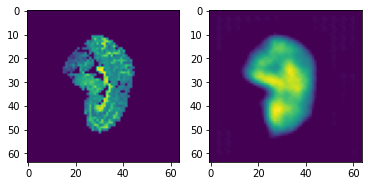

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


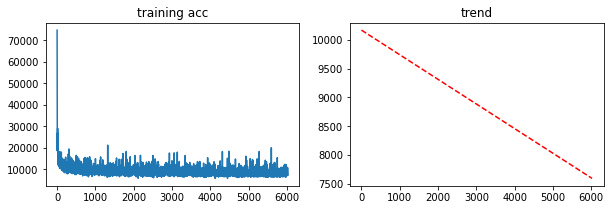

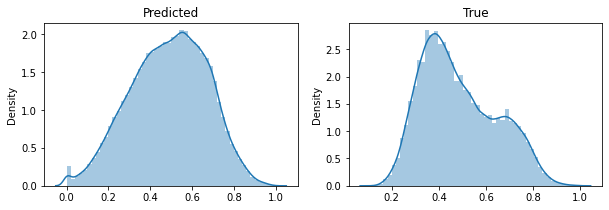

epoch 21/501 | batch 0/212.0 | time 0:01:52.608695 | loss 7538.38574
epoch 21/501 | batch 50/212.0 | time 0:01:53.825638 | loss 7653.18262
epoch 21/501 | batch 100/212.0 | time 0:01:54.941382 | loss 11366.07129
epoch 21/501 | batch 150/212.0 | time 0:01:56.056591 | loss 7393.67188
epoch 21/501 | batch 200/212.0 | time 0:01:57.172137 | loss 8769.65625
epoch 22/501 | batch 0/212.0 | time 0:01:57.450934 | loss 7191.30078
epoch 22/501 | batch 50/212.0 | time 0:01:58.566140 | loss 8077.45215
epoch 22/501 | batch 100/212.0 | time 0:01:59.684309 | loss 8578.58008
epoch 22/501 | batch 150/212.0 | time 0:02:00.808562 | loss 9116.04102
epoch 22/501 | batch 200/212.0 | time 0:02:01.923000 | loss 6539.23145
epoch 23/501 | batch 0/212.0 | time 0:02:02.203155 | loss 7356.24609
epoch 23/501 | batch 50/212.0 | time 0:02:03.318557 | loss 7026.45508
epoch 23/501 | batch 100/212.0 | time 0:02:04.434106 | loss 7614.89502
epoch 23/501 | batch 150/212.0 | time 0:02:05.548127 | loss 7460.69238
epoch 23/501 |

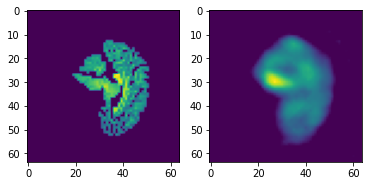

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


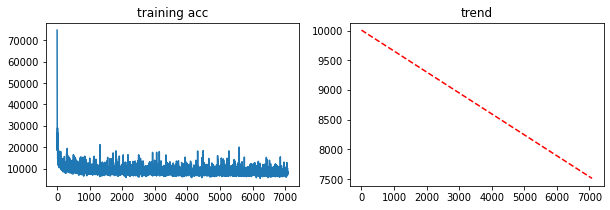

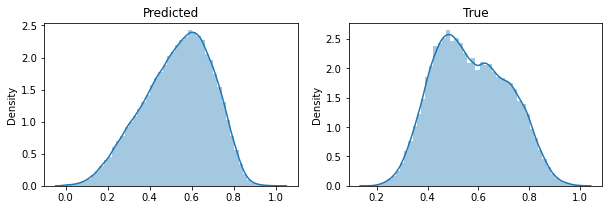

epoch 26/501 | batch 0/212.0 | time 0:02:18.868701 | loss 9095.96191
epoch 26/501 | batch 50/212.0 | time 0:02:20.091274 | loss 8255.98242
epoch 26/501 | batch 100/212.0 | time 0:02:21.206717 | loss 7470.54395
epoch 26/501 | batch 150/212.0 | time 0:02:22.323145 | loss 7224.91406
epoch 26/501 | batch 200/212.0 | time 0:02:23.437862 | loss 10751.54395
epoch 27/501 | batch 0/212.0 | time 0:02:23.716682 | loss 7868.56152
epoch 27/501 | batch 50/212.0 | time 0:02:24.833815 | loss 6135.1543
epoch 27/501 | batch 100/212.0 | time 0:02:25.951564 | loss 7222.29395
epoch 27/501 | batch 150/212.0 | time 0:02:27.067816 | loss 7681.51172
epoch 27/501 | batch 200/212.0 | time 0:02:28.189367 | loss 7465.70068
epoch 28/501 | batch 0/212.0 | time 0:02:28.470701 | loss 6490.32812
epoch 28/501 | batch 50/212.0 | time 0:02:29.590719 | loss 6432.18262
epoch 28/501 | batch 100/212.0 | time 0:02:30.707374 | loss 7430.55518
epoch 28/501 | batch 150/212.0 | time 0:02:31.822715 | loss 6740.2002
epoch 28/501 | b

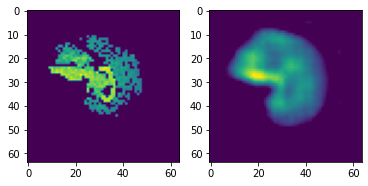

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


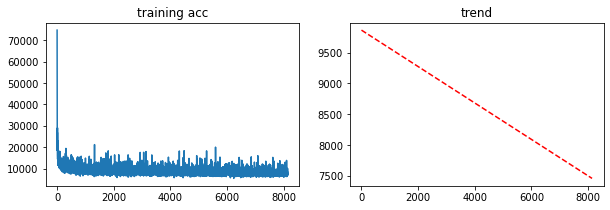

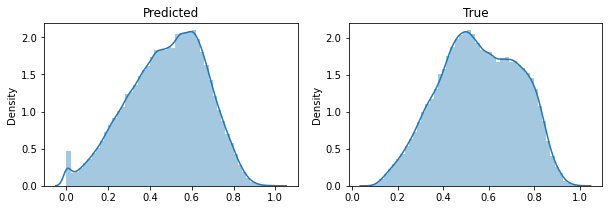

epoch 31/501 | batch 0/212.0 | time 0:02:45.380715 | loss 9443.61523
epoch 31/501 | batch 50/212.0 | time 0:02:46.600250 | loss 7140.37646
epoch 31/501 | batch 100/212.0 | time 0:02:47.715007 | loss 7759.46875
epoch 31/501 | batch 150/212.0 | time 0:02:48.829611 | loss 7234.55859
epoch 31/501 | batch 200/212.0 | time 0:02:49.946673 | loss 6589.73926
epoch 32/501 | batch 0/212.0 | time 0:02:50.226236 | loss 7785.69727
epoch 32/501 | batch 50/212.0 | time 0:02:51.345002 | loss 7183.59326
epoch 32/501 | batch 100/212.0 | time 0:02:52.458158 | loss 9735.49805
epoch 32/501 | batch 150/212.0 | time 0:02:53.572305 | loss 7517.75684
epoch 32/501 | batch 200/212.0 | time 0:02:54.687807 | loss 7476.43066
epoch 33/501 | batch 0/212.0 | time 0:02:54.966078 | loss 6683.67627
epoch 33/501 | batch 50/212.0 | time 0:02:56.080963 | loss 7440.58887
epoch 33/501 | batch 100/212.0 | time 0:02:57.198576 | loss 9562.04883
epoch 33/501 | batch 150/212.0 | time 0:02:58.312574 | loss 8032.9668
epoch 33/501 | b

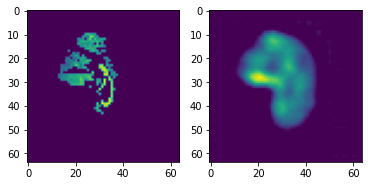

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


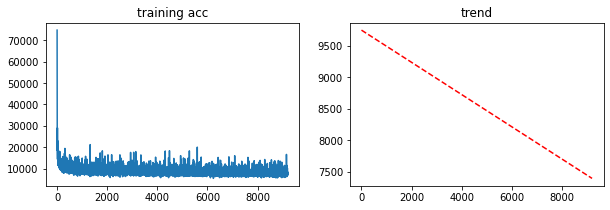

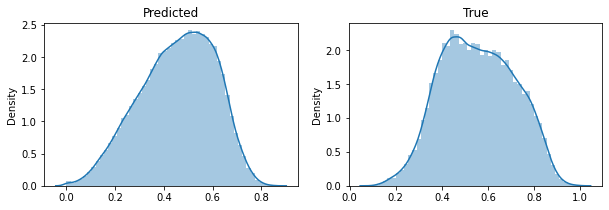

epoch 36/501 | batch 0/212.0 | time 0:03:11.699503 | loss 9728.18945
epoch 36/501 | batch 50/212.0 | time 0:03:12.923953 | loss 7542.87451
epoch 36/501 | batch 100/212.0 | time 0:03:14.038954 | loss 6544.71826
epoch 36/501 | batch 150/212.0 | time 0:03:15.153026 | loss 6796.91602
epoch 36/501 | batch 200/212.0 | time 0:03:16.266874 | loss 7885.75781
epoch 37/501 | batch 0/212.0 | time 0:03:16.547133 | loss 7471.59375
epoch 37/501 | batch 50/212.0 | time 0:03:17.662012 | loss 6765.18018
epoch 37/501 | batch 100/212.0 | time 0:03:18.777982 | loss 7761.21094
epoch 37/501 | batch 150/212.0 | time 0:03:19.894045 | loss 7353.5166
epoch 37/501 | batch 200/212.0 | time 0:03:21.014713 | loss 10540.59375
epoch 38/501 | batch 0/212.0 | time 0:03:21.297614 | loss 6118.80811
epoch 38/501 | batch 50/212.0 | time 0:03:22.414357 | loss 6750.06592
epoch 38/501 | batch 100/212.0 | time 0:03:23.530802 | loss 8075.81934
epoch 38/501 | batch 150/212.0 | time 0:03:24.648378 | loss 7256.07129
epoch 38/501 | 

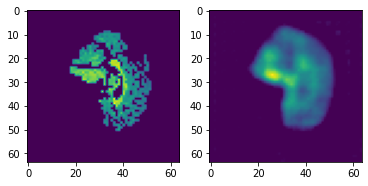

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


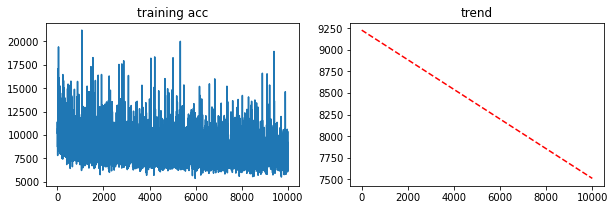

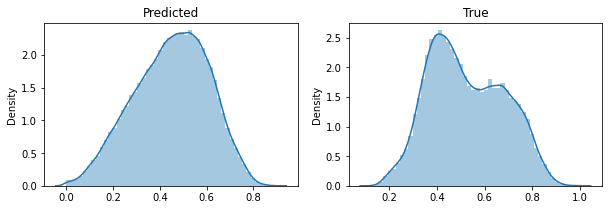

epoch 41/501 | batch 0/212.0 | time 0:03:38.159251 | loss 8468.50781
epoch 41/501 | batch 50/212.0 | time 0:03:39.399856 | loss 7973.20703
epoch 41/501 | batch 100/212.0 | time 0:03:40.514472 | loss 7339.24414
epoch 41/501 | batch 150/212.0 | time 0:03:41.628436 | loss 8169.39551
epoch 41/501 | batch 200/212.0 | time 0:03:42.743983 | loss 9359.99219
epoch 42/501 | batch 0/212.0 | time 0:03:43.023609 | loss 7008.95801
epoch 42/501 | batch 50/212.0 | time 0:03:44.145485 | loss 9009.80469
epoch 42/501 | batch 100/212.0 | time 0:03:45.264335 | loss 7657.09082
epoch 42/501 | batch 150/212.0 | time 0:03:46.378941 | loss 7704.05273
epoch 42/501 | batch 200/212.0 | time 0:03:47.499421 | loss 9298.10742
epoch 43/501 | batch 0/212.0 | time 0:03:47.780776 | loss 7857.94287
epoch 43/501 | batch 50/212.0 | time 0:03:48.896737 | loss 8893.17969
epoch 43/501 | batch 100/212.0 | time 0:03:50.015835 | loss 6495.22266
epoch 43/501 | batch 150/212.0 | time 0:03:51.130641 | loss 7271.15771
epoch 43/501 | 

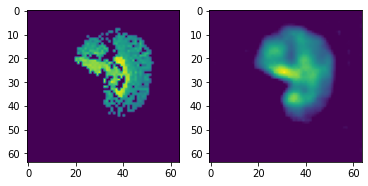

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


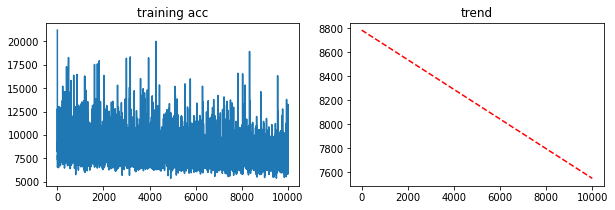

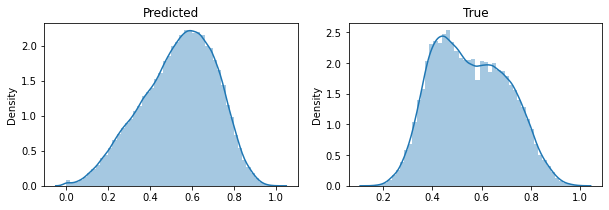

epoch 46/501 | batch 0/212.0 | time 0:04:04.551732 | loss 8249.77734
epoch 46/501 | batch 50/212.0 | time 0:04:05.775478 | loss 8058.33398
epoch 46/501 | batch 100/212.0 | time 0:04:06.890913 | loss 7472.56836
epoch 46/501 | batch 150/212.0 | time 0:04:08.010865 | loss 6328.25488
epoch 46/501 | batch 200/212.0 | time 0:04:09.127894 | loss 13288.8457
epoch 47/501 | batch 0/212.0 | time 0:04:09.408472 | loss 7828.53516
epoch 47/501 | batch 50/212.0 | time 0:04:10.529244 | loss 8497.22461
epoch 47/501 | batch 100/212.0 | time 0:04:11.644383 | loss 7186.23193
epoch 47/501 | batch 150/212.0 | time 0:04:12.759222 | loss 7362.45459
epoch 47/501 | batch 200/212.0 | time 0:04:13.873185 | loss 7031.42676
epoch 48/501 | batch 0/212.0 | time 0:04:14.153552 | loss 7147.8877
epoch 48/501 | batch 50/212.0 | time 0:04:15.268745 | loss 7306.59082
epoch 48/501 | batch 100/212.0 | time 0:04:16.383465 | loss 10187.63086
epoch 48/501 | batch 150/212.0 | time 0:04:17.499079 | loss 7738.37207
epoch 48/501 | 

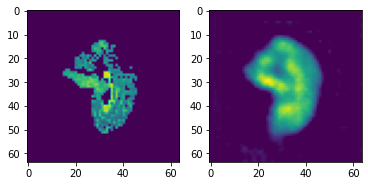

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


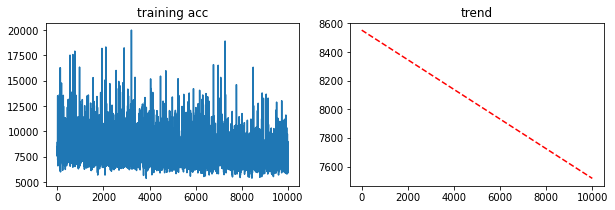

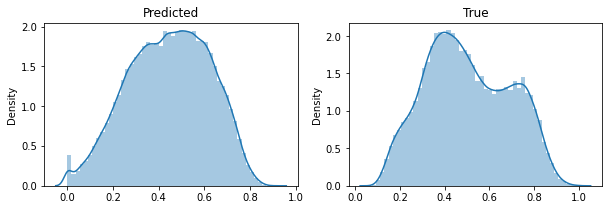

epoch 51/501 | batch 0/212.0 | time 0:04:30.905836 | loss 6757.78711
epoch 51/501 | batch 50/212.0 | time 0:04:32.141314 | loss 9608.36328
epoch 51/501 | batch 100/212.0 | time 0:04:33.255412 | loss 6796.47412
epoch 51/501 | batch 150/212.0 | time 0:04:34.369450 | loss 7836.26758
epoch 51/501 | batch 200/212.0 | time 0:04:35.485775 | loss 6201.46777
epoch 52/501 | batch 0/212.0 | time 0:04:35.766414 | loss 7835.89355
epoch 52/501 | batch 50/212.0 | time 0:04:36.884167 | loss 6108.4375
epoch 52/501 | batch 100/212.0 | time 0:04:37.999159 | loss 7324.20361
epoch 52/501 | batch 150/212.0 | time 0:04:39.112866 | loss 8081.01172
epoch 52/501 | batch 200/212.0 | time 0:04:40.228681 | loss 7411.12012
epoch 53/501 | batch 0/212.0 | time 0:04:40.508813 | loss 7669.34082
epoch 53/501 | batch 50/212.0 | time 0:04:41.625850 | loss 6083.75049
epoch 53/501 | batch 100/212.0 | time 0:04:42.742121 | loss 7363.90332
epoch 53/501 | batch 150/212.0 | time 0:04:43.857556 | loss 7631.65918
epoch 53/501 | b

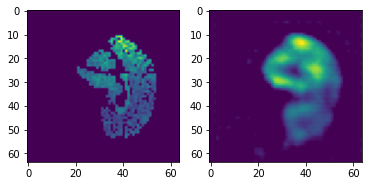

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


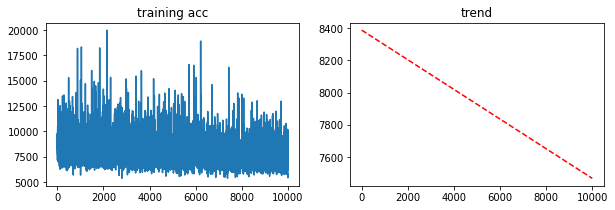

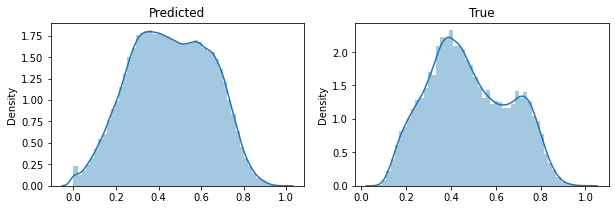

epoch 56/501 | batch 0/212.0 | time 0:04:57.338251 | loss 7928.13916
epoch 56/501 | batch 50/212.0 | time 0:04:58.552148 | loss 5598.05273
epoch 56/501 | batch 100/212.0 | time 0:04:59.669689 | loss 8719.63965
epoch 56/501 | batch 150/212.0 | time 0:05:00.786509 | loss 7159.46973
epoch 56/501 | batch 200/212.0 | time 0:05:01.912692 | loss 6769.89697
epoch 57/501 | batch 0/212.0 | time 0:05:02.195195 | loss 6271.59766
epoch 57/501 | batch 50/212.0 | time 0:05:03.318221 | loss 7037.58057
epoch 57/501 | batch 100/212.0 | time 0:05:04.436606 | loss 7668.29639
epoch 57/501 | batch 150/212.0 | time 0:05:05.551400 | loss 6851.10938
epoch 57/501 | batch 200/212.0 | time 0:05:06.668703 | loss 7146.68457
epoch 58/501 | batch 0/212.0 | time 0:05:06.948551 | loss 7947.54736
epoch 58/501 | batch 50/212.0 | time 0:05:08.068455 | loss 6466.33887
epoch 58/501 | batch 100/212.0 | time 0:05:09.182839 | loss 6337.49463
epoch 58/501 | batch 150/212.0 | time 0:05:10.298191 | loss 6239.62549
epoch 58/501 | 

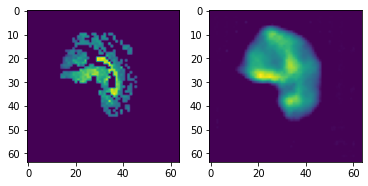

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


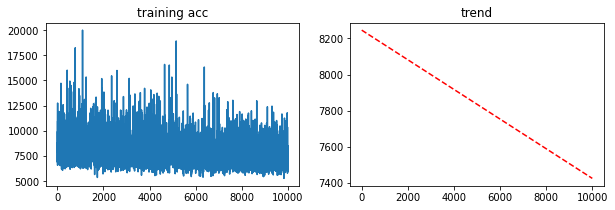

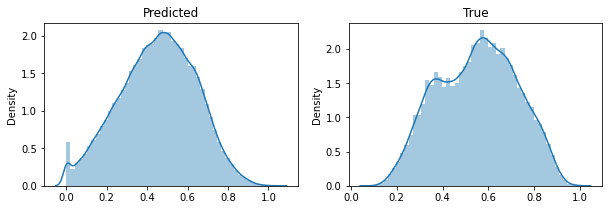

epoch 61/501 | batch 0/212.0 | time 0:05:23.937742 | loss 8075.83057
epoch 61/501 | batch 50/212.0 | time 0:05:25.181546 | loss 5739.75977
epoch 61/501 | batch 100/212.0 | time 0:05:26.299879 | loss 7525.71143
epoch 61/501 | batch 150/212.0 | time 0:05:27.417268 | loss 6340.49609
epoch 61/501 | batch 200/212.0 | time 0:05:28.534330 | loss 7138.42285
epoch 62/501 | batch 0/212.0 | time 0:05:28.814075 | loss 6928.08643
epoch 62/501 | batch 50/212.0 | time 0:05:29.933681 | loss 7933.32715
epoch 62/501 | batch 100/212.0 | time 0:05:31.048218 | loss 6699.66064
epoch 62/501 | batch 150/212.0 | time 0:05:32.164389 | loss 7297.8418
epoch 62/501 | batch 200/212.0 | time 0:05:33.279116 | loss 7497.40234
epoch 63/501 | batch 0/212.0 | time 0:05:33.559192 | loss 7266.7207
epoch 63/501 | batch 50/212.0 | time 0:05:34.681493 | loss 6922.62793
epoch 63/501 | batch 100/212.0 | time 0:05:35.796076 | loss 7955.58496
epoch 63/501 | batch 150/212.0 | time 0:05:36.910938 | loss 6345.75391
epoch 63/501 | ba

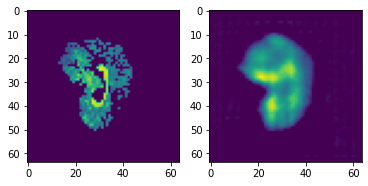

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


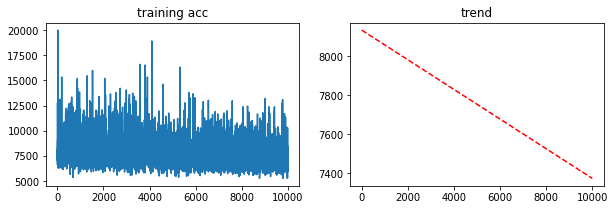

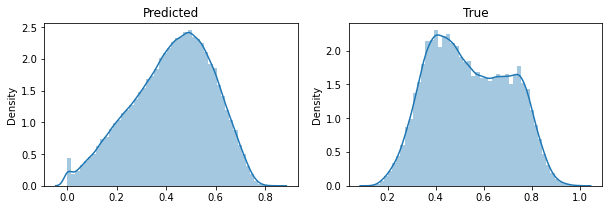

epoch 66/501 | batch 0/212.0 | time 0:05:50.344960 | loss 7162.65918
epoch 66/501 | batch 50/212.0 | time 0:05:51.563044 | loss 5942.69043
epoch 66/501 | batch 100/212.0 | time 0:05:52.677967 | loss 7426.90674
epoch 66/501 | batch 150/212.0 | time 0:05:53.791923 | loss 9412.79297
epoch 66/501 | batch 200/212.0 | time 0:05:54.906346 | loss 6808.93896
epoch 67/501 | batch 0/212.0 | time 0:05:55.186667 | loss 6744.58838
epoch 67/501 | batch 50/212.0 | time 0:05:56.310392 | loss 7965.83691
epoch 67/501 | batch 100/212.0 | time 0:05:57.425807 | loss 7684.53711
epoch 67/501 | batch 150/212.0 | time 0:05:58.540863 | loss 7425.2666
epoch 67/501 | batch 200/212.0 | time 0:05:59.658604 | loss 6886.99854
epoch 68/501 | batch 0/212.0 | time 0:05:59.939352 | loss 7935.87695
epoch 68/501 | batch 50/212.0 | time 0:06:01.060703 | loss 7294.12061
epoch 68/501 | batch 100/212.0 | time 0:06:02.177966 | loss 8163.8418
epoch 68/501 | batch 150/212.0 | time 0:06:03.293573 | loss 6065.98975
epoch 68/501 | ba

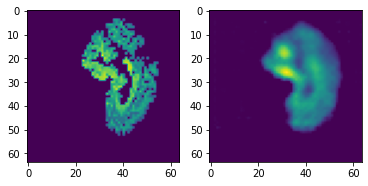

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


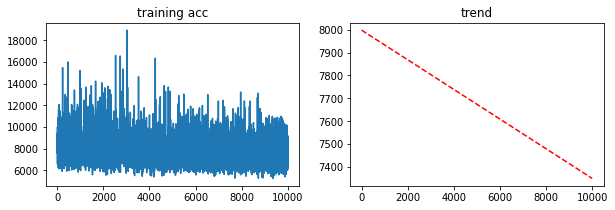

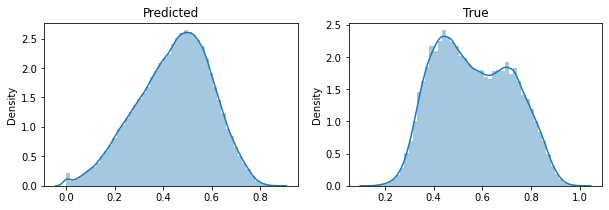

epoch 71/501 | batch 0/212.0 | time 0:06:16.807810 | loss 5295.59375
epoch 71/501 | batch 50/212.0 | time 0:06:18.048828 | loss 9035.54492
epoch 71/501 | batch 100/212.0 | time 0:06:19.164027 | loss 8164.20898
epoch 71/501 | batch 150/212.0 | time 0:06:20.279316 | loss 7733.37061
epoch 71/501 | batch 200/212.0 | time 0:06:21.400563 | loss 7571.33301
epoch 72/501 | batch 0/212.0 | time 0:06:21.680670 | loss 7161.71826
epoch 72/501 | batch 50/212.0 | time 0:06:22.795847 | loss 6717.49463
epoch 72/501 | batch 100/212.0 | time 0:06:23.910486 | loss 6809.8208
epoch 72/501 | batch 150/212.0 | time 0:06:25.026885 | loss 6081.03125
epoch 72/501 | batch 200/212.0 | time 0:06:26.141423 | loss 6308.33594
epoch 73/501 | batch 0/212.0 | time 0:06:26.420852 | loss 7713.85498
epoch 73/501 | batch 50/212.0 | time 0:06:27.540384 | loss 9067.26562
epoch 73/501 | batch 100/212.0 | time 0:06:28.654824 | loss 6919.73145
epoch 73/501 | batch 150/212.0 | time 0:06:29.770160 | loss 9071.19336
epoch 73/501 | b

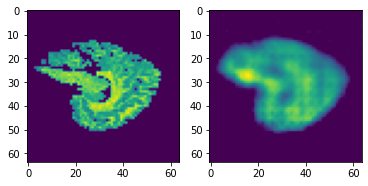

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


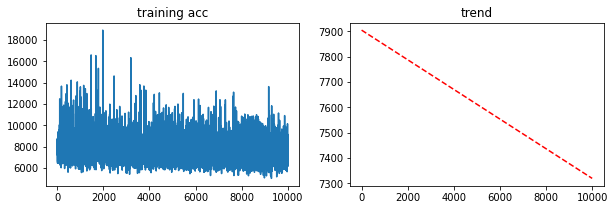

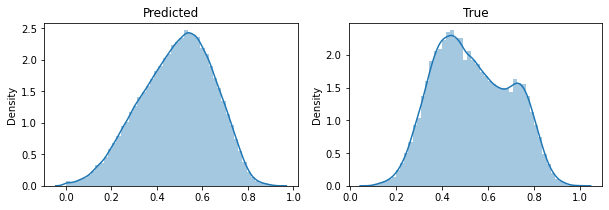

epoch 76/501 | batch 0/212.0 | time 0:06:43.235233 | loss 7632.91602
epoch 76/501 | batch 50/212.0 | time 0:06:44.465949 | loss 7447.22168
epoch 76/501 | batch 100/212.0 | time 0:06:45.581467 | loss 8810.88086
epoch 76/501 | batch 150/212.0 | time 0:06:46.694961 | loss 6878.03711
epoch 76/501 | batch 200/212.0 | time 0:06:47.818057 | loss 6875.83936
epoch 77/501 | batch 0/212.0 | time 0:06:48.097626 | loss 6010.79639
epoch 77/501 | batch 50/212.0 | time 0:06:49.217875 | loss 6522.9502
epoch 77/501 | batch 100/212.0 | time 0:06:50.335718 | loss 7695.23975
epoch 77/501 | batch 150/212.0 | time 0:06:51.454119 | loss 7320.88721
epoch 77/501 | batch 200/212.0 | time 0:06:52.568932 | loss 8134.23096
epoch 78/501 | batch 0/212.0 | time 0:06:52.849242 | loss 7676.78125
epoch 78/501 | batch 50/212.0 | time 0:06:53.963932 | loss 6377.5874
epoch 78/501 | batch 100/212.0 | time 0:06:55.080143 | loss 7210.646
epoch 78/501 | batch 150/212.0 | time 0:06:56.194823 | loss 6081.67236
epoch 78/501 | batc

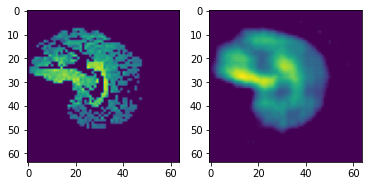

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


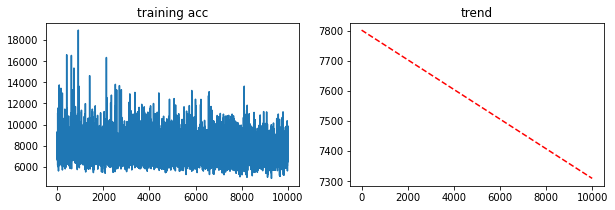

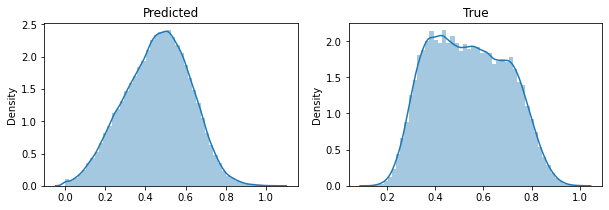

epoch 81/501 | batch 0/212.0 | time 0:07:09.666625 | loss 7257.47803
epoch 81/501 | batch 50/212.0 | time 0:07:10.878080 | loss 6461.10938
epoch 81/501 | batch 100/212.0 | time 0:07:11.992265 | loss 6211.28809
epoch 81/501 | batch 150/212.0 | time 0:07:13.106138 | loss 6190.90234
epoch 81/501 | batch 200/212.0 | time 0:07:14.225413 | loss 7846.3335
epoch 82/501 | batch 0/212.0 | time 0:07:14.505001 | loss 7647.94727
epoch 82/501 | batch 50/212.0 | time 0:07:15.623860 | loss 7474.02881
epoch 82/501 | batch 100/212.0 | time 0:07:16.740727 | loss 7166.55566
epoch 82/501 | batch 150/212.0 | time 0:07:17.859571 | loss 7136.83496
epoch 82/501 | batch 200/212.0 | time 0:07:18.973368 | loss 7451.45361
epoch 83/501 | batch 0/212.0 | time 0:07:19.251511 | loss 8886.95605
epoch 83/501 | batch 50/212.0 | time 0:07:20.366731 | loss 7180.44482
epoch 83/501 | batch 100/212.0 | time 0:07:21.481065 | loss 6165.43506
epoch 83/501 | batch 150/212.0 | time 0:07:22.596698 | loss 7096.30469
epoch 83/501 | b

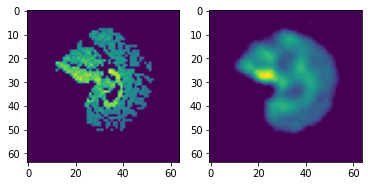

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


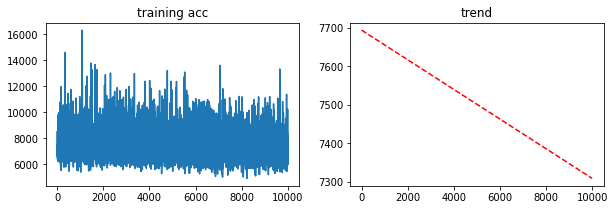

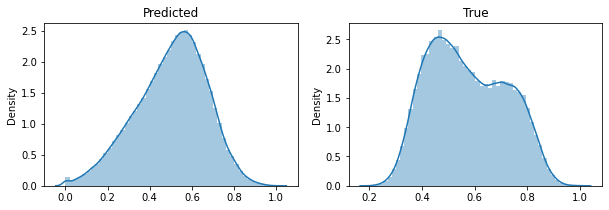

epoch 86/501 | batch 0/212.0 | time 0:07:36.289207 | loss 7977.48047
epoch 86/501 | batch 50/212.0 | time 0:07:37.539925 | loss 6417.73242
epoch 86/501 | batch 100/212.0 | time 0:07:38.655218 | loss 7058.91113
epoch 86/501 | batch 150/212.0 | time 0:07:39.769905 | loss 7424.27539
epoch 86/501 | batch 200/212.0 | time 0:07:40.886217 | loss 6701.28809
epoch 87/501 | batch 0/212.0 | time 0:07:41.166265 | loss 7661.60303
epoch 87/501 | batch 50/212.0 | time 0:07:42.282118 | loss 6985.3291
epoch 87/501 | batch 100/212.0 | time 0:07:43.396333 | loss 7344.25879
epoch 87/501 | batch 150/212.0 | time 0:07:44.511680 | loss 7431.91406
epoch 87/501 | batch 200/212.0 | time 0:07:45.626332 | loss 6805.12988
epoch 88/501 | batch 0/212.0 | time 0:07:45.906456 | loss 8296.76172
epoch 88/501 | batch 50/212.0 | time 0:07:47.028614 | loss 8773.08203
epoch 88/501 | batch 100/212.0 | time 0:07:48.150201 | loss 6779.86816
epoch 88/501 | batch 150/212.0 | time 0:07:49.264979 | loss 9360.82031
epoch 88/501 | b

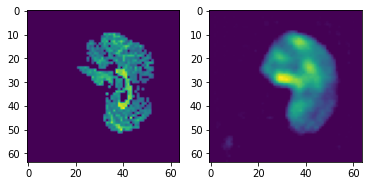

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


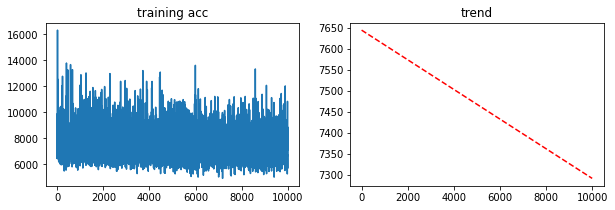

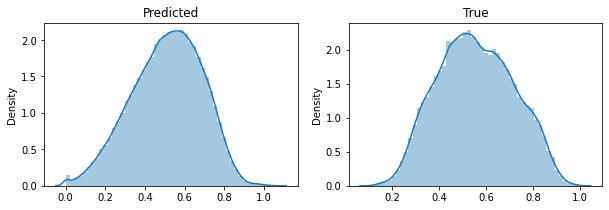

epoch 91/501 | batch 0/212.0 | time 0:08:02.775746 | loss 6904.40723
epoch 91/501 | batch 50/212.0 | time 0:08:04.022784 | loss 7047.7627
epoch 91/501 | batch 100/212.0 | time 0:08:05.145974 | loss 6754.48633
epoch 91/501 | batch 150/212.0 | time 0:08:06.264613 | loss 7090.94629
epoch 91/501 | batch 200/212.0 | time 0:08:07.381497 | loss 6833.52588
epoch 92/501 | batch 0/212.0 | time 0:08:07.661483 | loss 7338.65039
epoch 92/501 | batch 50/212.0 | time 0:08:08.777580 | loss 6983.18164
epoch 92/501 | batch 100/212.0 | time 0:08:09.896009 | loss 7515.04541
epoch 92/501 | batch 150/212.0 | time 0:08:11.019089 | loss 8209.15625
epoch 92/501 | batch 200/212.0 | time 0:08:12.133295 | loss 6594.49805
epoch 93/501 | batch 0/212.0 | time 0:08:12.414237 | loss 6741.69434
epoch 93/501 | batch 50/212.0 | time 0:08:13.530694 | loss 8824.41895
epoch 93/501 | batch 100/212.0 | time 0:08:14.646473 | loss 7594.73096
epoch 93/501 | batch 150/212.0 | time 0:08:15.761255 | loss 5699.4458
epoch 93/501 | ba

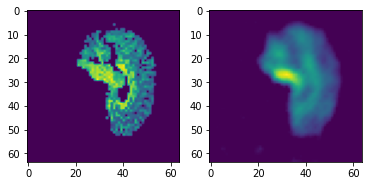

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


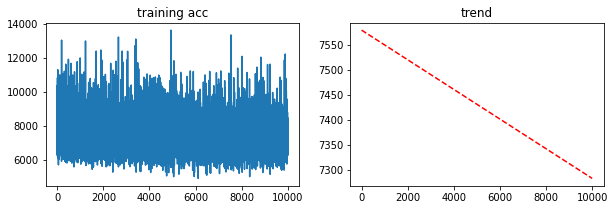

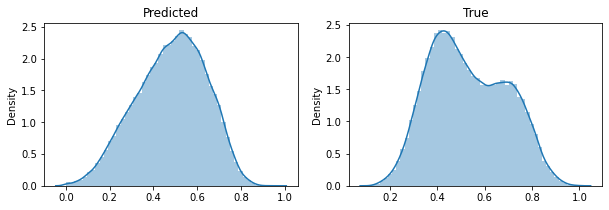

epoch 96/501 | batch 0/212.0 | time 0:08:29.127509 | loss 6225.91455
epoch 96/501 | batch 50/212.0 | time 0:08:30.380102 | loss 7725.19434
epoch 96/501 | batch 100/212.0 | time 0:08:31.504151 | loss 7765.58447
epoch 96/501 | batch 150/212.0 | time 0:08:32.624526 | loss 6358.04102
epoch 96/501 | batch 200/212.0 | time 0:08:33.742588 | loss 6482.42188
epoch 97/501 | batch 0/212.0 | time 0:08:34.022077 | loss 7352.57129
epoch 97/501 | batch 50/212.0 | time 0:08:35.139423 | loss 6877.33252
epoch 97/501 | batch 100/212.0 | time 0:08:36.254297 | loss 6528.16748
epoch 97/501 | batch 150/212.0 | time 0:08:37.370981 | loss 7155.91602
epoch 97/501 | batch 200/212.0 | time 0:08:38.489103 | loss 7219.29443
epoch 98/501 | batch 0/212.0 | time 0:08:38.769079 | loss 7272.22461
epoch 98/501 | batch 50/212.0 | time 0:08:39.887923 | loss 7469.68604
epoch 98/501 | batch 100/212.0 | time 0:08:41.004360 | loss 9613.99414
epoch 98/501 | batch 150/212.0 | time 0:08:42.122569 | loss 8089.62207
epoch 98/501 | 

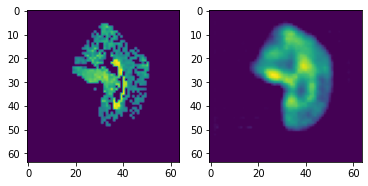

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


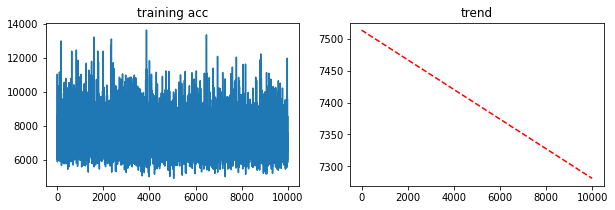

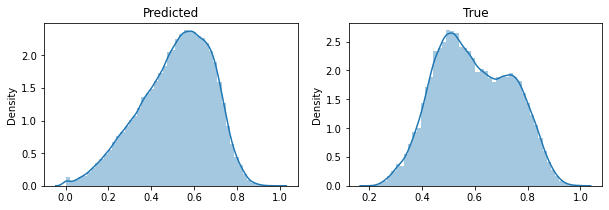

epoch 101/501 | batch 0/212.0 | time 0:08:55.838489 | loss 6314.90723
epoch 101/501 | batch 50/212.0 | time 0:08:57.088612 | loss 7875.81152
epoch 101/501 | batch 100/212.0 | time 0:08:58.202881 | loss 7881.84277
epoch 101/501 | batch 150/212.0 | time 0:08:59.318142 | loss 6342.47656
epoch 101/501 | batch 200/212.0 | time 0:09:00.436998 | loss 7178.10303
epoch 102/501 | batch 0/212.0 | time 0:09:00.716651 | loss 8685.75391
epoch 102/501 | batch 50/212.0 | time 0:09:01.833723 | loss 7464.75781
epoch 102/501 | batch 100/212.0 | time 0:09:02.949764 | loss 6141.8291
epoch 102/501 | batch 150/212.0 | time 0:09:04.070289 | loss 6204.65381
epoch 102/501 | batch 200/212.0 | time 0:09:05.185249 | loss 6580.86426
epoch 103/501 | batch 0/212.0 | time 0:09:05.464164 | loss 8026.05176
epoch 103/501 | batch 50/212.0 | time 0:09:06.580834 | loss 6771.35449
epoch 103/501 | batch 100/212.0 | time 0:09:07.701837 | loss 6338.50439
epoch 103/501 | batch 150/212.0 | time 0:09:08.820808 | loss 7129.77441
ep

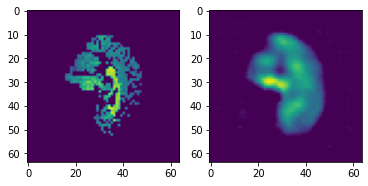

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


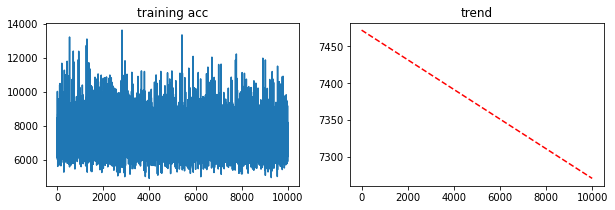

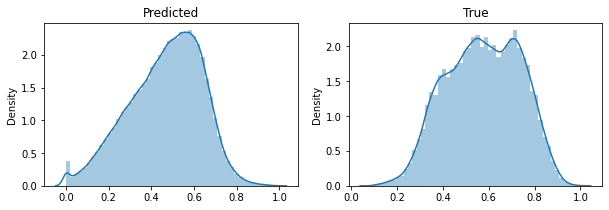

epoch 106/501 | batch 0/212.0 | time 0:09:22.396891 | loss 7188.7041
epoch 106/501 | batch 50/212.0 | time 0:09:23.618159 | loss 6425.97266
epoch 106/501 | batch 100/212.0 | time 0:09:24.732992 | loss 7564.9082
epoch 106/501 | batch 150/212.0 | time 0:09:25.854733 | loss 8241.91211
epoch 106/501 | batch 200/212.0 | time 0:09:26.972254 | loss 7085.3623
epoch 107/501 | batch 0/212.0 | time 0:09:27.252614 | loss 7380.72949
epoch 107/501 | batch 50/212.0 | time 0:09:28.368998 | loss 7473.11426
epoch 107/501 | batch 100/212.0 | time 0:09:29.486638 | loss 10886.26172
epoch 107/501 | batch 150/212.0 | time 0:09:30.608668 | loss 6940.12842
epoch 107/501 | batch 200/212.0 | time 0:09:31.732742 | loss 6839.72949
epoch 108/501 | batch 0/212.0 | time 0:09:32.015166 | loss 7516.24219
epoch 108/501 | batch 50/212.0 | time 0:09:33.136769 | loss 8766.95215
epoch 108/501 | batch 100/212.0 | time 0:09:34.253776 | loss 6756.5332
epoch 108/501 | batch 150/212.0 | time 0:09:35.371938 | loss 10189.06445
epo

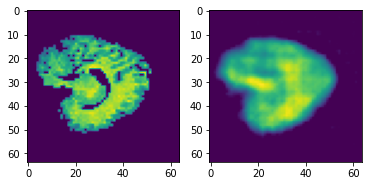

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


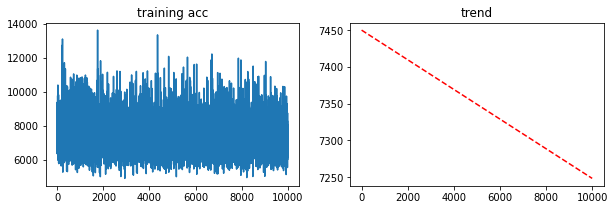

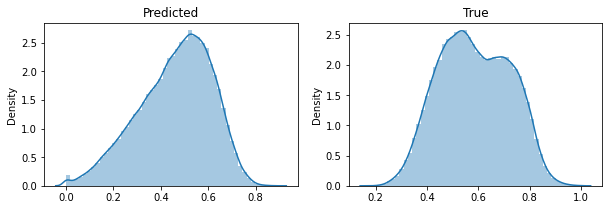

epoch 111/501 | batch 0/212.0 | time 0:09:48.976283 | loss 9192.95508
epoch 111/501 | batch 50/212.0 | time 0:09:50.207781 | loss 8039.65186
epoch 111/501 | batch 100/212.0 | time 0:09:51.328437 | loss 7599.99316
epoch 111/501 | batch 150/212.0 | time 0:09:52.445284 | loss 7127.50391
epoch 111/501 | batch 200/212.0 | time 0:09:53.560385 | loss 11132.84277
epoch 112/501 | batch 0/212.0 | time 0:09:53.841063 | loss 7163.39551
epoch 112/501 | batch 50/212.0 | time 0:09:54.956380 | loss 6955.09229
epoch 112/501 | batch 100/212.0 | time 0:09:56.072397 | loss 6237.11035
epoch 112/501 | batch 150/212.0 | time 0:09:57.186217 | loss 7158.99854
epoch 112/501 | batch 200/212.0 | time 0:09:58.300702 | loss 8075.03467
epoch 113/501 | batch 0/212.0 | time 0:09:58.580497 | loss 8134.74707
epoch 113/501 | batch 50/212.0 | time 0:09:59.695979 | loss 6565.02734
epoch 113/501 | batch 100/212.0 | time 0:10:00.820838 | loss 6812.19873
epoch 113/501 | batch 150/212.0 | time 0:10:01.936099 | loss 6513.22217


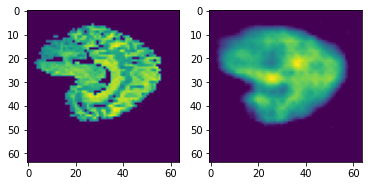

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


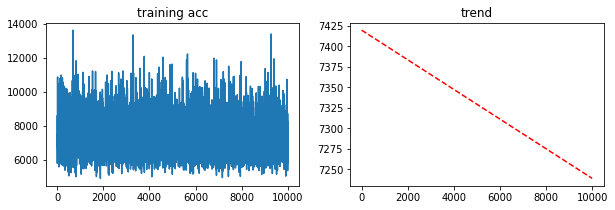

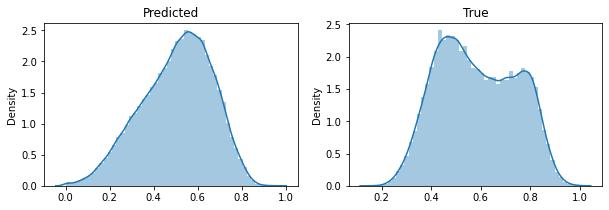

epoch 116/501 | batch 0/212.0 | time 0:10:15.267188 | loss 5880.47559
epoch 116/501 | batch 50/212.0 | time 0:10:16.488638 | loss 7735.21533
epoch 116/501 | batch 100/212.0 | time 0:10:17.604111 | loss 8783.80078
epoch 116/501 | batch 150/212.0 | time 0:10:18.720366 | loss 7265.84961
epoch 116/501 | batch 200/212.0 | time 0:10:19.839629 | loss 6852.50098
epoch 117/501 | batch 0/212.0 | time 0:10:20.118924 | loss 6430.34277
epoch 117/501 | batch 50/212.0 | time 0:10:21.242544 | loss 6659.0874
epoch 117/501 | batch 100/212.0 | time 0:10:22.359777 | loss 5825.26465
epoch 117/501 | batch 150/212.0 | time 0:10:23.473590 | loss 7879.85254
epoch 117/501 | batch 200/212.0 | time 0:10:24.589233 | loss 6807.69775
epoch 118/501 | batch 0/212.0 | time 0:10:24.868406 | loss 8444.33789
epoch 118/501 | batch 50/212.0 | time 0:10:25.983197 | loss 7681.08789
epoch 118/501 | batch 100/212.0 | time 0:10:27.100073 | loss 7847.16992
epoch 118/501 | batch 150/212.0 | time 0:10:28.218682 | loss 6196.43896
ep

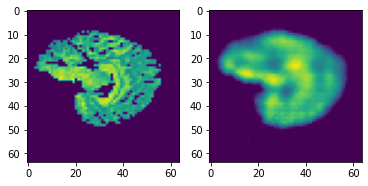

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


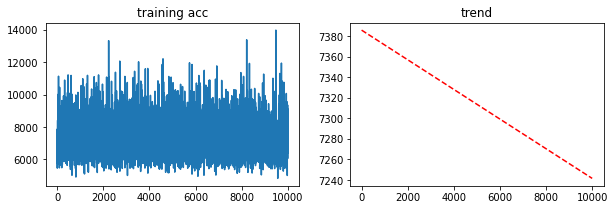

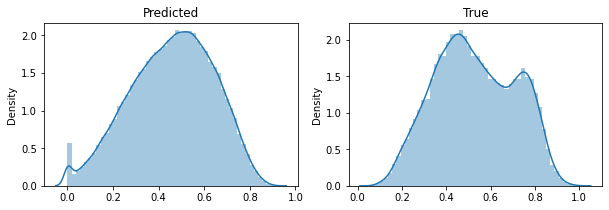

epoch 121/501 | batch 0/212.0 | time 0:10:41.533340 | loss 5706.3125
epoch 121/501 | batch 50/212.0 | time 0:10:42.749587 | loss 6695.23584
epoch 121/501 | batch 100/212.0 | time 0:10:43.865693 | loss 7042.88037
epoch 121/501 | batch 150/212.0 | time 0:10:44.992015 | loss 6485.19629
epoch 121/501 | batch 200/212.0 | time 0:10:46.109913 | loss 8266.24707
epoch 122/501 | batch 0/212.0 | time 0:10:46.389823 | loss 7101.66748
epoch 122/501 | batch 50/212.0 | time 0:10:47.505751 | loss 8209.31641
epoch 122/501 | batch 100/212.0 | time 0:10:48.619348 | loss 6135.02295
epoch 122/501 | batch 150/212.0 | time 0:10:49.733803 | loss 8070.93164
epoch 122/501 | batch 200/212.0 | time 0:10:50.851507 | loss 7111.36963
epoch 123/501 | batch 0/212.0 | time 0:10:51.132781 | loss 6691.29736
epoch 123/501 | batch 50/212.0 | time 0:10:52.247101 | loss 6839.72852
epoch 123/501 | batch 100/212.0 | time 0:10:53.363373 | loss 7417.18994
epoch 123/501 | batch 150/212.0 | time 0:10:54.477566 | loss 7574.74561
ep

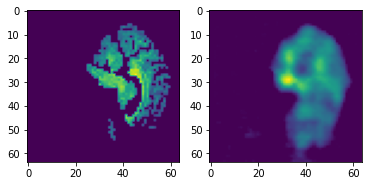

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


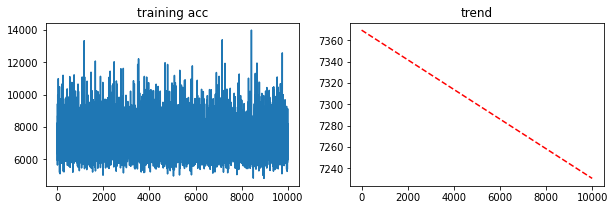

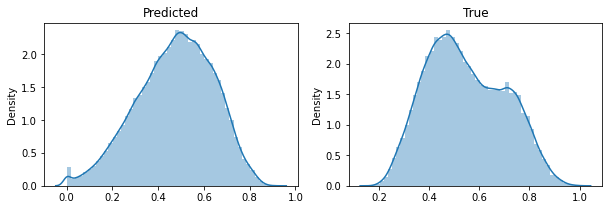

epoch 126/501 | batch 0/212.0 | time 0:11:07.790978 | loss 8378.49902
epoch 126/501 | batch 50/212.0 | time 0:11:09.035862 | loss 8717.71289
epoch 126/501 | batch 100/212.0 | time 0:11:10.150860 | loss 9876.27344
epoch 126/501 | batch 150/212.0 | time 0:11:11.264884 | loss 7065.56787
epoch 126/501 | batch 200/212.0 | time 0:11:12.379542 | loss 8986.02539
epoch 127/501 | batch 0/212.0 | time 0:11:12.658728 | loss 8233.71484
epoch 127/501 | batch 50/212.0 | time 0:11:13.774421 | loss 7531.42578
epoch 127/501 | batch 100/212.0 | time 0:11:14.892003 | loss 7995.79688
epoch 127/501 | batch 150/212.0 | time 0:11:16.008121 | loss 6430.98633
epoch 127/501 | batch 200/212.0 | time 0:11:17.123510 | loss 7404.41553
epoch 128/501 | batch 0/212.0 | time 0:11:17.401916 | loss 8844.15234
epoch 128/501 | batch 50/212.0 | time 0:11:18.517273 | loss 7885.96143
epoch 128/501 | batch 100/212.0 | time 0:11:19.631727 | loss 6567.80566
epoch 128/501 | batch 150/212.0 | time 0:11:20.746705 | loss 6142.48584
e

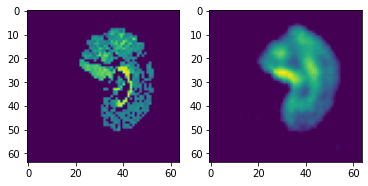

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


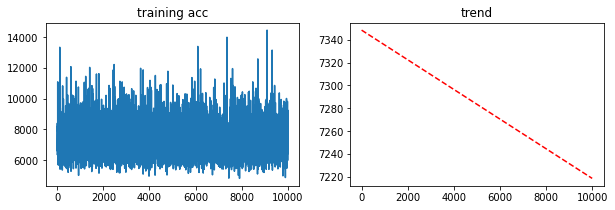

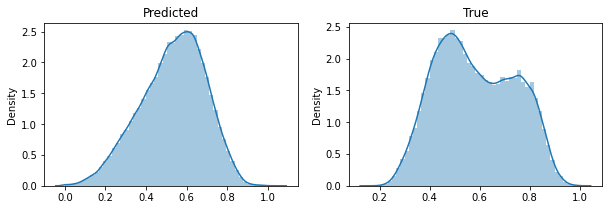

epoch 131/501 | batch 0/212.0 | time 0:11:34.188125 | loss 6969.7959
epoch 131/501 | batch 50/212.0 | time 0:11:35.406673 | loss 6722.84473
epoch 131/501 | batch 100/212.0 | time 0:11:36.523616 | loss 7226.5874
epoch 131/501 | batch 150/212.0 | time 0:11:37.639690 | loss 9522.3584
epoch 131/501 | batch 200/212.0 | time 0:11:38.754194 | loss 6614.8252
epoch 132/501 | batch 0/212.0 | time 0:11:39.034127 | loss 6210.22705
epoch 132/501 | batch 50/212.0 | time 0:11:40.148659 | loss 6772.05078
epoch 132/501 | batch 100/212.0 | time 0:11:41.262334 | loss 7876.18164
epoch 132/501 | batch 150/212.0 | time 0:11:42.376655 | loss 6866.00928
epoch 132/501 | batch 200/212.0 | time 0:11:43.491373 | loss 7570.52344
epoch 133/501 | batch 0/212.0 | time 0:11:43.772086 | loss 7265.81152
epoch 133/501 | batch 50/212.0 | time 0:11:44.889723 | loss 6692.46387
epoch 133/501 | batch 100/212.0 | time 0:11:46.008594 | loss 7547.79102
epoch 133/501 | batch 150/212.0 | time 0:11:47.130787 | loss 7163.27441
epoch

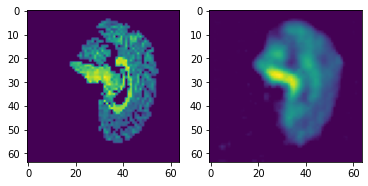

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


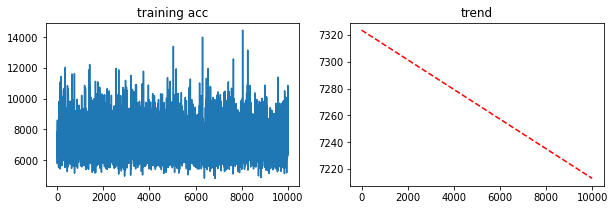

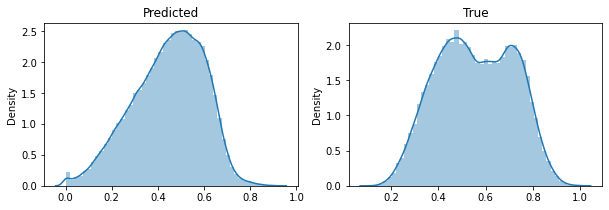

epoch 136/501 | batch 0/212.0 | time 0:12:00.609578 | loss 7239.75684
epoch 136/501 | batch 50/212.0 | time 0:12:01.859082 | loss 9444.09863
epoch 136/501 | batch 100/212.0 | time 0:12:02.975905 | loss 7045.92285
epoch 136/501 | batch 150/212.0 | time 0:12:04.097714 | loss 6358.28516
epoch 136/501 | batch 200/212.0 | time 0:12:05.210847 | loss 6406.61719
epoch 137/501 | batch 0/212.0 | time 0:12:05.492308 | loss 7571.35156
epoch 137/501 | batch 50/212.0 | time 0:12:06.608758 | loss 7633.48486
epoch 137/501 | batch 100/212.0 | time 0:12:07.726853 | loss 8131.3999
epoch 137/501 | batch 150/212.0 | time 0:12:08.842082 | loss 7044.21973
epoch 137/501 | batch 200/212.0 | time 0:12:09.959532 | loss 6838.38477
epoch 138/501 | batch 0/212.0 | time 0:12:10.238712 | loss 6434.05225
epoch 138/501 | batch 50/212.0 | time 0:12:11.353028 | loss 7112.28711
epoch 138/501 | batch 100/212.0 | time 0:12:12.471992 | loss 8028.29639
epoch 138/501 | batch 150/212.0 | time 0:12:13.586593 | loss 6247.46924
ep

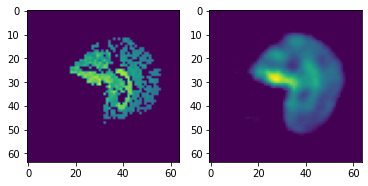

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


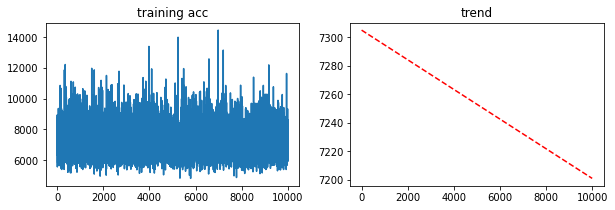

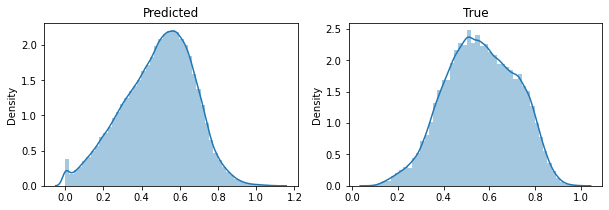

epoch 141/501 | batch 0/212.0 | time 0:12:27.431878 | loss 6188.08984
epoch 141/501 | batch 50/212.0 | time 0:12:28.660396 | loss 6863.66455
epoch 141/501 | batch 100/212.0 | time 0:12:29.777491 | loss 6656.81641
epoch 141/501 | batch 150/212.0 | time 0:12:30.902360 | loss 7478.05127
epoch 141/501 | batch 200/212.0 | time 0:12:32.018500 | loss 7164.7959
epoch 142/501 | batch 0/212.0 | time 0:12:32.297330 | loss 6323.99512
epoch 142/501 | batch 50/212.0 | time 0:12:33.411654 | loss 6868.68066
epoch 142/501 | batch 100/212.0 | time 0:12:34.526632 | loss 4869.12842
epoch 142/501 | batch 150/212.0 | time 0:12:35.640206 | loss 7784.24512
epoch 142/501 | batch 200/212.0 | time 0:12:36.756368 | loss 6688.06055
epoch 143/501 | batch 0/212.0 | time 0:12:37.036075 | loss 7909.74512
epoch 143/501 | batch 50/212.0 | time 0:12:38.150969 | loss 7507.85449
epoch 143/501 | batch 100/212.0 | time 0:12:39.268864 | loss 6333.45215
epoch 143/501 | batch 150/212.0 | time 0:12:40.383777 | loss 8202.32031
ep

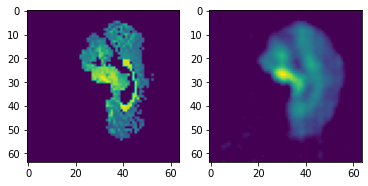

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


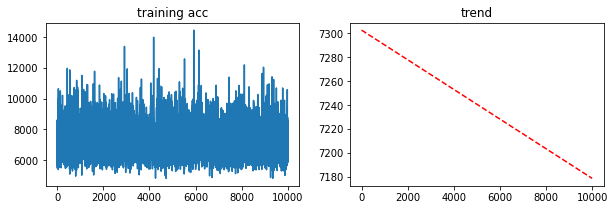

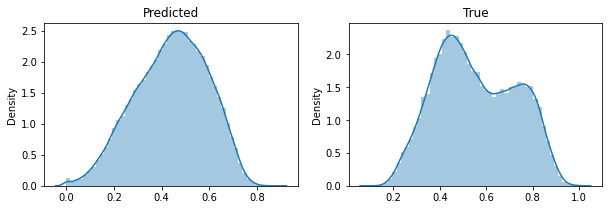

epoch 146/501 | batch 0/212.0 | time 0:12:53.356338 | loss 8667.67969
epoch 146/501 | batch 50/212.0 | time 0:12:54.591288 | loss 6930.73926
epoch 146/501 | batch 100/212.0 | time 0:12:55.708547 | loss 7644.29297
epoch 146/501 | batch 150/212.0 | time 0:12:56.824571 | loss 5809.54395
epoch 146/501 | batch 200/212.0 | time 0:12:57.939169 | loss 6784.98438
epoch 147/501 | batch 0/212.0 | time 0:12:58.219972 | loss 7104.22168
epoch 147/501 | batch 50/212.0 | time 0:12:59.335173 | loss 7314.63818
epoch 147/501 | batch 100/212.0 | time 0:13:00.450657 | loss 8444.4668
epoch 147/501 | batch 150/212.0 | time 0:13:01.573939 | loss 6243.7334
epoch 147/501 | batch 200/212.0 | time 0:13:02.689112 | loss 9161.46289
epoch 148/501 | batch 0/212.0 | time 0:13:02.969373 | loss 7543.21973
epoch 148/501 | batch 50/212.0 | time 0:13:04.091740 | loss 7252.99756
epoch 148/501 | batch 100/212.0 | time 0:13:05.212449 | loss 7623.46826
epoch 148/501 | batch 150/212.0 | time 0:13:06.330641 | loss 6385.02637
epo

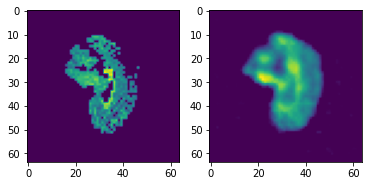

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


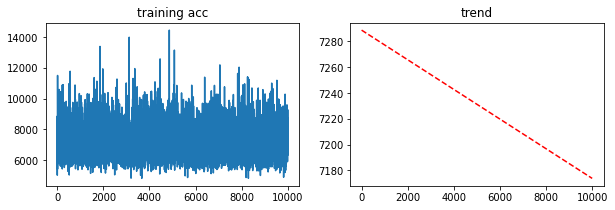

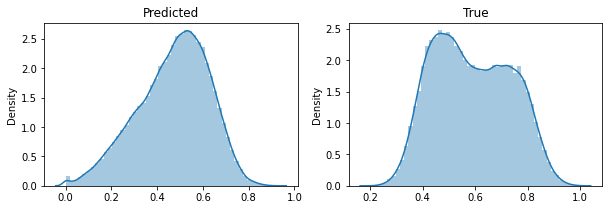

epoch 151/501 | batch 0/212.0 | time 0:13:20.066203 | loss 7608.92969
epoch 151/501 | batch 50/212.0 | time 0:13:21.300180 | loss 7619.85986
epoch 151/501 | batch 100/212.0 | time 0:13:22.424220 | loss 7394.58057
epoch 151/501 | batch 150/212.0 | time 0:13:23.540637 | loss 7411.57227
epoch 151/501 | batch 200/212.0 | time 0:13:24.657928 | loss 6439.94727
epoch 152/501 | batch 0/212.0 | time 0:13:24.937030 | loss 6130.72559
epoch 152/501 | batch 50/212.0 | time 0:13:26.053675 | loss 6096.5752
epoch 152/501 | batch 100/212.0 | time 0:13:27.172702 | loss 7247.30859
epoch 152/501 | batch 150/212.0 | time 0:13:28.292214 | loss 6296.06055
epoch 152/501 | batch 200/212.0 | time 0:13:29.408083 | loss 7453.69336
epoch 153/501 | batch 0/212.0 | time 0:13:29.687551 | loss 6063.03027
epoch 153/501 | batch 50/212.0 | time 0:13:30.804241 | loss 9046.58984
epoch 153/501 | batch 100/212.0 | time 0:13:31.919321 | loss 6344.94385
epoch 153/501 | batch 150/212.0 | time 0:13:33.034798 | loss 7092.01514
ep

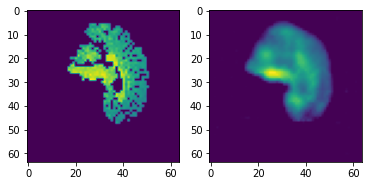

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


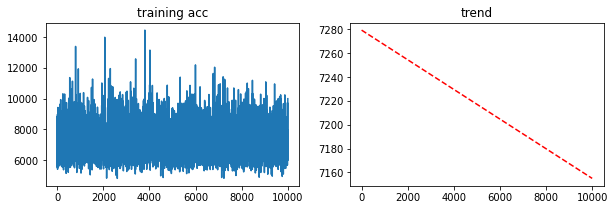

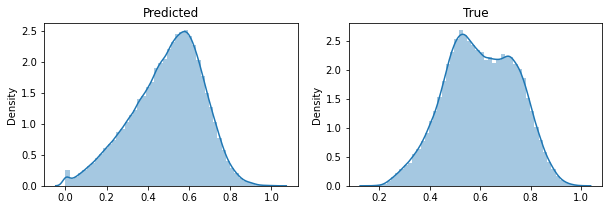

epoch 156/501 | batch 0/212.0 | time 0:13:46.650383 | loss 5508.64258
epoch 156/501 | batch 50/212.0 | time 0:13:47.881350 | loss 7663.30469
epoch 156/501 | batch 100/212.0 | time 0:13:48.996338 | loss 6251.06836
epoch 156/501 | batch 150/212.0 | time 0:13:50.113163 | loss 7037.07959
epoch 156/501 | batch 200/212.0 | time 0:13:51.228189 | loss 7000.40674
epoch 157/501 | batch 0/212.0 | time 0:13:51.508784 | loss 8208.78125
epoch 157/501 | batch 50/212.0 | time 0:13:52.623190 | loss 6416.04395
epoch 157/501 | batch 100/212.0 | time 0:13:53.740328 | loss 6112.94971
epoch 157/501 | batch 150/212.0 | time 0:13:54.855303 | loss 7177.18848
epoch 157/501 | batch 200/212.0 | time 0:13:55.974577 | loss 7307.50781
epoch 158/501 | batch 0/212.0 | time 0:13:56.253845 | loss 7810.34668
epoch 158/501 | batch 50/212.0 | time 0:13:57.376221 | loss 5818.69824
epoch 158/501 | batch 100/212.0 | time 0:13:58.495130 | loss 9912.93066
epoch 158/501 | batch 150/212.0 | time 0:13:59.610072 | loss 7661.2251
ep

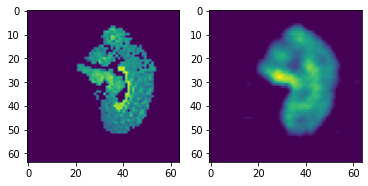

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


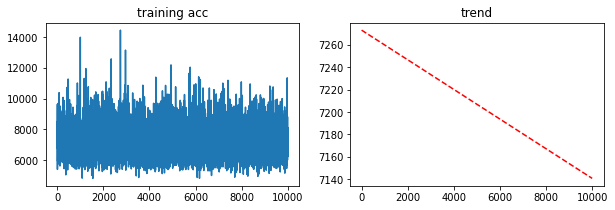

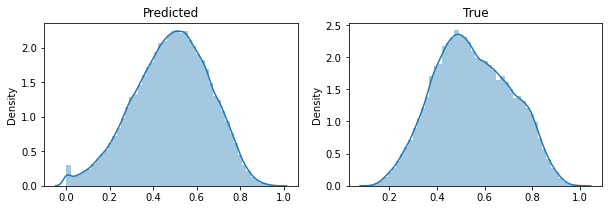

epoch 161/501 | batch 0/212.0 | time 0:14:12.942673 | loss 7031.14258
epoch 161/501 | batch 50/212.0 | time 0:14:14.180928 | loss 6261.25098
epoch 161/501 | batch 100/212.0 | time 0:14:15.296541 | loss 8207.12793
epoch 161/501 | batch 150/212.0 | time 0:14:16.411646 | loss 6326.57617
epoch 161/501 | batch 200/212.0 | time 0:14:17.526005 | loss 7432.65332
epoch 162/501 | batch 0/212.0 | time 0:14:17.806565 | loss 7408.50049
epoch 162/501 | batch 50/212.0 | time 0:14:18.930003 | loss 8721.70996
epoch 162/501 | batch 100/212.0 | time 0:14:20.046223 | loss 8002.41992
epoch 162/501 | batch 150/212.0 | time 0:14:21.162043 | loss 6905.39844
epoch 162/501 | batch 200/212.0 | time 0:14:22.283425 | loss 6700.29443
epoch 163/501 | batch 0/212.0 | time 0:14:22.563291 | loss 6230.46875
epoch 163/501 | batch 50/212.0 | time 0:14:23.679831 | loss 6368.61377
epoch 163/501 | batch 100/212.0 | time 0:14:24.796128 | loss 6150.7876
epoch 163/501 | batch 150/212.0 | time 0:14:25.913546 | loss 8671.1123
epo

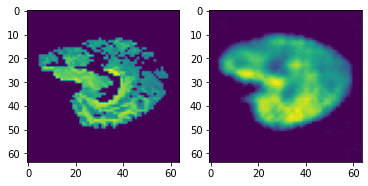

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


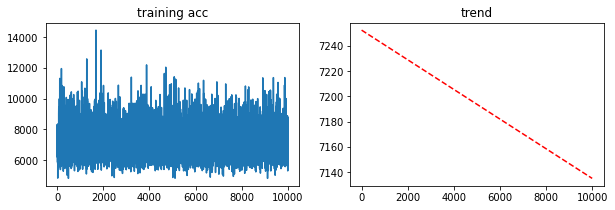

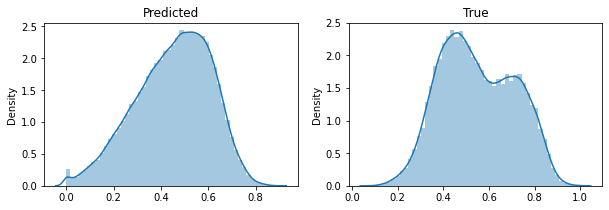

epoch 166/501 | batch 0/212.0 | time 0:14:39.567640 | loss 7865.85742
epoch 166/501 | batch 50/212.0 | time 0:14:40.798274 | loss 8753.94922
epoch 166/501 | batch 100/212.0 | time 0:14:41.913801 | loss 5846.62305
epoch 166/501 | batch 150/212.0 | time 0:14:43.028223 | loss 5888.01953
epoch 166/501 | batch 200/212.0 | time 0:14:44.143396 | loss 8432.26953
epoch 167/501 | batch 0/212.0 | time 0:14:44.421540 | loss 5230.58398
epoch 167/501 | batch 50/212.0 | time 0:14:45.537381 | loss 8300.8418
epoch 167/501 | batch 100/212.0 | time 0:14:46.651907 | loss 6667.17139
epoch 167/501 | batch 150/212.0 | time 0:14:47.773968 | loss 7118.84277
epoch 167/501 | batch 200/212.0 | time 0:14:48.888197 | loss 8206.21875
epoch 168/501 | batch 0/212.0 | time 0:14:49.167268 | loss 5071.37305
epoch 168/501 | batch 50/212.0 | time 0:14:50.289544 | loss 6301.4668
epoch 168/501 | batch 100/212.0 | time 0:14:51.406512 | loss 7361.8418
epoch 168/501 | batch 150/212.0 | time 0:14:52.524635 | loss 9809.74414
epoc

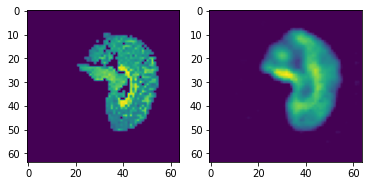

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


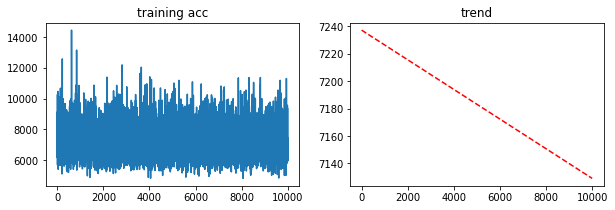

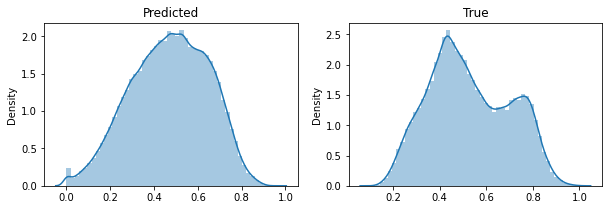

epoch 171/501 | batch 0/212.0 | time 0:15:06.014496 | loss 9291.83789
epoch 171/501 | batch 50/212.0 | time 0:15:07.230695 | loss 6453.68848
epoch 171/501 | batch 100/212.0 | time 0:15:08.346593 | loss 7762.18848
epoch 171/501 | batch 150/212.0 | time 0:15:09.461621 | loss 5959.24316
epoch 171/501 | batch 200/212.0 | time 0:15:10.577119 | loss 8134.30762
epoch 172/501 | batch 0/212.0 | time 0:15:10.856639 | loss 6920.96045
epoch 172/501 | batch 50/212.0 | time 0:15:11.970982 | loss 6886.09131
epoch 172/501 | batch 100/212.0 | time 0:15:13.084632 | loss 7416.29248
epoch 172/501 | batch 150/212.0 | time 0:15:14.199965 | loss 6089.23438
epoch 172/501 | batch 200/212.0 | time 0:15:15.314371 | loss 6097.43115
epoch 173/501 | batch 0/212.0 | time 0:15:15.593997 | loss 7511.12891
epoch 173/501 | batch 50/212.0 | time 0:15:16.709011 | loss 8207.87695
epoch 173/501 | batch 100/212.0 | time 0:15:17.823143 | loss 6021.43457
epoch 173/501 | batch 150/212.0 | time 0:15:18.942083 | loss 6157.26416
e

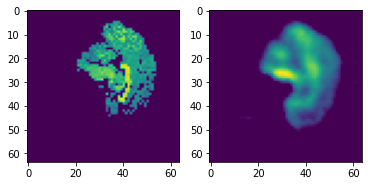

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


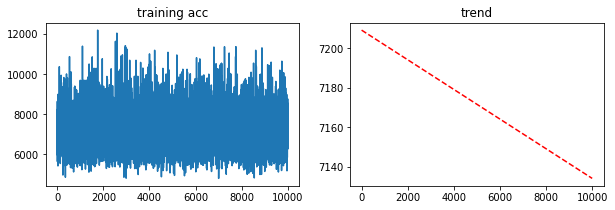

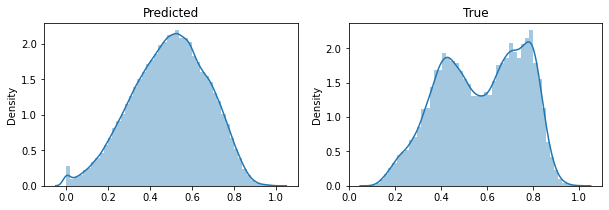

epoch 176/501 | batch 0/212.0 | time 0:15:32.517660 | loss 6312.20361
epoch 176/501 | batch 50/212.0 | time 0:15:33.731564 | loss 6592.89795
epoch 176/501 | batch 100/212.0 | time 0:15:34.849374 | loss 7516.45312
epoch 176/501 | batch 150/212.0 | time 0:15:35.963013 | loss 6690.64844
epoch 176/501 | batch 200/212.0 | time 0:15:37.086280 | loss 5966.35059
epoch 177/501 | batch 0/212.0 | time 0:15:37.369115 | loss 5076.24902
epoch 177/501 | batch 50/212.0 | time 0:15:38.485894 | loss 6925.48828
epoch 177/501 | batch 100/212.0 | time 0:15:39.601488 | loss 8010.38037
epoch 177/501 | batch 150/212.0 | time 0:15:40.718392 | loss 7233.31104
epoch 177/501 | batch 200/212.0 | time 0:15:41.833836 | loss 7314.90918
epoch 178/501 | batch 0/212.0 | time 0:15:42.113940 | loss 7200.54395
epoch 178/501 | batch 50/212.0 | time 0:15:43.230349 | loss 7860.66455
epoch 178/501 | batch 100/212.0 | time 0:15:44.347677 | loss 7105.94824
epoch 178/501 | batch 150/212.0 | time 0:15:45.465244 | loss 5863.01562
e

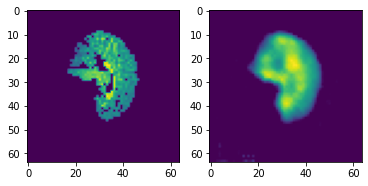

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


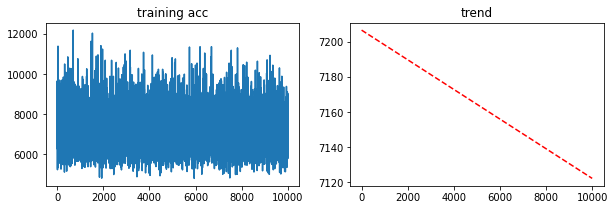

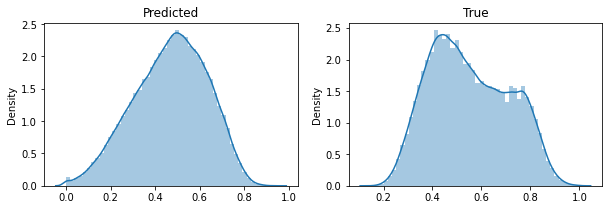

epoch 181/501 | batch 0/212.0 | time 0:15:58.952113 | loss 7425.24463
epoch 181/501 | batch 50/212.0 | time 0:16:00.198851 | loss 8304.38965
epoch 181/501 | batch 100/212.0 | time 0:16:01.314617 | loss 6841.27441
epoch 181/501 | batch 150/212.0 | time 0:16:02.434503 | loss 9512.01172
epoch 181/501 | batch 200/212.0 | time 0:16:03.551547 | loss 6779.2583
epoch 182/501 | batch 0/212.0 | time 0:16:03.831267 | loss 6066.70996
epoch 182/501 | batch 50/212.0 | time 0:16:04.946718 | loss 8944.98438
epoch 182/501 | batch 100/212.0 | time 0:16:06.063236 | loss 6291.19678
epoch 182/501 | batch 150/212.0 | time 0:16:07.178287 | loss 6556.26172
epoch 182/501 | batch 200/212.0 | time 0:16:08.298674 | loss 5905.15527
epoch 183/501 | batch 0/212.0 | time 0:16:08.579325 | loss 7155.69092
epoch 183/501 | batch 50/212.0 | time 0:16:09.694472 | loss 7752.93213
epoch 183/501 | batch 100/212.0 | time 0:16:10.809591 | loss 6960.15625
epoch 183/501 | batch 150/212.0 | time 0:16:11.924421 | loss 7128.35205
ep

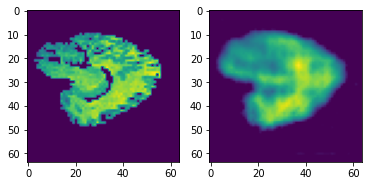

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


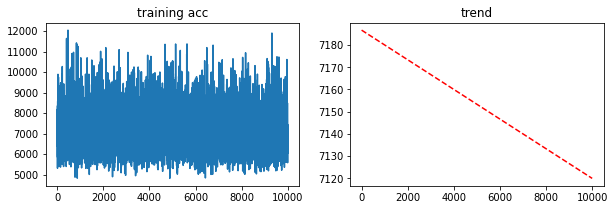

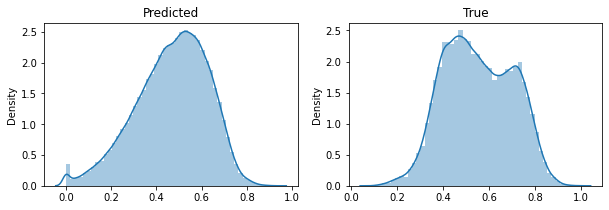

epoch 186/501 | batch 0/212.0 | time 0:16:25.454596 | loss 7609.08398
epoch 186/501 | batch 50/212.0 | time 0:16:26.704144 | loss 6477.22656
epoch 186/501 | batch 100/212.0 | time 0:16:27.822477 | loss 5997.55713
epoch 186/501 | batch 150/212.0 | time 0:16:28.937044 | loss 7834.78369
epoch 186/501 | batch 200/212.0 | time 0:16:30.057269 | loss 7612.68359
epoch 187/501 | batch 0/212.0 | time 0:16:30.338149 | loss 7757.21973
epoch 187/501 | batch 50/212.0 | time 0:16:31.459570 | loss 6976.42529
epoch 187/501 | batch 100/212.0 | time 0:16:32.575867 | loss 7068.06104
epoch 187/501 | batch 150/212.0 | time 0:16:33.689716 | loss 10075.51855
epoch 187/501 | batch 200/212.0 | time 0:16:34.803815 | loss 8512.00293
epoch 188/501 | batch 0/212.0 | time 0:16:35.083743 | loss 6165.79297
epoch 188/501 | batch 50/212.0 | time 0:16:36.200798 | loss 6418.08936
epoch 188/501 | batch 100/212.0 | time 0:16:37.314700 | loss 6319.81787
epoch 188/501 | batch 150/212.0 | time 0:16:38.430391 | loss 8259.11133


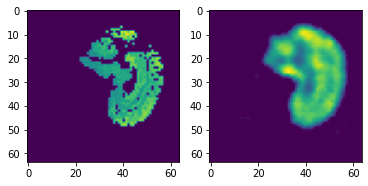

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


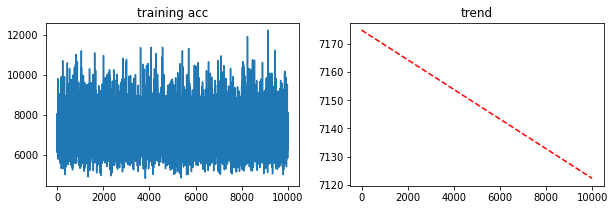

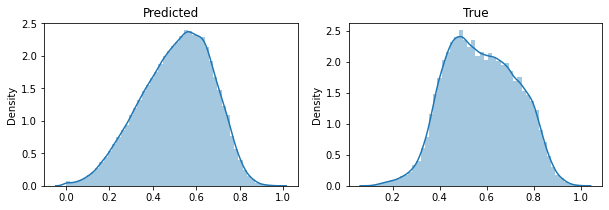

epoch 191/501 | batch 0/212.0 | time 0:16:51.766923 | loss 7683.22266
epoch 191/501 | batch 50/212.0 | time 0:16:53.016658 | loss 7076.4043
epoch 191/501 | batch 100/212.0 | time 0:16:54.130718 | loss 7151.70996
epoch 191/501 | batch 150/212.0 | time 0:16:55.244290 | loss 7228.75537
epoch 191/501 | batch 200/212.0 | time 0:16:56.357465 | loss 6865.83691
epoch 192/501 | batch 0/212.0 | time 0:16:56.638161 | loss 7661.4668
epoch 192/501 | batch 50/212.0 | time 0:16:57.753587 | loss 7113.56592
epoch 192/501 | batch 100/212.0 | time 0:16:58.867872 | loss 6512.02832
epoch 192/501 | batch 150/212.0 | time 0:16:59.981697 | loss 8271.99219
epoch 192/501 | batch 200/212.0 | time 0:17:01.097210 | loss 6065.25439
epoch 193/501 | batch 0/212.0 | time 0:17:01.375843 | loss 6363.78613
epoch 193/501 | batch 50/212.0 | time 0:17:02.490362 | loss 8053.79395
epoch 193/501 | batch 100/212.0 | time 0:17:03.607904 | loss 8386.71484
epoch 193/501 | batch 150/212.0 | time 0:17:04.722347 | loss 7239.40918
epo

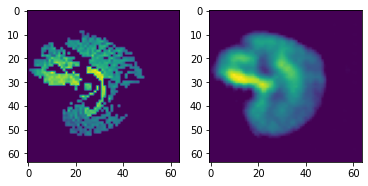

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


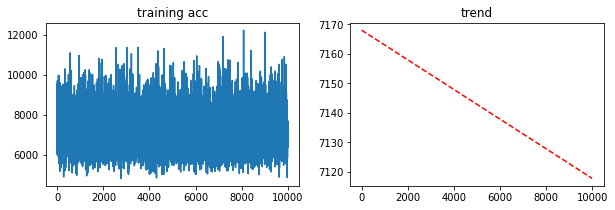

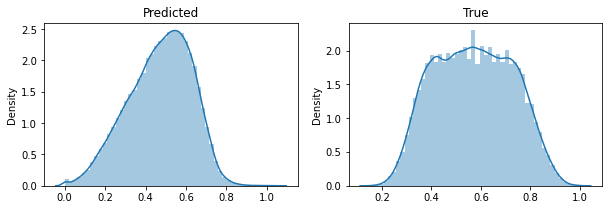

epoch 196/501 | batch 0/212.0 | time 0:17:17.852083 | loss 6628.35352
epoch 196/501 | batch 50/212.0 | time 0:17:19.107236 | loss 6109.40918
epoch 196/501 | batch 100/212.0 | time 0:17:20.222599 | loss 6642.04248
epoch 196/501 | batch 150/212.0 | time 0:17:21.335852 | loss 7600.79785
epoch 196/501 | batch 200/212.0 | time 0:17:22.453731 | loss 7552.04395
epoch 197/501 | batch 0/212.0 | time 0:17:22.733724 | loss 7292.06641
epoch 197/501 | batch 50/212.0 | time 0:17:23.851829 | loss 7796.51807
epoch 197/501 | batch 100/212.0 | time 0:17:24.977361 | loss 7758.37109
epoch 197/501 | batch 150/212.0 | time 0:17:26.097040 | loss 6226.20898
epoch 197/501 | batch 200/212.0 | time 0:17:27.210934 | loss 5293.25781
epoch 198/501 | batch 0/212.0 | time 0:17:27.492367 | loss 8968.67773
epoch 198/501 | batch 50/212.0 | time 0:17:28.617634 | loss 5799.35156
epoch 198/501 | batch 100/212.0 | time 0:17:29.734403 | loss 6518.70068
epoch 198/501 | batch 150/212.0 | time 0:17:30.851156 | loss 7529.59668
e

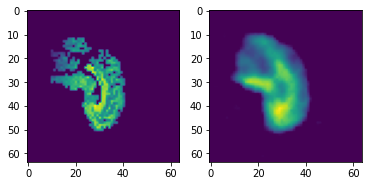

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


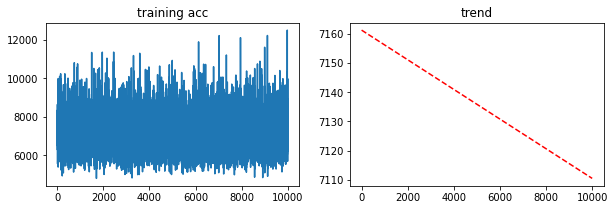

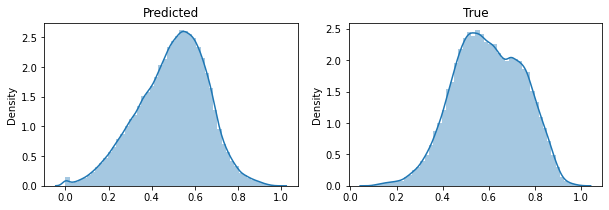

epoch 201/501 | batch 0/212.0 | time 0:17:44.298614 | loss 7806.04004
epoch 201/501 | batch 50/212.0 | time 0:17:45.523816 | loss 6658.02588
epoch 201/501 | batch 100/212.0 | time 0:17:46.639263 | loss 6989.80029
epoch 201/501 | batch 150/212.0 | time 0:17:47.757467 | loss 6554.95508
epoch 201/501 | batch 200/212.0 | time 0:17:48.871052 | loss 6412.09473
epoch 202/501 | batch 0/212.0 | time 0:17:49.151000 | loss 7166.64746
epoch 202/501 | batch 50/212.0 | time 0:17:50.264601 | loss 7124.50684
epoch 202/501 | batch 100/212.0 | time 0:17:51.378592 | loss 7477.84229
epoch 202/501 | batch 150/212.0 | time 0:17:52.496981 | loss 5782.91016
epoch 202/501 | batch 200/212.0 | time 0:17:53.611300 | loss 7024.08008
epoch 203/501 | batch 0/212.0 | time 0:17:53.890632 | loss 7112.43262
epoch 203/501 | batch 50/212.0 | time 0:17:55.003851 | loss 7932.29395
epoch 203/501 | batch 100/212.0 | time 0:17:56.119636 | loss 5982.05713
epoch 203/501 | batch 150/212.0 | time 0:17:57.242656 | loss 7742.70117
e

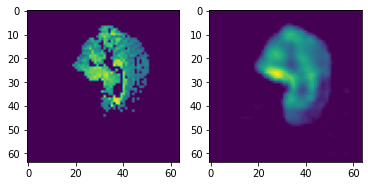

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


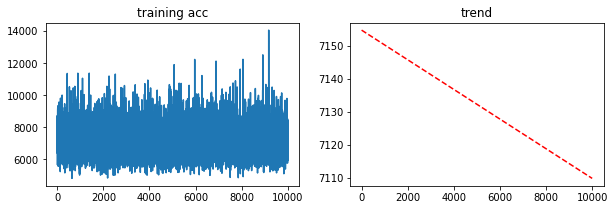

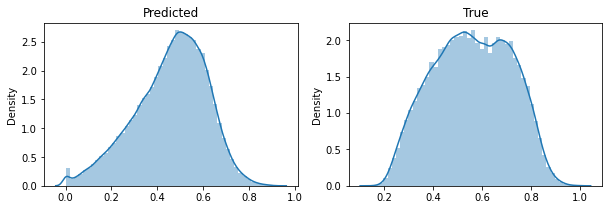

epoch 206/501 | batch 0/212.0 | time 0:18:10.842234 | loss 7661.88574
epoch 206/501 | batch 50/212.0 | time 0:18:12.077917 | loss 5421.7207
epoch 206/501 | batch 100/212.0 | time 0:18:13.195218 | loss 7046.0791
epoch 206/501 | batch 150/212.0 | time 0:18:14.310615 | loss 6491.24658
epoch 206/501 | batch 200/212.0 | time 0:18:15.426245 | loss 7491.46436
epoch 207/501 | batch 0/212.0 | time 0:18:15.707865 | loss 6721.64453
epoch 207/501 | batch 50/212.0 | time 0:18:16.834478 | loss 7910.59082
epoch 207/501 | batch 100/212.0 | time 0:18:17.955824 | loss 6693.48535
epoch 207/501 | batch 150/212.0 | time 0:18:19.070246 | loss 6427.60742
epoch 207/501 | batch 200/212.0 | time 0:18:20.184549 | loss 6229.07129
epoch 208/501 | batch 0/212.0 | time 0:18:20.464025 | loss 6880.31738
epoch 208/501 | batch 50/212.0 | time 0:18:21.588317 | loss 6747.12988
epoch 208/501 | batch 100/212.0 | time 0:18:22.704664 | loss 7268.85303
epoch 208/501 | batch 150/212.0 | time 0:18:23.824589 | loss 8087.13232
epo

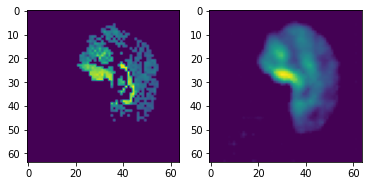

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


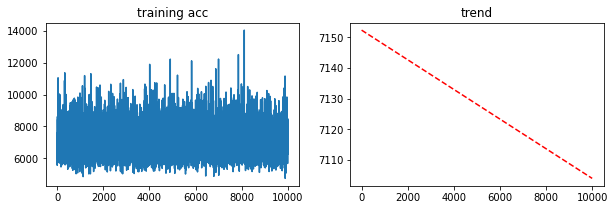

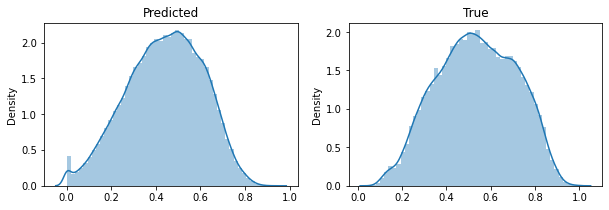

epoch 211/501 | batch 0/212.0 | time 0:18:36.848316 | loss 6935.56543
epoch 211/501 | batch 50/212.0 | time 0:18:38.066740 | loss 9338.13086
epoch 211/501 | batch 100/212.0 | time 0:18:39.182224 | loss 8102.64941
epoch 211/501 | batch 150/212.0 | time 0:18:40.297842 | loss 6606.6416
epoch 211/501 | batch 200/212.0 | time 0:18:41.412968 | loss 6518.89062
epoch 212/501 | batch 0/212.0 | time 0:18:41.693193 | loss 6236.5542
epoch 212/501 | batch 50/212.0 | time 0:18:42.820751 | loss 7097.09521
epoch 212/501 | batch 100/212.0 | time 0:18:43.937735 | loss 7399.69629
epoch 212/501 | batch 150/212.0 | time 0:18:45.053654 | loss 7179.55957
epoch 212/501 | batch 200/212.0 | time 0:18:46.170406 | loss 6993.42188
epoch 213/501 | batch 0/212.0 | time 0:18:46.450131 | loss 8067.28223
epoch 213/501 | batch 50/212.0 | time 0:18:47.568959 | loss 6820.54883
epoch 213/501 | batch 100/212.0 | time 0:18:48.684570 | loss 5941.58398
epoch 213/501 | batch 150/212.0 | time 0:18:49.802118 | loss 7732.09766
epo

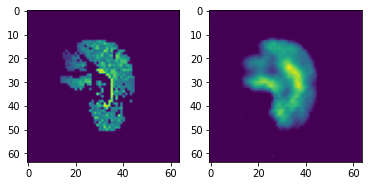

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


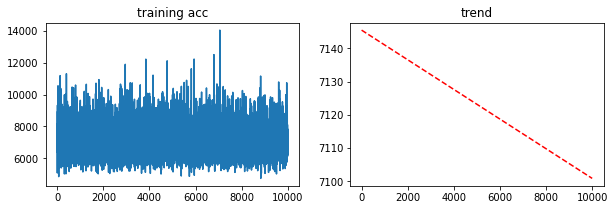

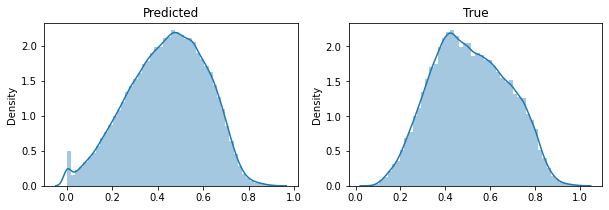

epoch 216/501 | batch 0/212.0 | time 0:19:03.175574 | loss 7389.56934
epoch 216/501 | batch 50/212.0 | time 0:19:04.389193 | loss 7655.38281
epoch 216/501 | batch 100/212.0 | time 0:19:05.509868 | loss 7743.00537
epoch 216/501 | batch 150/212.0 | time 0:19:06.625215 | loss 6634.46484
epoch 216/501 | batch 200/212.0 | time 0:19:07.743999 | loss 6090.42578
epoch 217/501 | batch 0/212.0 | time 0:19:08.023146 | loss 7445.7583
epoch 217/501 | batch 50/212.0 | time 0:19:09.141745 | loss 7290.9668
epoch 217/501 | batch 100/212.0 | time 0:19:10.256233 | loss 6384.93457
epoch 217/501 | batch 150/212.0 | time 0:19:11.370222 | loss 7536.40332
epoch 217/501 | batch 200/212.0 | time 0:19:12.485451 | loss 6775.57373
epoch 218/501 | batch 0/212.0 | time 0:19:12.765871 | loss 5629.59766
epoch 218/501 | batch 50/212.0 | time 0:19:13.881326 | loss 8029.85742
epoch 218/501 | batch 100/212.0 | time 0:19:14.999238 | loss 8640.17969
epoch 218/501 | batch 150/212.0 | time 0:19:16.119035 | loss 6724.25195
epo

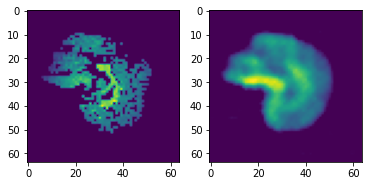

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


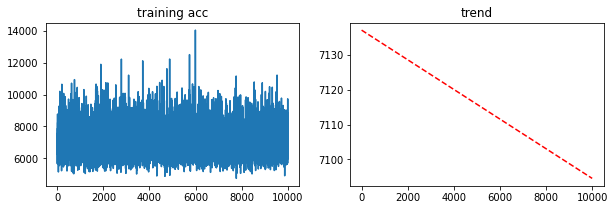

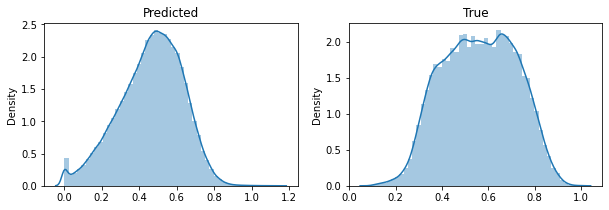

epoch 221/501 | batch 0/212.0 | time 0:19:30.006164 | loss 7715.125
epoch 221/501 | batch 50/212.0 | time 0:19:31.254427 | loss 7004.66113
epoch 221/501 | batch 100/212.0 | time 0:19:32.368097 | loss 8356.7793
epoch 221/501 | batch 150/212.0 | time 0:19:33.484852 | loss 7619.07324
epoch 221/501 | batch 200/212.0 | time 0:19:34.599782 | loss 7021.74609
epoch 222/501 | batch 0/212.0 | time 0:19:34.880167 | loss 8036.54492
epoch 222/501 | batch 50/212.0 | time 0:19:35.996524 | loss 7429.42578
epoch 222/501 | batch 100/212.0 | time 0:19:37.111323 | loss 7247.51855
epoch 222/501 | batch 150/212.0 | time 0:19:38.227378 | loss 5932.1377
epoch 222/501 | batch 200/212.0 | time 0:19:39.348004 | loss 6764.91064
epoch 223/501 | batch 0/212.0 | time 0:19:39.629098 | loss 6276.16455
epoch 223/501 | batch 50/212.0 | time 0:19:40.743834 | loss 6725.59375
epoch 223/501 | batch 100/212.0 | time 0:19:41.859297 | loss 6673.56396
epoch 223/501 | batch 150/212.0 | time 0:19:42.975298 | loss 7335.59375
epoch

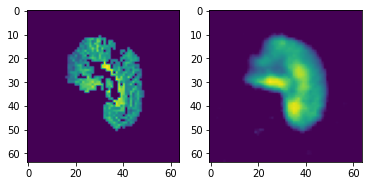

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


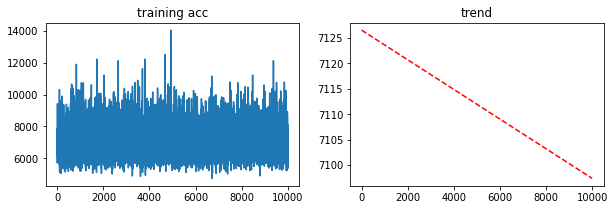

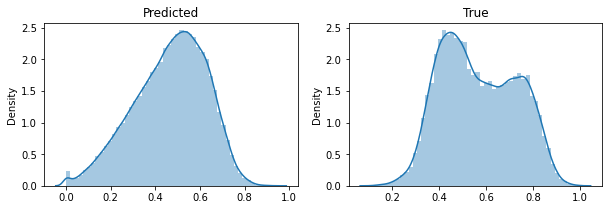

epoch 226/501 | batch 0/212.0 | time 0:19:56.117621 | loss 7275.01465
epoch 226/501 | batch 50/212.0 | time 0:19:57.363613 | loss 6532.80469
epoch 226/501 | batch 100/212.0 | time 0:19:58.478715 | loss 7703.72852
epoch 226/501 | batch 150/212.0 | time 0:19:59.594769 | loss 6542.29004
epoch 226/501 | batch 200/212.0 | time 0:20:00.710193 | loss 7153.25244
epoch 227/501 | batch 0/212.0 | time 0:20:00.989406 | loss 6439.84668
epoch 227/501 | batch 50/212.0 | time 0:20:02.105903 | loss 6365.42676
epoch 227/501 | batch 100/212.0 | time 0:20:03.221270 | loss 8930.60938
epoch 227/501 | batch 150/212.0 | time 0:20:04.338877 | loss 7671.41211
epoch 227/501 | batch 200/212.0 | time 0:20:05.455863 | loss 8103.35498
epoch 228/501 | batch 0/212.0 | time 0:20:05.734823 | loss 6718.12891
epoch 228/501 | batch 50/212.0 | time 0:20:06.849549 | loss 7687.51074
epoch 228/501 | batch 100/212.0 | time 0:20:07.966830 | loss 6605.59912
epoch 228/501 | batch 150/212.0 | time 0:20:09.080622 | loss 7756.30176
e

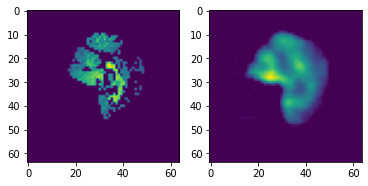

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


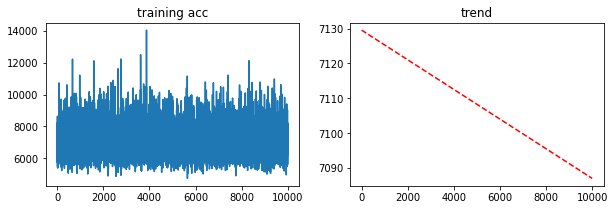

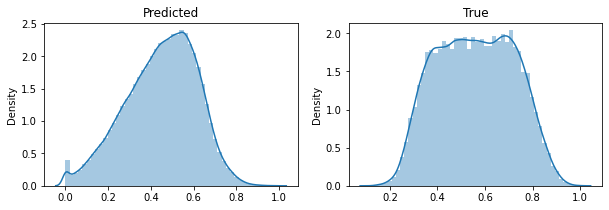

epoch 231/501 | batch 0/212.0 | time 0:20:22.774218 | loss 7677.21387
epoch 231/501 | batch 50/212.0 | time 0:20:24.009897 | loss 6662.24756
epoch 231/501 | batch 100/212.0 | time 0:20:25.124437 | loss 5693.65723
epoch 231/501 | batch 150/212.0 | time 0:20:26.239602 | loss 7072.45703
epoch 231/501 | batch 200/212.0 | time 0:20:27.357656 | loss 6897.32031
epoch 232/501 | batch 0/212.0 | time 0:20:27.636562 | loss 7219.78027
epoch 232/501 | batch 50/212.0 | time 0:20:28.751969 | loss 6476.96631
epoch 232/501 | batch 100/212.0 | time 0:20:29.866303 | loss 6656.42871
epoch 232/501 | batch 150/212.0 | time 0:20:30.980432 | loss 6166.61865
epoch 232/501 | batch 200/212.0 | time 0:20:32.096677 | loss 6489.93848
epoch 233/501 | batch 0/212.0 | time 0:20:32.375584 | loss 7902.68896
epoch 233/501 | batch 50/212.0 | time 0:20:33.490649 | loss 5944.01172
epoch 233/501 | batch 100/212.0 | time 0:20:34.614359 | loss 6586.44775
epoch 233/501 | batch 150/212.0 | time 0:20:35.728929 | loss 6640.27637
e

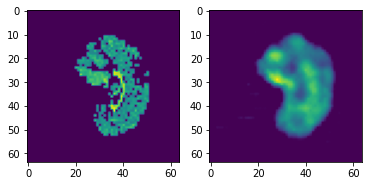

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


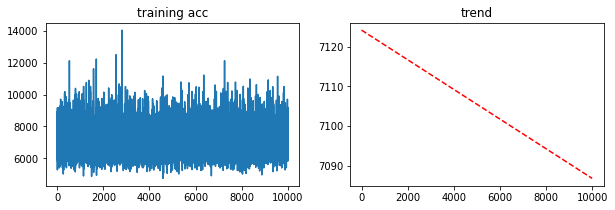

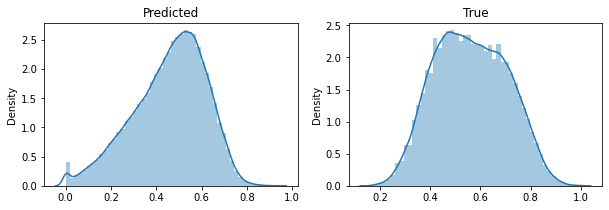

epoch 236/501 | batch 0/212.0 | time 0:20:49.438267 | loss 7163.7627
epoch 236/501 | batch 50/212.0 | time 0:20:50.659680 | loss 7995.10107
epoch 236/501 | batch 100/212.0 | time 0:20:51.775379 | loss 7860.70605
epoch 236/501 | batch 150/212.0 | time 0:20:52.892715 | loss 6081.38037
epoch 236/501 | batch 200/212.0 | time 0:20:54.007572 | loss 6624.63818
epoch 237/501 | batch 0/212.0 | time 0:20:54.287525 | loss 7124.16504
epoch 237/501 | batch 50/212.0 | time 0:20:55.404229 | loss 6262.54688
epoch 237/501 | batch 100/212.0 | time 0:20:56.520044 | loss 8061.60059
epoch 237/501 | batch 150/212.0 | time 0:20:57.634983 | loss 7624.80273
epoch 237/501 | batch 200/212.0 | time 0:20:58.761266 | loss 6295.73486
epoch 238/501 | batch 0/212.0 | time 0:20:59.040730 | loss 5954.57666
epoch 238/501 | batch 50/212.0 | time 0:21:00.157830 | loss 5949.56152
epoch 238/501 | batch 100/212.0 | time 0:21:01.274386 | loss 7455.12988
epoch 238/501 | batch 150/212.0 | time 0:21:02.392213 | loss 6765.13916
ep

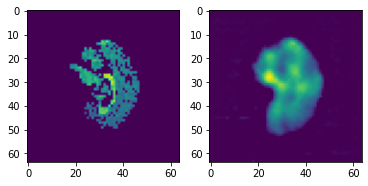

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


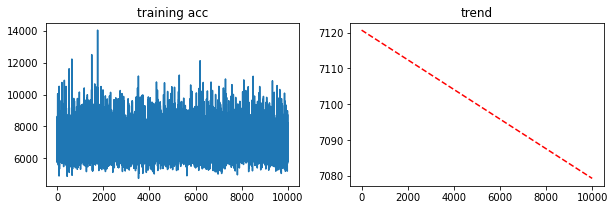

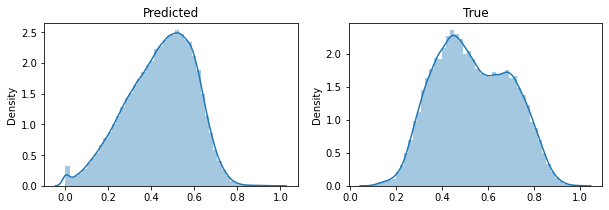

epoch 241/501 | batch 0/212.0 | time 0:21:15.667557 | loss 7076.18896
epoch 241/501 | batch 50/212.0 | time 0:21:16.895046 | loss 6477.50781
epoch 241/501 | batch 100/212.0 | time 0:21:18.015792 | loss 7334.11914
epoch 241/501 | batch 150/212.0 | time 0:21:19.130882 | loss 6532.38965
epoch 241/501 | batch 200/212.0 | time 0:21:20.243987 | loss 6242.05176
epoch 242/501 | batch 0/212.0 | time 0:21:20.522493 | loss 7667.92627
epoch 242/501 | batch 50/212.0 | time 0:21:21.638106 | loss 8025.43506
epoch 242/501 | batch 100/212.0 | time 0:21:22.752940 | loss 8500.49121
epoch 242/501 | batch 150/212.0 | time 0:21:23.872305 | loss 7720.021
epoch 242/501 | batch 200/212.0 | time 0:21:24.987265 | loss 9387.77246
epoch 243/501 | batch 0/212.0 | time 0:21:25.267308 | loss 6949.30029
epoch 243/501 | batch 50/212.0 | time 0:21:26.380892 | loss 6684.84766
epoch 243/501 | batch 100/212.0 | time 0:21:27.499066 | loss 6427.63135
epoch 243/501 | batch 150/212.0 | time 0:21:28.614525 | loss 6823.2334
epoc

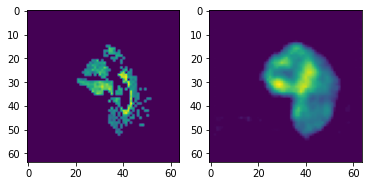

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


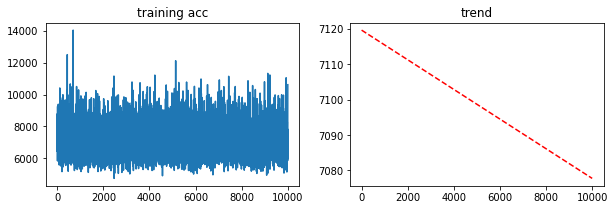

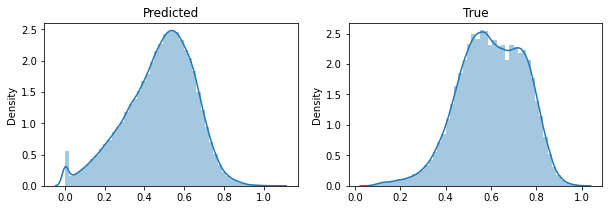

epoch 246/501 | batch 0/212.0 | time 0:21:42.342633 | loss 7218.88672
epoch 246/501 | batch 50/212.0 | time 0:21:43.586606 | loss 6740.45508
epoch 246/501 | batch 100/212.0 | time 0:21:44.703365 | loss 7035.15723
epoch 246/501 | batch 150/212.0 | time 0:21:45.817631 | loss 6913.68945
epoch 246/501 | batch 200/212.0 | time 0:21:46.935975 | loss 7308.61133
epoch 247/501 | batch 0/212.0 | time 0:21:47.217970 | loss 7746.18408
epoch 247/501 | batch 50/212.0 | time 0:21:48.335509 | loss 6023.08203
epoch 247/501 | batch 100/212.0 | time 0:21:49.448753 | loss 6778.97363
epoch 247/501 | batch 150/212.0 | time 0:21:50.562248 | loss 7019.38965
epoch 247/501 | batch 200/212.0 | time 0:21:51.677459 | loss 5704.24414
epoch 248/501 | batch 0/212.0 | time 0:21:51.958433 | loss 6814.90869
epoch 248/501 | batch 50/212.0 | time 0:21:53.073764 | loss 6656.90283
epoch 248/501 | batch 100/212.0 | time 0:21:54.189158 | loss 5203.47656
epoch 248/501 | batch 150/212.0 | time 0:21:55.306128 | loss 6118.99902
e

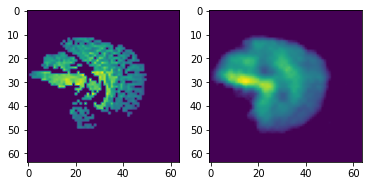

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


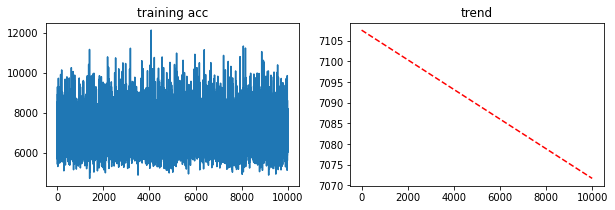

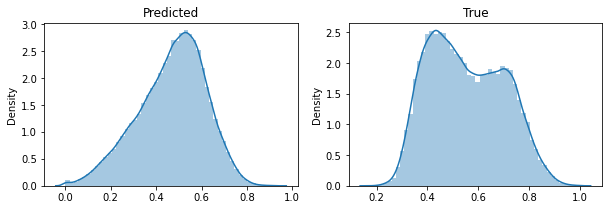

epoch 251/501 | batch 0/212.0 | time 0:22:08.691140 | loss 6651.97412
epoch 251/501 | batch 50/212.0 | time 0:22:09.907910 | loss 7193.86133
epoch 251/501 | batch 100/212.0 | time 0:22:11.026252 | loss 6099.58496
epoch 251/501 | batch 150/212.0 | time 0:22:12.144854 | loss 5970.41699
epoch 251/501 | batch 200/212.0 | time 0:22:13.261175 | loss 7388.71191
epoch 252/501 | batch 0/212.0 | time 0:22:13.539614 | loss 8046.4209
epoch 252/501 | batch 50/212.0 | time 0:22:14.656825 | loss 7967.50928
epoch 252/501 | batch 100/212.0 | time 0:22:15.778263 | loss 5806.52979
epoch 252/501 | batch 150/212.0 | time 0:22:16.895253 | loss 8046.81152
epoch 252/501 | batch 200/212.0 | time 0:22:18.011081 | loss 7341.33838
epoch 253/501 | batch 0/212.0 | time 0:22:18.291255 | loss 6238.23535
epoch 253/501 | batch 50/212.0 | time 0:22:19.408165 | loss 7020.24365
epoch 253/501 | batch 100/212.0 | time 0:22:20.530532 | loss 7330.86719
epoch 253/501 | batch 150/212.0 | time 0:22:21.646477 | loss 9444.20117
ep

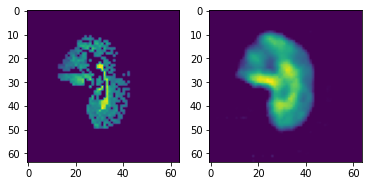

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


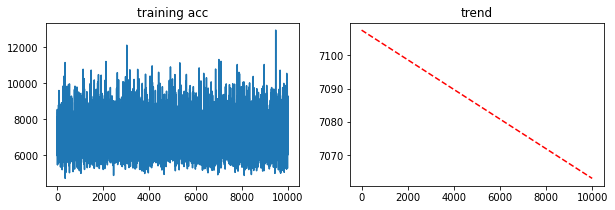

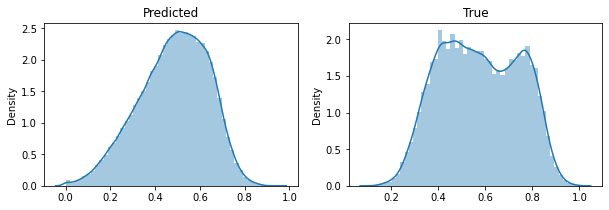

epoch 256/501 | batch 0/212.0 | time 0:22:35.025489 | loss 6661.29004
epoch 256/501 | batch 50/212.0 | time 0:22:36.238691 | loss 6532.25879
epoch 256/501 | batch 100/212.0 | time 0:22:37.354693 | loss 5474.74219
epoch 256/501 | batch 150/212.0 | time 0:22:38.472492 | loss 6028.45947
epoch 256/501 | batch 200/212.0 | time 0:22:39.588130 | loss 8080.90918
epoch 257/501 | batch 0/212.0 | time 0:22:39.868271 | loss 7529.73926
epoch 257/501 | batch 50/212.0 | time 0:22:40.984387 | loss 6800.57617
epoch 257/501 | batch 100/212.0 | time 0:22:42.099418 | loss 7059.55664
epoch 257/501 | batch 150/212.0 | time 0:22:43.215115 | loss 7886.67236
epoch 257/501 | batch 200/212.0 | time 0:22:44.329194 | loss 7436.49219
epoch 258/501 | batch 0/212.0 | time 0:22:44.608622 | loss 8187.92773
epoch 258/501 | batch 50/212.0 | time 0:22:45.725549 | loss 6181.58594
epoch 258/501 | batch 100/212.0 | time 0:22:46.843781 | loss 6392.44971
epoch 258/501 | batch 150/212.0 | time 0:22:47.967476 | loss 6894.85254
e

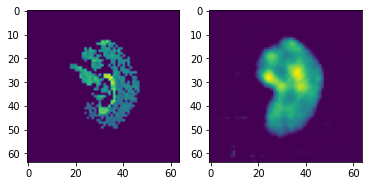

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


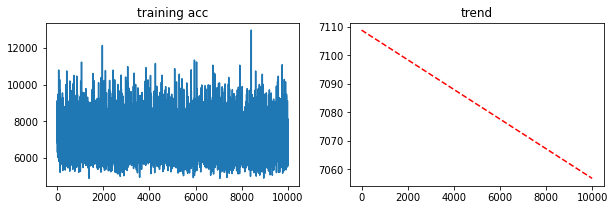

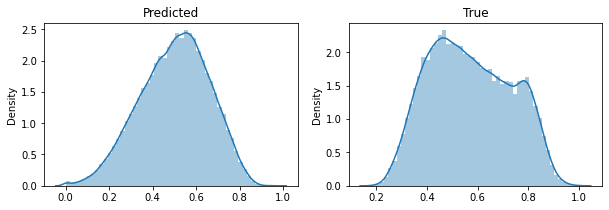

epoch 261/501 | batch 0/212.0 | time 0:23:01.416702 | loss 7143.53613
epoch 261/501 | batch 50/212.0 | time 0:23:02.654222 | loss 7387.04785
epoch 261/501 | batch 100/212.0 | time 0:23:03.771886 | loss 6605.39697
epoch 261/501 | batch 150/212.0 | time 0:23:04.887299 | loss 6516.59863
epoch 261/501 | batch 200/212.0 | time 0:23:06.002904 | loss 6721.33203
epoch 262/501 | batch 0/212.0 | time 0:23:06.283251 | loss 8275.13281
epoch 262/501 | batch 50/212.0 | time 0:23:07.406418 | loss 7112.77637
epoch 262/501 | batch 100/212.0 | time 0:23:08.526472 | loss 7320.37402
epoch 262/501 | batch 150/212.0 | time 0:23:09.641897 | loss 6749.71777
epoch 262/501 | batch 200/212.0 | time 0:23:10.756163 | loss 6331.7251
epoch 263/501 | batch 0/212.0 | time 0:23:11.034799 | loss 7695.51953
epoch 263/501 | batch 50/212.0 | time 0:23:12.153331 | loss 6653.31201
epoch 263/501 | batch 100/212.0 | time 0:23:13.270624 | loss 6869.44531
epoch 263/501 | batch 150/212.0 | time 0:23:14.386951 | loss 7366.01611
ep

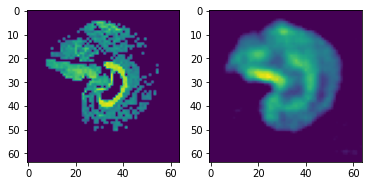

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


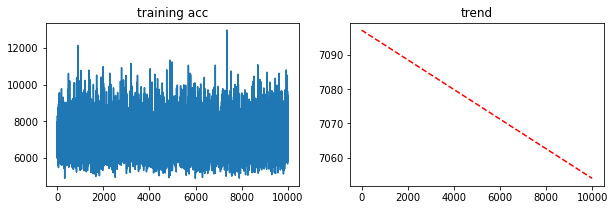

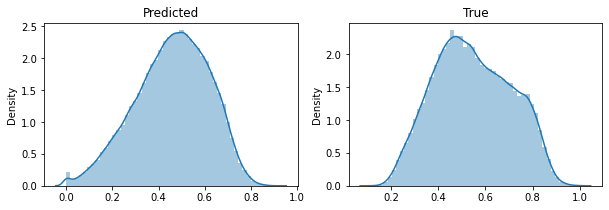

epoch 266/501 | batch 0/212.0 | time 0:23:27.852140 | loss 7123.37305
epoch 266/501 | batch 50/212.0 | time 0:23:29.067008 | loss 7299.77637
epoch 266/501 | batch 100/212.0 | time 0:23:30.186601 | loss 7969.56055
epoch 266/501 | batch 150/212.0 | time 0:23:31.301270 | loss 5685.60742
epoch 266/501 | batch 200/212.0 | time 0:23:32.415948 | loss 7192.10938
epoch 267/501 | batch 0/212.0 | time 0:23:32.695608 | loss 6714.77588
epoch 267/501 | batch 50/212.0 | time 0:23:33.816123 | loss 7522.1748
epoch 267/501 | batch 100/212.0 | time 0:23:34.938102 | loss 7477.87305
epoch 267/501 | batch 150/212.0 | time 0:23:36.051452 | loss 7589.26758
epoch 267/501 | batch 200/212.0 | time 0:23:37.166153 | loss 7627.69922
epoch 268/501 | batch 0/212.0 | time 0:23:37.445655 | loss 6845.56689
epoch 268/501 | batch 50/212.0 | time 0:23:38.560641 | loss 6933.01172
epoch 268/501 | batch 100/212.0 | time 0:23:39.679044 | loss 5766.0
epoch 268/501 | batch 150/212.0 | time 0:23:40.794925 | loss 7441.77002
epoch 

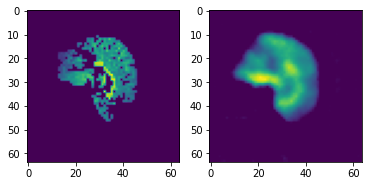

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


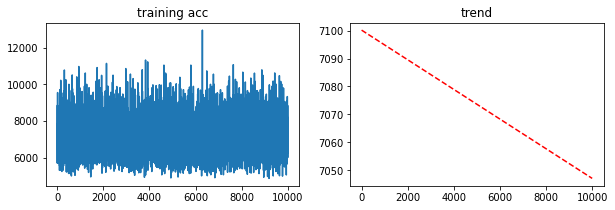

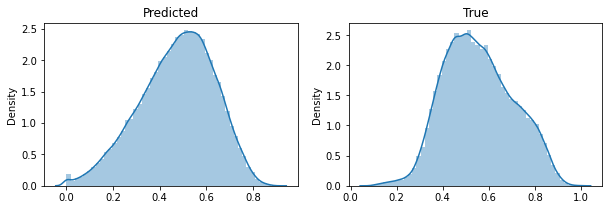

epoch 271/501 | batch 0/212.0 | time 0:23:54.149141 | loss 7083.24805
epoch 271/501 | batch 50/212.0 | time 0:23:55.362185 | loss 7996.55762
epoch 271/501 | batch 100/212.0 | time 0:23:56.477919 | loss 6073.82617
epoch 271/501 | batch 150/212.0 | time 0:23:57.603038 | loss 5631.07471
epoch 271/501 | batch 200/212.0 | time 0:23:58.718468 | loss 8117.93311
epoch 272/501 | batch 0/212.0 | time 0:23:58.998047 | loss 8078.33936
epoch 272/501 | batch 50/212.0 | time 0:24:00.115576 | loss 6291.35254
epoch 272/501 | batch 100/212.0 | time 0:24:01.233363 | loss 7123.10059
epoch 272/501 | batch 150/212.0 | time 0:24:02.349980 | loss 7164.36377
epoch 272/501 | batch 200/212.0 | time 0:24:03.464147 | loss 5852.86426
epoch 273/501 | batch 0/212.0 | time 0:24:03.743587 | loss 7660.36523
epoch 273/501 | batch 50/212.0 | time 0:24:04.859083 | loss 7026.62598
epoch 273/501 | batch 100/212.0 | time 0:24:05.975124 | loss 7812.82812
epoch 273/501 | batch 150/212.0 | time 0:24:07.091786 | loss 8363.90527
e

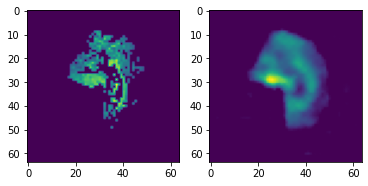

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


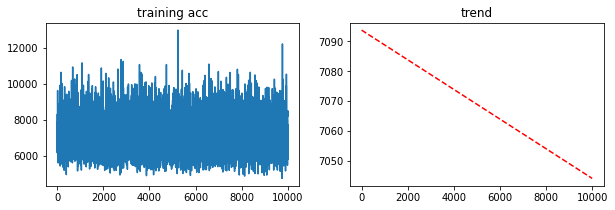

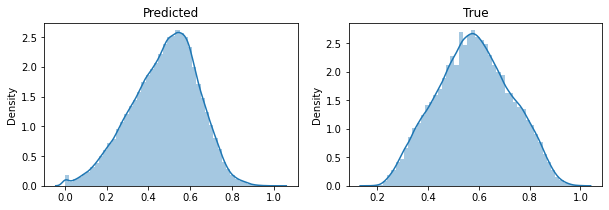

epoch 276/501 | batch 0/212.0 | time 0:24:20.739876 | loss 6485.82861
epoch 276/501 | batch 50/212.0 | time 0:24:21.981801 | loss 6208.88574
epoch 276/501 | batch 100/212.0 | time 0:24:23.096588 | loss 5958.7793
epoch 276/501 | batch 150/212.0 | time 0:24:24.217100 | loss 7102.92871
epoch 276/501 | batch 200/212.0 | time 0:24:25.342226 | loss 6162.40967
epoch 277/501 | batch 0/212.0 | time 0:24:25.624361 | loss 6668.74609
epoch 277/501 | batch 50/212.0 | time 0:24:26.739173 | loss 7437.99414
epoch 277/501 | batch 100/212.0 | time 0:24:27.855797 | loss 5999.80859
epoch 277/501 | batch 150/212.0 | time 0:24:28.971873 | loss 7692.19824
epoch 277/501 | batch 200/212.0 | time 0:24:30.086724 | loss 6206.69824
epoch 278/501 | batch 0/212.0 | time 0:24:30.366990 | loss 6696.89795
epoch 278/501 | batch 50/212.0 | time 0:24:31.493913 | loss 6921.06006
epoch 278/501 | batch 100/212.0 | time 0:24:32.611924 | loss 6817.52539
epoch 278/501 | batch 150/212.0 | time 0:24:33.725578 | loss 9154.58008
ep

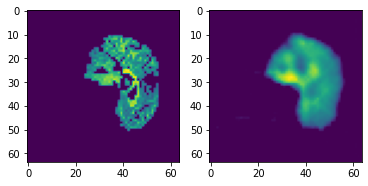

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


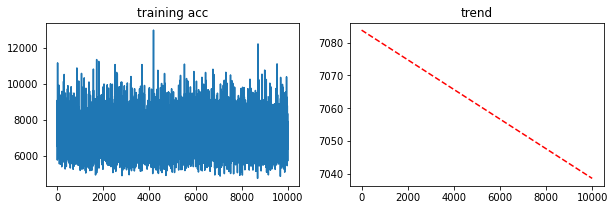

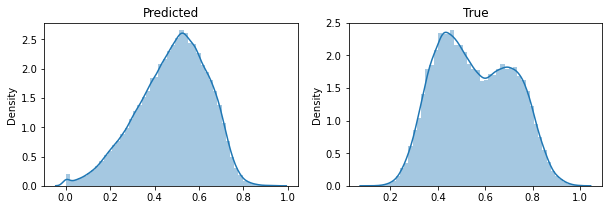

epoch 281/501 | batch 0/212.0 | time 0:24:47.075947 | loss 7322.91016
epoch 281/501 | batch 50/212.0 | time 0:24:48.330523 | loss 7672.17773
epoch 281/501 | batch 100/212.0 | time 0:24:49.445128 | loss 5989.54785
epoch 281/501 | batch 150/212.0 | time 0:24:50.560084 | loss 5904.6416
epoch 281/501 | batch 200/212.0 | time 0:24:51.673966 | loss 6798.03613
epoch 282/501 | batch 0/212.0 | time 0:24:51.952427 | loss 7242.5835
epoch 282/501 | batch 50/212.0 | time 0:24:53.066195 | loss 6823.15332
epoch 282/501 | batch 100/212.0 | time 0:24:54.189774 | loss 7238.54102
epoch 282/501 | batch 150/212.0 | time 0:24:55.309167 | loss 6717.59277
epoch 282/501 | batch 200/212.0 | time 0:24:56.423378 | loss 7167.12305
epoch 283/501 | batch 0/212.0 | time 0:24:56.702528 | loss 8514.50391
epoch 283/501 | batch 50/212.0 | time 0:24:57.817952 | loss 7669.39062
epoch 283/501 | batch 100/212.0 | time 0:24:58.931484 | loss 6494.90186
epoch 283/501 | batch 150/212.0 | time 0:25:00.046235 | loss 6589.57568
epo

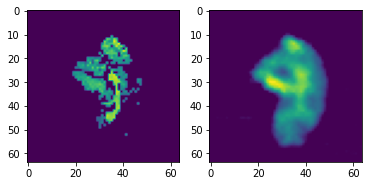

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


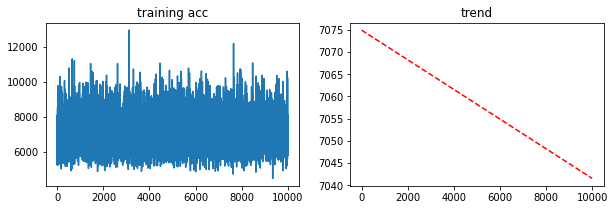

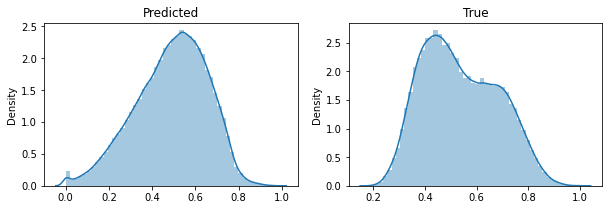

epoch 286/501 | batch 0/212.0 | time 0:25:13.561883 | loss 6964.93311
epoch 286/501 | batch 50/212.0 | time 0:25:14.804152 | loss 7372.97168
epoch 286/501 | batch 100/212.0 | time 0:25:15.926339 | loss 7647.38574
epoch 286/501 | batch 150/212.0 | time 0:25:17.042431 | loss 5778.88672
epoch 286/501 | batch 200/212.0 | time 0:25:18.158787 | loss 8242.13574
epoch 287/501 | batch 0/212.0 | time 0:25:18.437747 | loss 8521.12988
epoch 287/501 | batch 50/212.0 | time 0:25:19.551395 | loss 6149.33545
epoch 287/501 | batch 100/212.0 | time 0:25:20.667982 | loss 7442.20117
epoch 287/501 | batch 150/212.0 | time 0:25:21.784948 | loss 7244.85059
epoch 287/501 | batch 200/212.0 | time 0:25:22.906968 | loss 6197.14258
epoch 288/501 | batch 0/212.0 | time 0:25:23.188286 | loss 7212.17627
epoch 288/501 | batch 50/212.0 | time 0:25:24.304097 | loss 6895.86963
epoch 288/501 | batch 100/212.0 | time 0:25:25.419784 | loss 6153.94727
epoch 288/501 | batch 150/212.0 | time 0:25:26.535078 | loss 7032.52734
e

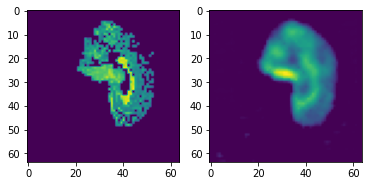

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


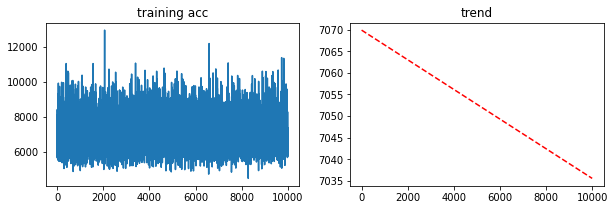

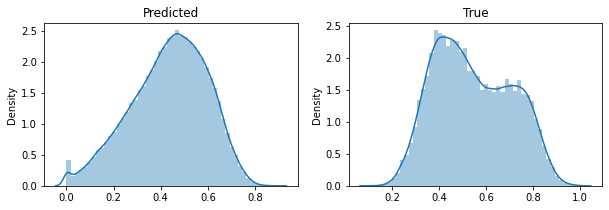

epoch 291/501 | batch 0/212.0 | time 0:25:39.958138 | loss 7870.95996
epoch 291/501 | batch 50/212.0 | time 0:25:41.174719 | loss 6347.13086
epoch 291/501 | batch 100/212.0 | time 0:25:42.295432 | loss 7069.34912
epoch 291/501 | batch 150/212.0 | time 0:25:43.413090 | loss 6843.09912
epoch 291/501 | batch 200/212.0 | time 0:25:44.528954 | loss 6121.50098
epoch 292/501 | batch 0/212.0 | time 0:25:44.809050 | loss 5568.61035
epoch 292/501 | batch 50/212.0 | time 0:25:45.924756 | loss 6955.38818
epoch 292/501 | batch 100/212.0 | time 0:25:47.039218 | loss 6479.55225
epoch 292/501 | batch 150/212.0 | time 0:25:48.160780 | loss 6566.16846
epoch 292/501 | batch 200/212.0 | time 0:25:49.280589 | loss 6133.83203
epoch 293/501 | batch 0/212.0 | time 0:25:49.559807 | loss 7064.48096
epoch 293/501 | batch 50/212.0 | time 0:25:50.673600 | loss 6727.12402
epoch 293/501 | batch 100/212.0 | time 0:25:51.789565 | loss 5968.58252
epoch 293/501 | batch 150/212.0 | time 0:25:52.909261 | loss 6282.46582
e

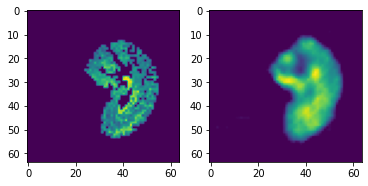

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


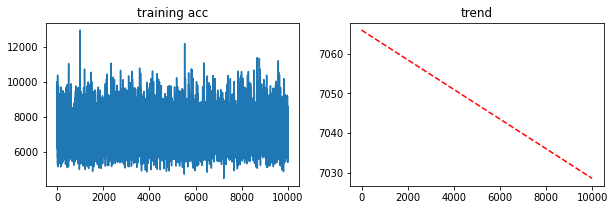

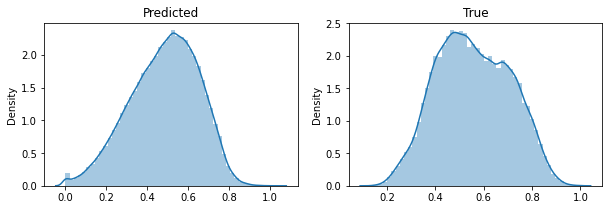

epoch 296/501 | batch 0/212.0 | time 0:26:06.506413 | loss 6533.90039
epoch 296/501 | batch 50/212.0 | time 0:26:07.731868 | loss 8062.44922
epoch 296/501 | batch 100/212.0 | time 0:26:08.846613 | loss 7430.58594
epoch 296/501 | batch 150/212.0 | time 0:26:09.967461 | loss 8846.03613
epoch 296/501 | batch 200/212.0 | time 0:26:11.093936 | loss 7664.01855
epoch 297/501 | batch 0/212.0 | time 0:26:11.377290 | loss 5934.57812
epoch 297/501 | batch 50/212.0 | time 0:26:12.494744 | loss 8496.99609
epoch 297/501 | batch 100/212.0 | time 0:26:13.611294 | loss 6442.71973
epoch 297/501 | batch 150/212.0 | time 0:26:14.726181 | loss 6232.88574
epoch 297/501 | batch 200/212.0 | time 0:26:15.849147 | loss 7555.93457
epoch 298/501 | batch 0/212.0 | time 0:26:16.130432 | loss 9125.26074
epoch 298/501 | batch 50/212.0 | time 0:26:17.244783 | loss 6140.6543
epoch 298/501 | batch 100/212.0 | time 0:26:18.367688 | loss 6872.63672
epoch 298/501 | batch 150/212.0 | time 0:26:19.483517 | loss 5981.58789
ep

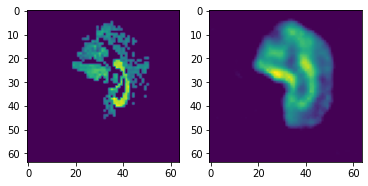

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


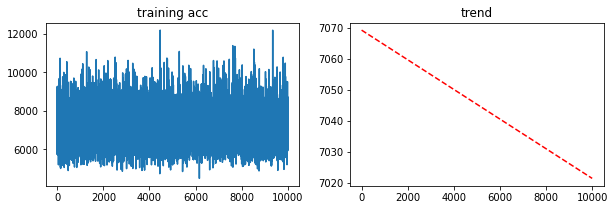

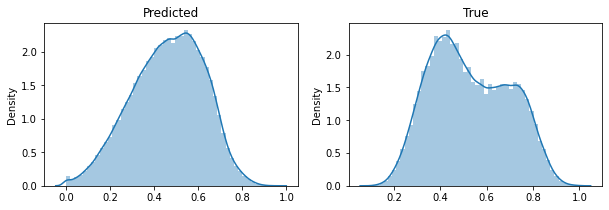

epoch 301/501 | batch 0/212.0 | time 0:26:32.805994 | loss 6834.10547
epoch 301/501 | batch 50/212.0 | time 0:26:34.019412 | loss 6963.9502
epoch 301/501 | batch 100/212.0 | time 0:26:35.133573 | loss 8000.50098
epoch 301/501 | batch 150/212.0 | time 0:26:36.250765 | loss 6800.35645
epoch 301/501 | batch 200/212.0 | time 0:26:37.364948 | loss 6676.02734
epoch 302/501 | batch 0/212.0 | time 0:26:37.646063 | loss 7458.91357
epoch 302/501 | batch 50/212.0 | time 0:26:38.767326 | loss 6748.47852
epoch 302/501 | batch 100/212.0 | time 0:26:39.884810 | loss 6571.46338
epoch 302/501 | batch 150/212.0 | time 0:26:41.000569 | loss 9006.25879
epoch 302/501 | batch 200/212.0 | time 0:26:42.114831 | loss 7354.89258
epoch 303/501 | batch 0/212.0 | time 0:26:42.394548 | loss 6850.1377
epoch 303/501 | batch 50/212.0 | time 0:26:43.509175 | loss 7670.86328
epoch 303/501 | batch 100/212.0 | time 0:26:44.625003 | loss 7291.6543
epoch 303/501 | batch 150/212.0 | time 0:26:45.740428 | loss 8914.49219
epoc

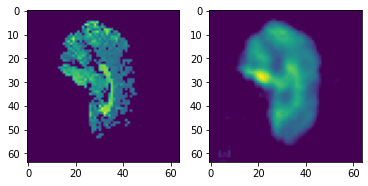

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


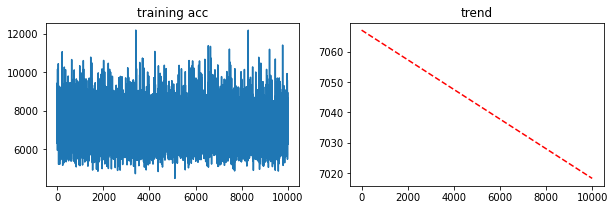

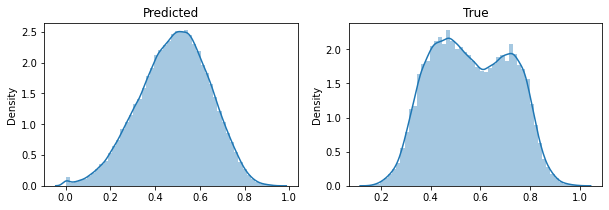

epoch 306/501 | batch 0/212.0 | time 0:26:59.211903 | loss 6590.16846
epoch 306/501 | batch 50/212.0 | time 0:27:00.469129 | loss 6757.5376
epoch 306/501 | batch 100/212.0 | time 0:27:01.583498 | loss 6770.97266
epoch 306/501 | batch 150/212.0 | time 0:27:02.698851 | loss 6673.53857
epoch 306/501 | batch 200/212.0 | time 0:27:03.812281 | loss 8391.76172
epoch 307/501 | batch 0/212.0 | time 0:27:04.091448 | loss 6986.86621
epoch 307/501 | batch 50/212.0 | time 0:27:05.209272 | loss 5909.94043
epoch 307/501 | batch 100/212.0 | time 0:27:06.324054 | loss 7510.20068
epoch 307/501 | batch 150/212.0 | time 0:27:07.444287 | loss 6280.2666
epoch 307/501 | batch 200/212.0 | time 0:27:08.558100 | loss 8880.25195
epoch 308/501 | batch 0/212.0 | time 0:27:08.837142 | loss 7330.64209
epoch 308/501 | batch 50/212.0 | time 0:27:09.950900 | loss 6237.20996
epoch 308/501 | batch 100/212.0 | time 0:27:11.064781 | loss 9098.14648
epoch 308/501 | batch 150/212.0 | time 0:27:12.183700 | loss 8443.4375
epoc

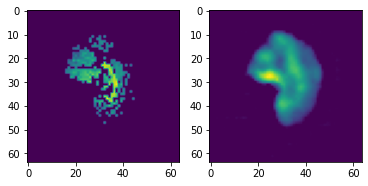

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


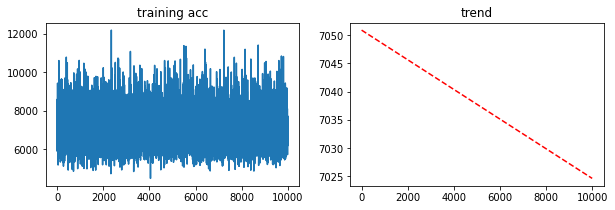

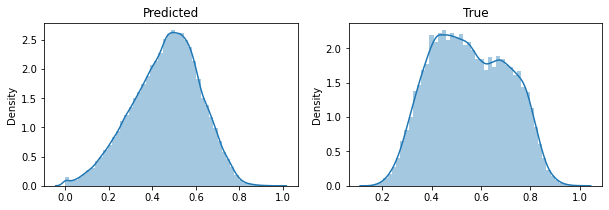

epoch 311/501 | batch 0/212.0 | time 0:27:25.545590 | loss 5997.50195
epoch 311/501 | batch 50/212.0 | time 0:27:26.788602 | loss 6005.45605
epoch 311/501 | batch 100/212.0 | time 0:27:27.906017 | loss 7044.00391
epoch 311/501 | batch 150/212.0 | time 0:27:29.022510 | loss 5374.55176
epoch 311/501 | batch 200/212.0 | time 0:27:30.136907 | loss 7328.56006
epoch 312/501 | batch 0/212.0 | time 0:27:30.416500 | loss 7351.42969
epoch 312/501 | batch 50/212.0 | time 0:27:31.532823 | loss 7428.00488
epoch 312/501 | batch 100/212.0 | time 0:27:32.650107 | loss 6261.92773
epoch 312/501 | batch 150/212.0 | time 0:27:33.765811 | loss 6175.14502
epoch 312/501 | batch 200/212.0 | time 0:27:34.880339 | loss 6901.04492
epoch 313/501 | batch 0/212.0 | time 0:27:35.158580 | loss 7501.18945
epoch 313/501 | batch 50/212.0 | time 0:27:36.272363 | loss 6574.15918
epoch 313/501 | batch 100/212.0 | time 0:27:37.387655 | loss 6296.69629
epoch 313/501 | batch 150/212.0 | time 0:27:38.501871 | loss 5823.11719
e

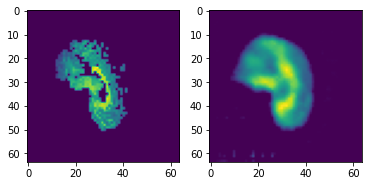

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


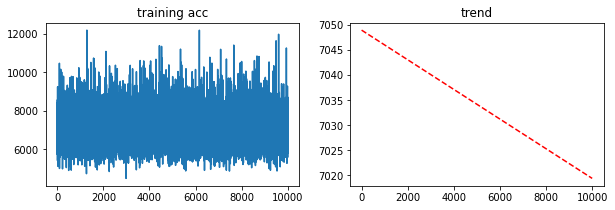

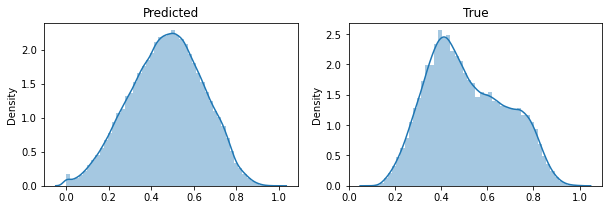

epoch 316/501 | batch 0/212.0 | time 0:27:51.945564 | loss 6445.06006
epoch 316/501 | batch 50/212.0 | time 0:27:53.165082 | loss 7522.35254
epoch 316/501 | batch 100/212.0 | time 0:27:54.281716 | loss 7915.7373
epoch 316/501 | batch 150/212.0 | time 0:27:55.397704 | loss 7319.98535
epoch 316/501 | batch 200/212.0 | time 0:27:56.512390 | loss 7418.17285
epoch 317/501 | batch 0/212.0 | time 0:27:56.791175 | loss 6799.28174
epoch 317/501 | batch 50/212.0 | time 0:27:57.905451 | loss 6906.61865
epoch 317/501 | batch 100/212.0 | time 0:27:59.020783 | loss 6771.46094
epoch 317/501 | batch 150/212.0 | time 0:28:00.133759 | loss 8267.4668
epoch 317/501 | batch 200/212.0 | time 0:28:01.255381 | loss 5949.77783
epoch 318/501 | batch 0/212.0 | time 0:28:01.536704 | loss 6597.22949
epoch 318/501 | batch 50/212.0 | time 0:28:02.652364 | loss 8022.13574
epoch 318/501 | batch 100/212.0 | time 0:28:03.771214 | loss 7451.7749
epoch 318/501 | batch 150/212.0 | time 0:28:04.884567 | loss 5463.24463
epoc

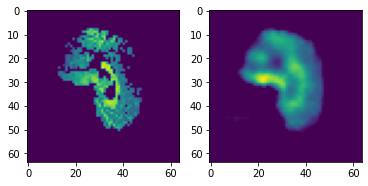

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


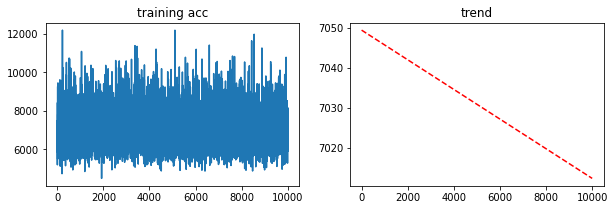

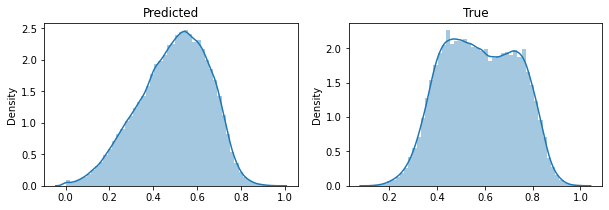

epoch 321/501 | batch 0/212.0 | time 0:28:18.350292 | loss 7695.32422
epoch 321/501 | batch 50/212.0 | time 0:28:19.597661 | loss 6538.76953
epoch 321/501 | batch 100/212.0 | time 0:28:20.710772 | loss 6477.19141
epoch 321/501 | batch 150/212.0 | time 0:28:21.827234 | loss 6754.97852
epoch 321/501 | batch 200/212.0 | time 0:28:22.941160 | loss 5845.81543
epoch 322/501 | batch 0/212.0 | time 0:28:23.221912 | loss 7803.0249
epoch 322/501 | batch 50/212.0 | time 0:28:24.341126 | loss 7609.54443
epoch 322/501 | batch 100/212.0 | time 0:28:25.453949 | loss 7427.53027
epoch 322/501 | batch 150/212.0 | time 0:28:26.579145 | loss 8684.1748
epoch 322/501 | batch 200/212.0 | time 0:28:27.697188 | loss 6915.68457
epoch 323/501 | batch 0/212.0 | time 0:28:27.976997 | loss 7103.4126
epoch 323/501 | batch 50/212.0 | time 0:28:29.093470 | loss 7082.58984
epoch 323/501 | batch 100/212.0 | time 0:28:30.208833 | loss 6328.33301
epoch 323/501 | batch 150/212.0 | time 0:28:31.322296 | loss 6692.74316
epoc

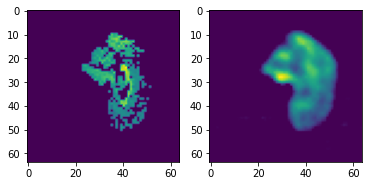

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


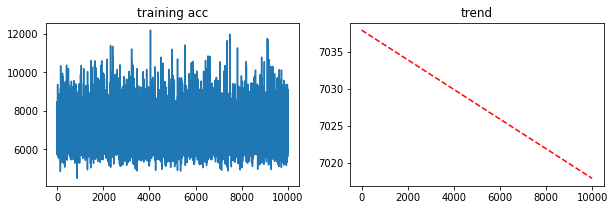

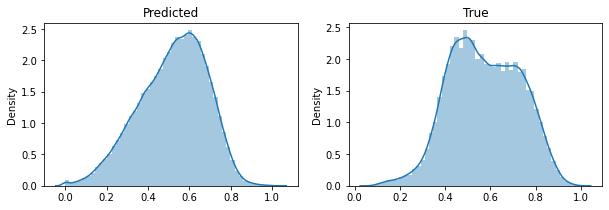

epoch 326/501 | batch 0/212.0 | time 0:28:44.853801 | loss 6078.79785
epoch 326/501 | batch 50/212.0 | time 0:28:46.104146 | loss 7048.33203
epoch 326/501 | batch 100/212.0 | time 0:28:47.225869 | loss 8646.33398
epoch 326/501 | batch 150/212.0 | time 0:28:48.342069 | loss 7666.08301
epoch 326/501 | batch 200/212.0 | time 0:28:49.460749 | loss 6801.81348
epoch 327/501 | batch 0/212.0 | time 0:28:49.740097 | loss 6684.14258
epoch 327/501 | batch 50/212.0 | time 0:28:50.855591 | loss 6680.8252
epoch 327/501 | batch 100/212.0 | time 0:28:51.969557 | loss 5717.10205
epoch 327/501 | batch 150/212.0 | time 0:28:53.086402 | loss 5900.14307
epoch 327/501 | batch 200/212.0 | time 0:28:54.202175 | loss 6172.94922
epoch 328/501 | batch 0/212.0 | time 0:28:54.482198 | loss 7167.53174
epoch 328/501 | batch 50/212.0 | time 0:28:55.599375 | loss 7104.63232
epoch 328/501 | batch 100/212.0 | time 0:28:56.715244 | loss 6142.50391
epoch 328/501 | batch 150/212.0 | time 0:28:57.830739 | loss 7731.71973
ep

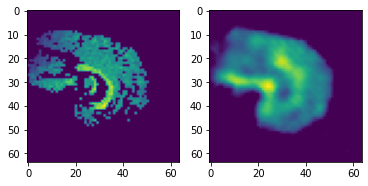

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


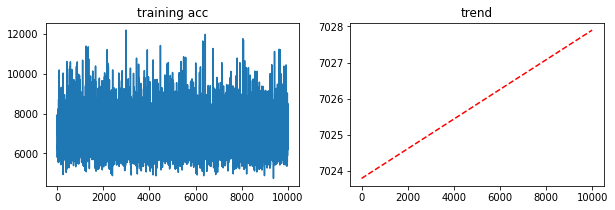

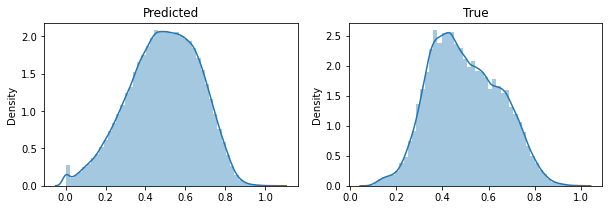

epoch 331/501 | batch 0/212.0 | time 0:29:11.401157 | loss 9031.07617
epoch 331/501 | batch 50/212.0 | time 0:29:12.641117 | loss 8407.81055
epoch 331/501 | batch 100/212.0 | time 0:29:13.756810 | loss 8645.26758
epoch 331/501 | batch 150/212.0 | time 0:29:14.871525 | loss 6532.82422
epoch 331/501 | batch 200/212.0 | time 0:29:15.986241 | loss 5830.10742
epoch 332/501 | batch 0/212.0 | time 0:29:16.264986 | loss 7165.82666
epoch 332/501 | batch 50/212.0 | time 0:29:17.380568 | loss 9050.83203
epoch 332/501 | batch 100/212.0 | time 0:29:18.495366 | loss 7288.49902
epoch 332/501 | batch 150/212.0 | time 0:29:19.609848 | loss 6222.6333
epoch 332/501 | batch 200/212.0 | time 0:29:20.724635 | loss 6139.99023
epoch 333/501 | batch 0/212.0 | time 0:29:21.003832 | loss 5989.5625
epoch 333/501 | batch 50/212.0 | time 0:29:22.118987 | loss 6619.11523
epoch 333/501 | batch 100/212.0 | time 0:29:23.234660 | loss 6768.43115
epoch 333/501 | batch 150/212.0 | time 0:29:24.350736 | loss 7145.71777
epo

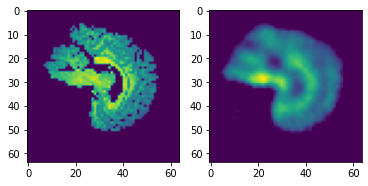

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


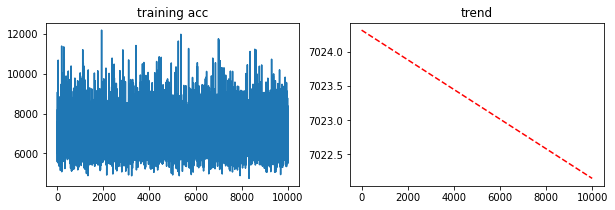

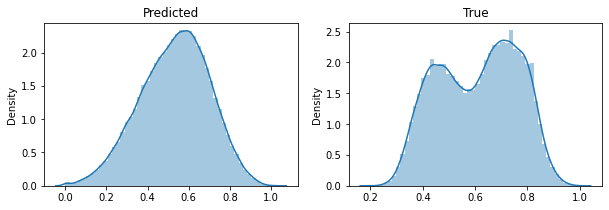

epoch 336/501 | batch 0/212.0 | time 0:29:37.915327 | loss 6763.26074
epoch 336/501 | batch 50/212.0 | time 0:29:39.148495 | loss 7714.26758
epoch 336/501 | batch 100/212.0 | time 0:29:40.266412 | loss 7404.83545
epoch 336/501 | batch 150/212.0 | time 0:29:41.388475 | loss 7288.55078
epoch 336/501 | batch 200/212.0 | time 0:29:42.505382 | loss 7556.36914
epoch 337/501 | batch 0/212.0 | time 0:29:42.785811 | loss 6966.33008
epoch 337/501 | batch 50/212.0 | time 0:29:43.901435 | loss 7410.80273
epoch 337/501 | batch 100/212.0 | time 0:29:45.018150 | loss 6442.18848
epoch 337/501 | batch 150/212.0 | time 0:29:46.133336 | loss 7976.02832
epoch 337/501 | batch 200/212.0 | time 0:29:47.249865 | loss 7594.04541
epoch 338/501 | batch 0/212.0 | time 0:29:47.531966 | loss 7193.11816
epoch 338/501 | batch 50/212.0 | time 0:29:48.649309 | loss 7424.30127
epoch 338/501 | batch 100/212.0 | time 0:29:49.764988 | loss 6719.79639
epoch 338/501 | batch 150/212.0 | time 0:29:50.879064 | loss 6731.79346
e

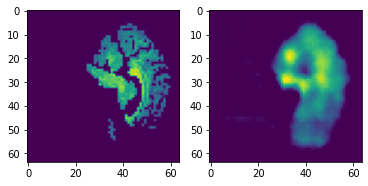

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


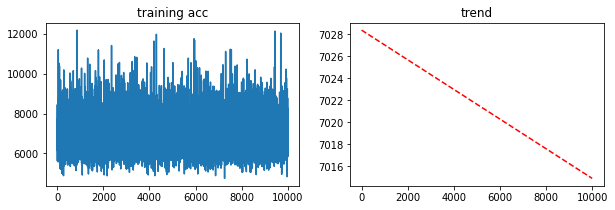

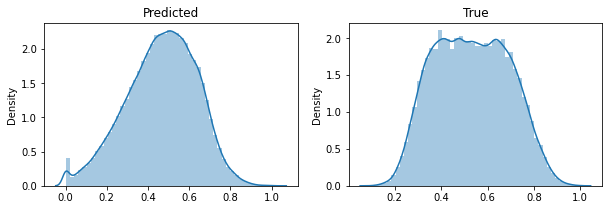

epoch 341/501 | batch 0/212.0 | time 0:30:04.187292 | loss 7559.17676
epoch 341/501 | batch 50/212.0 | time 0:30:05.446480 | loss 5855.83105
epoch 341/501 | batch 100/212.0 | time 0:30:06.561754 | loss 6027.68506
epoch 341/501 | batch 150/212.0 | time 0:30:07.679580 | loss 6794.51172
epoch 341/501 | batch 200/212.0 | time 0:30:08.793991 | loss 7283.16309
epoch 342/501 | batch 0/212.0 | time 0:30:09.074189 | loss 6803.88672
epoch 342/501 | batch 50/212.0 | time 0:30:10.190804 | loss 5818.19922
epoch 342/501 | batch 100/212.0 | time 0:30:11.307084 | loss 8147.23926
epoch 342/501 | batch 150/212.0 | time 0:30:12.421051 | loss 8358.50293
epoch 342/501 | batch 200/212.0 | time 0:30:13.536934 | loss 6632.7793
epoch 343/501 | batch 0/212.0 | time 0:30:13.817117 | loss 6604.75488
epoch 343/501 | batch 50/212.0 | time 0:30:14.935270 | loss 7965.23291
epoch 343/501 | batch 100/212.0 | time 0:30:16.055671 | loss 5920.28906
epoch 343/501 | batch 150/212.0 | time 0:30:17.171477 | loss 6949.01123
ep

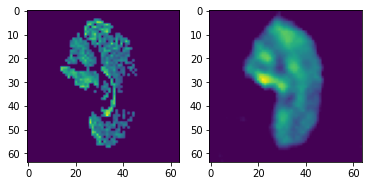

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


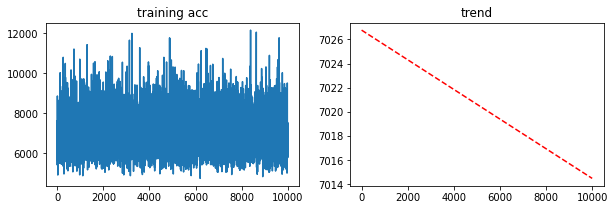

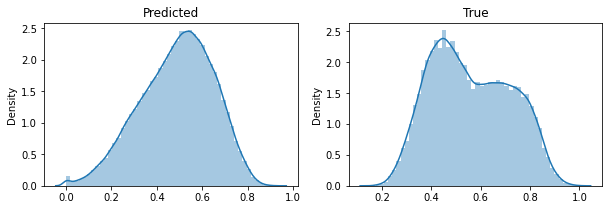

epoch 346/501 | batch 0/212.0 | time 0:30:30.720121 | loss 5687.65625
epoch 346/501 | batch 50/212.0 | time 0:30:31.965206 | loss 6532.64014
epoch 346/501 | batch 100/212.0 | time 0:30:33.085297 | loss 7011.74463
epoch 346/501 | batch 150/212.0 | time 0:30:34.201509 | loss 6250.66211
epoch 346/501 | batch 200/212.0 | time 0:30:35.317362 | loss 7039.94238
epoch 347/501 | batch 0/212.0 | time 0:30:35.597268 | loss 5843.17383
epoch 347/501 | batch 50/212.0 | time 0:30:36.712667 | loss 7200.93457
epoch 347/501 | batch 100/212.0 | time 0:30:37.837571 | loss 6650.38623
epoch 347/501 | batch 150/212.0 | time 0:30:38.955634 | loss 7382.79297
epoch 347/501 | batch 200/212.0 | time 0:30:40.070794 | loss 6933.08447
epoch 348/501 | batch 0/212.0 | time 0:30:40.349460 | loss 6541.75391
epoch 348/501 | batch 50/212.0 | time 0:30:41.463143 | loss 7144.89258
epoch 348/501 | batch 100/212.0 | time 0:30:42.577693 | loss 5657.74951
epoch 348/501 | batch 150/212.0 | time 0:30:43.693506 | loss 6009.30273
e

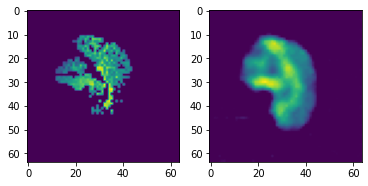

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


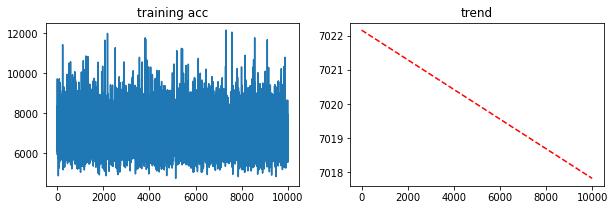

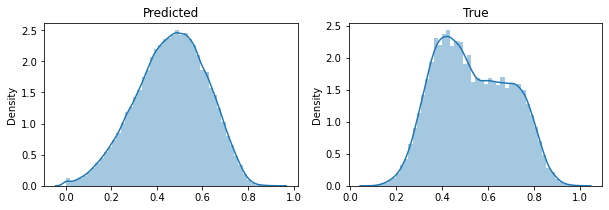

epoch 351/501 | batch 0/212.0 | time 0:30:56.976197 | loss 8092.01855
epoch 351/501 | batch 50/212.0 | time 0:30:58.213809 | loss 8210.69531
epoch 351/501 | batch 100/212.0 | time 0:30:59.328779 | loss 7862.62354
epoch 351/501 | batch 150/212.0 | time 0:31:00.444284 | loss 7980.27539
epoch 351/501 | batch 200/212.0 | time 0:31:01.561345 | loss 7110.84131
epoch 352/501 | batch 0/212.0 | time 0:31:01.841592 | loss 7724.25244
epoch 352/501 | batch 50/212.0 | time 0:31:02.956182 | loss 6646.15283
epoch 352/501 | batch 100/212.0 | time 0:31:04.070699 | loss 6285.89453
epoch 352/501 | batch 150/212.0 | time 0:31:05.186030 | loss 8218.10156
epoch 352/501 | batch 200/212.0 | time 0:31:06.302273 | loss 5954.88965
epoch 353/501 | batch 0/212.0 | time 0:31:06.581732 | loss 8513.10547
epoch 353/501 | batch 50/212.0 | time 0:31:07.698764 | loss 7962.69434
epoch 353/501 | batch 100/212.0 | time 0:31:08.812944 | loss 6994.67432
epoch 353/501 | batch 150/212.0 | time 0:31:09.927560 | loss 7683.70312
e

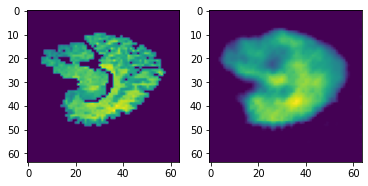

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


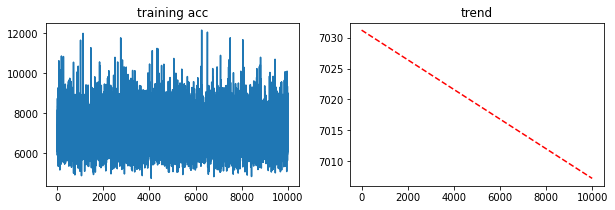

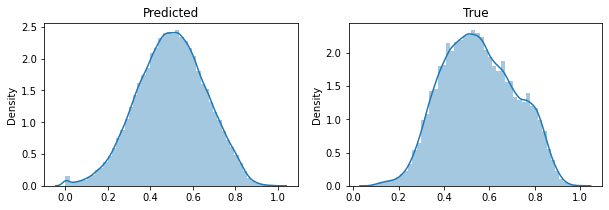

epoch 356/501 | batch 0/212.0 | time 0:31:23.306291 | loss 6532.00879
epoch 356/501 | batch 50/212.0 | time 0:31:24.559244 | loss 6670.13721
epoch 356/501 | batch 100/212.0 | time 0:31:25.683166 | loss 7770.21338
epoch 356/501 | batch 150/212.0 | time 0:31:26.801546 | loss 7544.87549
epoch 356/501 | batch 200/212.0 | time 0:31:27.914962 | loss 5697.86963
epoch 357/501 | batch 0/212.0 | time 0:31:28.194271 | loss 7275.51855
epoch 357/501 | batch 50/212.0 | time 0:31:29.310229 | loss 8335.95215
epoch 357/501 | batch 100/212.0 | time 0:31:30.425908 | loss 5429.02441
epoch 357/501 | batch 150/212.0 | time 0:31:31.540812 | loss 7934.47705
epoch 357/501 | batch 200/212.0 | time 0:31:32.663863 | loss 7544.5249
epoch 358/501 | batch 0/212.0 | time 0:31:32.942604 | loss 7190.50977
epoch 358/501 | batch 50/212.0 | time 0:31:34.057046 | loss 7691.66016
epoch 358/501 | batch 100/212.0 | time 0:31:35.181099 | loss 6219.7959
epoch 358/501 | batch 150/212.0 | time 0:31:36.300251 | loss 6038.7334
epoc

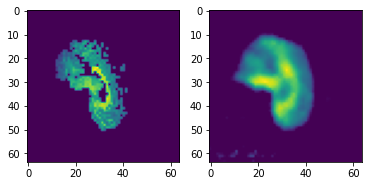

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


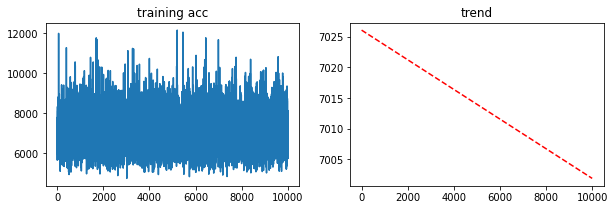

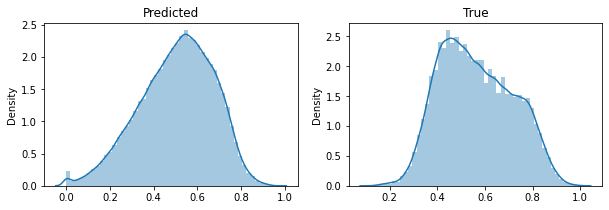

epoch 361/501 | batch 0/212.0 | time 0:31:49.462233 | loss 7092.29883
epoch 361/501 | batch 50/212.0 | time 0:31:50.686426 | loss 7330.55273
epoch 361/501 | batch 100/212.0 | time 0:31:51.806522 | loss 6233.24512
epoch 361/501 | batch 150/212.0 | time 0:31:52.924947 | loss 8388.55957
epoch 361/501 | batch 200/212.0 | time 0:31:54.041008 | loss 7302.37549
epoch 362/501 | batch 0/212.0 | time 0:31:54.322750 | loss 7170.34521
epoch 362/501 | batch 50/212.0 | time 0:31:55.439401 | loss 6804.05615
epoch 362/501 | batch 100/212.0 | time 0:31:56.554057 | loss 7285.99658
epoch 362/501 | batch 150/212.0 | time 0:31:57.669834 | loss 6895.7041
epoch 362/501 | batch 200/212.0 | time 0:31:58.787264 | loss 6807.92236
epoch 363/501 | batch 0/212.0 | time 0:31:59.069932 | loss 7215.67871
epoch 363/501 | batch 50/212.0 | time 0:32:00.189916 | loss 6915.71191
epoch 363/501 | batch 100/212.0 | time 0:32:01.305458 | loss 6361.23926
epoch 363/501 | batch 150/212.0 | time 0:32:02.422287 | loss 6627.55078
ep

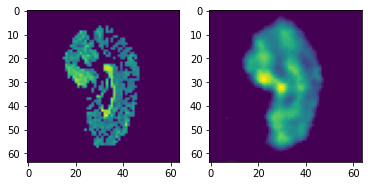

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


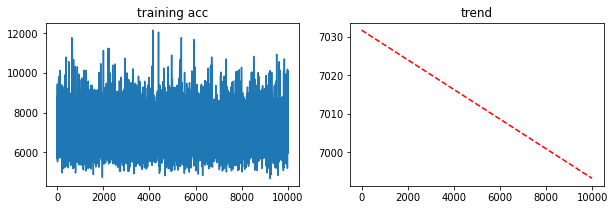

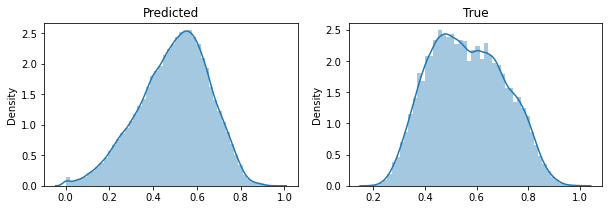

epoch 366/501 | batch 0/212.0 | time 0:32:15.910350 | loss 6362.48193
epoch 366/501 | batch 50/212.0 | time 0:32:17.153487 | loss 6140.17969
epoch 366/501 | batch 100/212.0 | time 0:32:18.267942 | loss 6534.7373
epoch 366/501 | batch 150/212.0 | time 0:32:19.383670 | loss 5866.64551
epoch 366/501 | batch 200/212.0 | time 0:32:20.498824 | loss 6186.81494
epoch 367/501 | batch 0/212.0 | time 0:32:20.779642 | loss 8354.33301
epoch 367/501 | batch 50/212.0 | time 0:32:21.898015 | loss 6630.08691
epoch 367/501 | batch 100/212.0 | time 0:32:23.013087 | loss 8178.60742
epoch 367/501 | batch 150/212.0 | time 0:32:24.127707 | loss 5371.3457
epoch 367/501 | batch 200/212.0 | time 0:32:25.243813 | loss 6727.32129
epoch 368/501 | batch 0/212.0 | time 0:32:25.523689 | loss 6792.66797
epoch 368/501 | batch 50/212.0 | time 0:32:26.640279 | loss 6289.06055
epoch 368/501 | batch 100/212.0 | time 0:32:27.760335 | loss 6151.30664
epoch 368/501 | batch 150/212.0 | time 0:32:28.875929 | loss 6311.49707
epo

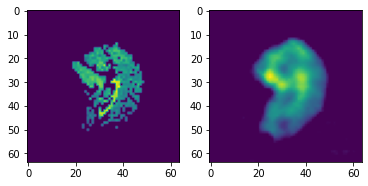

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


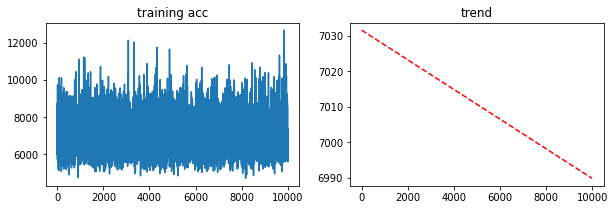

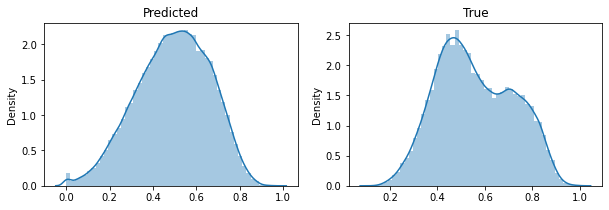

epoch 371/501 | batch 0/212.0 | time 0:32:42.240267 | loss 6351.65137
epoch 371/501 | batch 50/212.0 | time 0:32:43.489303 | loss 6178.59521
epoch 371/501 | batch 100/212.0 | time 0:32:44.604071 | loss 5151.20898
epoch 371/501 | batch 150/212.0 | time 0:32:45.718604 | loss 5806.47119
epoch 371/501 | batch 200/212.0 | time 0:32:46.832749 | loss 6704.65625
epoch 372/501 | batch 0/212.0 | time 0:32:47.113111 | loss 6402.4707
epoch 372/501 | batch 50/212.0 | time 0:32:48.232290 | loss 6829.16602
epoch 372/501 | batch 100/212.0 | time 0:32:49.347563 | loss 6063.09863
epoch 372/501 | batch 150/212.0 | time 0:32:50.461599 | loss 6231.17334
epoch 372/501 | batch 200/212.0 | time 0:32:51.576754 | loss 7279.59863
epoch 373/501 | batch 0/212.0 | time 0:32:51.855585 | loss 7342.21094
epoch 373/501 | batch 50/212.0 | time 0:32:52.971347 | loss 6449.54688
epoch 373/501 | batch 100/212.0 | time 0:32:54.086625 | loss 7941.31445
epoch 373/501 | batch 150/212.0 | time 0:32:55.203156 | loss 6614.14941
ep

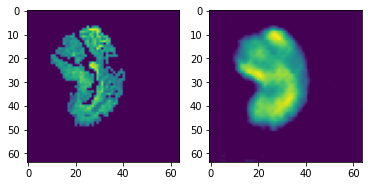

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


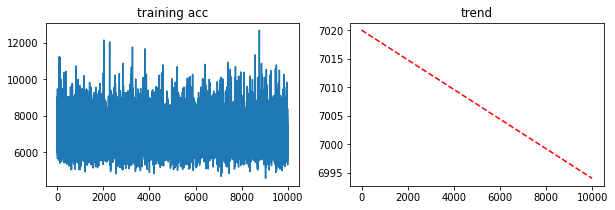

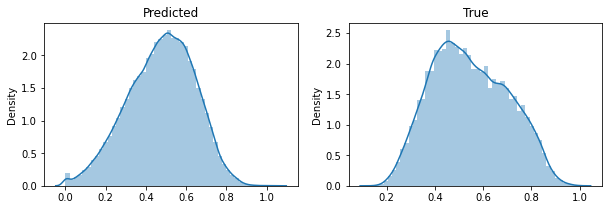

epoch 376/501 | batch 0/212.0 | time 0:33:08.491091 | loss 6461.91504
epoch 376/501 | batch 50/212.0 | time 0:33:09.721092 | loss 9167.8252
epoch 376/501 | batch 100/212.0 | time 0:33:10.834368 | loss 6809.22412
epoch 376/501 | batch 150/212.0 | time 0:33:11.951520 | loss 6925.13721
epoch 376/501 | batch 200/212.0 | time 0:33:13.064351 | loss 6783.70264
epoch 377/501 | batch 0/212.0 | time 0:33:13.344109 | loss 7483.56934
epoch 377/501 | batch 50/212.0 | time 0:33:14.458950 | loss 6745.28906
epoch 377/501 | batch 100/212.0 | time 0:33:15.577394 | loss 6420.35254
epoch 377/501 | batch 150/212.0 | time 0:33:16.691736 | loss 7557.39209
epoch 377/501 | batch 200/212.0 | time 0:33:17.806614 | loss 7101.11133
epoch 378/501 | batch 0/212.0 | time 0:33:18.086022 | loss 6083.38965
epoch 378/501 | batch 50/212.0 | time 0:33:19.200112 | loss 6657.33643
epoch 378/501 | batch 100/212.0 | time 0:33:20.315739 | loss 7266.27344
epoch 378/501 | batch 150/212.0 | time 0:33:21.430272 | loss 6462.33301
ep

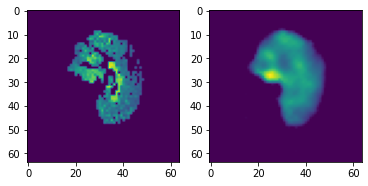

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


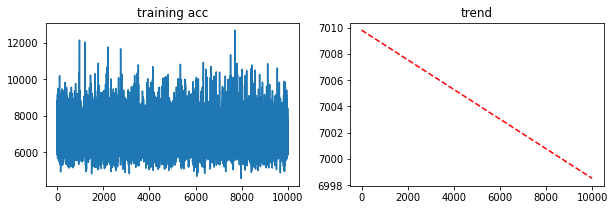

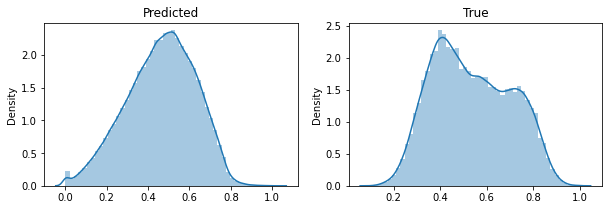

epoch 381/501 | batch 0/212.0 | time 0:33:34.844728 | loss 8631.09668
epoch 381/501 | batch 50/212.0 | time 0:33:36.097883 | loss 7198.03174
epoch 381/501 | batch 100/212.0 | time 0:33:37.213806 | loss 6061.34131
epoch 381/501 | batch 150/212.0 | time 0:33:38.329275 | loss 7543.29492
epoch 381/501 | batch 200/212.0 | time 0:33:39.453295 | loss 7271.69482
epoch 382/501 | batch 0/212.0 | time 0:33:39.732925 | loss 6067.41797
epoch 382/501 | batch 50/212.0 | time 0:33:40.850295 | loss 6662.49023
epoch 382/501 | batch 100/212.0 | time 0:33:41.965753 | loss 8167.2666
epoch 382/501 | batch 150/212.0 | time 0:33:43.080282 | loss 7917.27588
epoch 382/501 | batch 200/212.0 | time 0:33:44.203821 | loss 6386.63086
epoch 383/501 | batch 0/212.0 | time 0:33:44.482551 | loss 7374.71777
epoch 383/501 | batch 50/212.0 | time 0:33:45.599889 | loss 6394.12305
epoch 383/501 | batch 100/212.0 | time 0:33:46.715495 | loss 7964.59912
epoch 383/501 | batch 150/212.0 | time 0:33:47.830583 | loss 6903.33008
ep

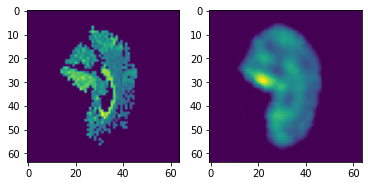

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


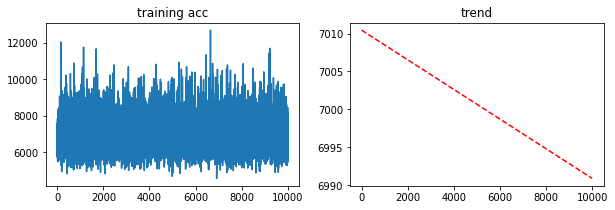

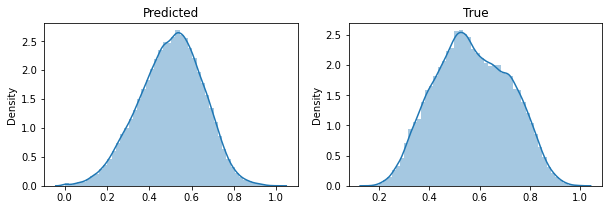

epoch 386/501 | batch 0/212.0 | time 0:34:01.408760 | loss 6746.66406
epoch 386/501 | batch 50/212.0 | time 0:34:02.628124 | loss 7543.2373
epoch 386/501 | batch 100/212.0 | time 0:34:03.744112 | loss 6340.71191
epoch 386/501 | batch 150/212.0 | time 0:34:04.861741 | loss 6030.62695
epoch 386/501 | batch 200/212.0 | time 0:34:05.975084 | loss 6785.67969
epoch 387/501 | batch 0/212.0 | time 0:34:06.254132 | loss 7176.6709
epoch 387/501 | batch 50/212.0 | time 0:34:07.372119 | loss 8810.53516
epoch 387/501 | batch 100/212.0 | time 0:34:08.486889 | loss 6459.65918
epoch 387/501 | batch 150/212.0 | time 0:34:09.603635 | loss 8149.60205
epoch 387/501 | batch 200/212.0 | time 0:34:10.730386 | loss 8860.46094
epoch 388/501 | batch 0/212.0 | time 0:34:11.010449 | loss 6368.14551
epoch 388/501 | batch 50/212.0 | time 0:34:12.126060 | loss 7239.84277
epoch 388/501 | batch 100/212.0 | time 0:34:13.241349 | loss 5739.05811
epoch 388/501 | batch 150/212.0 | time 0:34:14.356986 | loss 7235.42627
epo

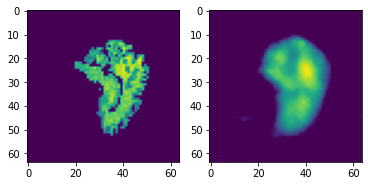

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


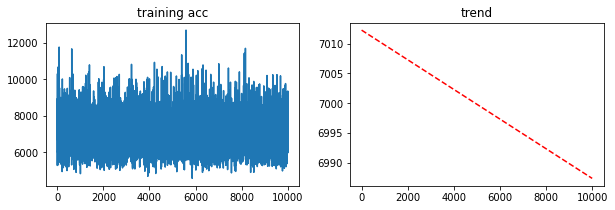

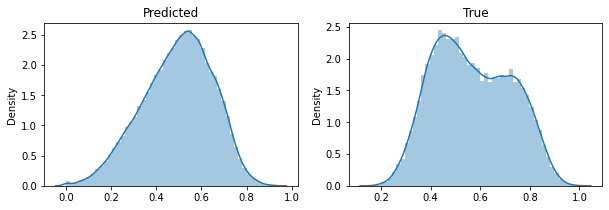

epoch 391/501 | batch 0/212.0 | time 0:34:27.439150 | loss 6526.63037
epoch 391/501 | batch 50/212.0 | time 0:34:28.685439 | loss 6020.13379
epoch 391/501 | batch 100/212.0 | time 0:34:29.801601 | loss 6291.53369
epoch 391/501 | batch 150/212.0 | time 0:34:30.919178 | loss 7047.39453
epoch 391/501 | batch 200/212.0 | time 0:34:32.034673 | loss 6969.85254
epoch 392/501 | batch 0/212.0 | time 0:34:32.314506 | loss 7025.98389
epoch 392/501 | batch 50/212.0 | time 0:34:33.436439 | loss 7863.51025
epoch 392/501 | batch 100/212.0 | time 0:34:34.553302 | loss 6418.24023
epoch 392/501 | batch 150/212.0 | time 0:34:35.667308 | loss 6862.11621
epoch 392/501 | batch 200/212.0 | time 0:34:36.785231 | loss 6816.79004
epoch 393/501 | batch 0/212.0 | time 0:34:37.063839 | loss 6822.20215
epoch 393/501 | batch 50/212.0 | time 0:34:38.178272 | loss 6757.54492
epoch 393/501 | batch 100/212.0 | time 0:34:39.292066 | loss 7531.99561
epoch 393/501 | batch 150/212.0 | time 0:34:40.408467 | loss 6802.22363
e

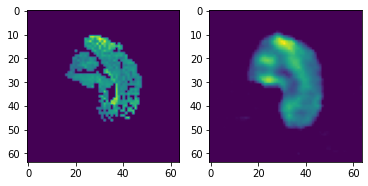

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


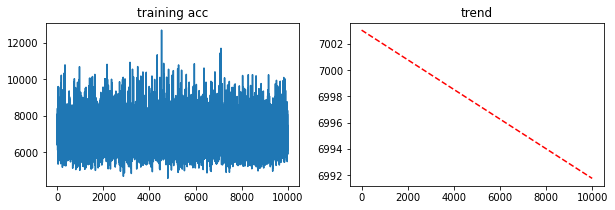

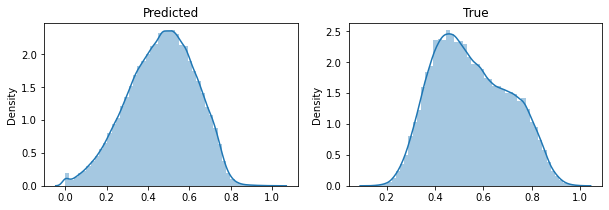

epoch 396/501 | batch 0/212.0 | time 0:34:53.943867 | loss 7086.18262
epoch 396/501 | batch 50/212.0 | time 0:34:55.185708 | loss 7085.71045
epoch 396/501 | batch 100/212.0 | time 0:34:56.299000 | loss 5606.10352
epoch 396/501 | batch 150/212.0 | time 0:34:57.412654 | loss 6748.91504
epoch 396/501 | batch 200/212.0 | time 0:34:58.525943 | loss 6367.35742
epoch 397/501 | batch 0/212.0 | time 0:34:58.807780 | loss 8242.08008
epoch 397/501 | batch 50/212.0 | time 0:34:59.923069 | loss 6084.87891
epoch 397/501 | batch 100/212.0 | time 0:35:01.037673 | loss 7180.09473
epoch 397/501 | batch 150/212.0 | time 0:35:02.154206 | loss 7206.96729
epoch 397/501 | batch 200/212.0 | time 0:35:03.270902 | loss 5655.14746
epoch 398/501 | batch 0/212.0 | time 0:35:03.551178 | loss 7279.48047
epoch 398/501 | batch 50/212.0 | time 0:35:04.666294 | loss 6686.85742
epoch 398/501 | batch 100/212.0 | time 0:35:05.780150 | loss 7086.04785
epoch 398/501 | batch 150/212.0 | time 0:35:06.896602 | loss 8091.2207
ep

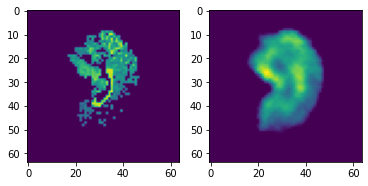

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


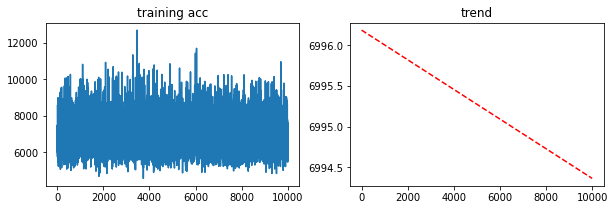

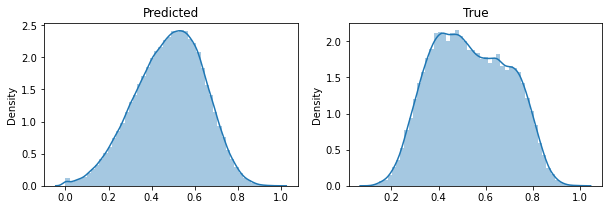

epoch 401/501 | batch 0/212.0 | time 0:35:20.261409 | loss 6875.82617
epoch 401/501 | batch 50/212.0 | time 0:35:21.506040 | loss 7226.06348
epoch 401/501 | batch 100/212.0 | time 0:35:22.621076 | loss 7447.36133
epoch 401/501 | batch 150/212.0 | time 0:35:23.736039 | loss 8745.41992
epoch 401/501 | batch 200/212.0 | time 0:35:24.849623 | loss 6159.06836
epoch 402/501 | batch 0/212.0 | time 0:35:25.130178 | loss 7655.97949
epoch 402/501 | batch 50/212.0 | time 0:35:26.247322 | loss 6282.81104
epoch 402/501 | batch 100/212.0 | time 0:35:27.362033 | loss 7576.26904
epoch 402/501 | batch 150/212.0 | time 0:35:28.476817 | loss 6633.92236
epoch 402/501 | batch 200/212.0 | time 0:35:29.593000 | loss 7364.2832
epoch 403/501 | batch 0/212.0 | time 0:35:29.872819 | loss 8318.25488
epoch 403/501 | batch 50/212.0 | time 0:35:30.988911 | loss 6441.49121
epoch 403/501 | batch 100/212.0 | time 0:35:32.103941 | loss 6237.04785
epoch 403/501 | batch 150/212.0 | time 0:35:33.220969 | loss 6805.48682
ep

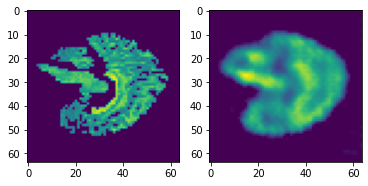

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


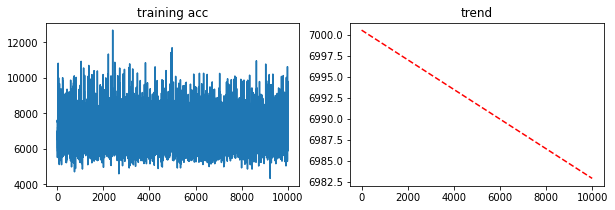

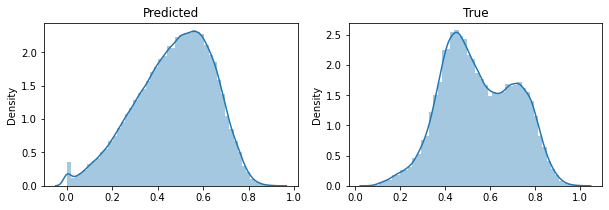

epoch 406/501 | batch 0/212.0 | time 0:35:46.635849 | loss 7309.24121
epoch 406/501 | batch 50/212.0 | time 0:35:47.861888 | loss 8941.14062
epoch 406/501 | batch 100/212.0 | time 0:35:48.977111 | loss 5588.99219
epoch 406/501 | batch 150/212.0 | time 0:35:50.094829 | loss 6993.21826
epoch 406/501 | batch 200/212.0 | time 0:35:51.210266 | loss 6660.87939
epoch 407/501 | batch 0/212.0 | time 0:35:51.490456 | loss 7556.82812
epoch 407/501 | batch 50/212.0 | time 0:35:52.606883 | loss 7573.0918
epoch 407/501 | batch 100/212.0 | time 0:35:53.720104 | loss 10388.65918
epoch 407/501 | batch 150/212.0 | time 0:35:54.834736 | loss 7207.06104
epoch 407/501 | batch 200/212.0 | time 0:35:55.952942 | loss 6733.10547
epoch 408/501 | batch 0/212.0 | time 0:35:56.232794 | loss 6116.24414
epoch 408/501 | batch 50/212.0 | time 0:35:57.349466 | loss 6242.85742
epoch 408/501 | batch 100/212.0 | time 0:35:58.463246 | loss 7741.55127
epoch 408/501 | batch 150/212.0 | time 0:35:59.577111 | loss 7493.4043
ep

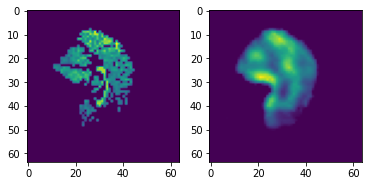

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


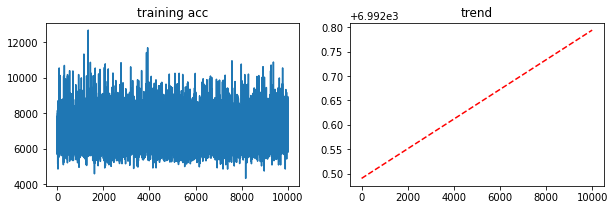

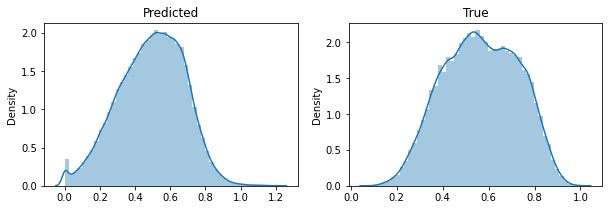

epoch 411/501 | batch 0/212.0 | time 0:36:13.243251 | loss 6659.33398
epoch 411/501 | batch 50/212.0 | time 0:36:14.472523 | loss 7122.47705
epoch 411/501 | batch 100/212.0 | time 0:36:15.588224 | loss 6212.22559
epoch 411/501 | batch 150/212.0 | time 0:36:16.702578 | loss 6576.15283
epoch 411/501 | batch 200/212.0 | time 0:36:17.817674 | loss 8627.72363
epoch 412/501 | batch 0/212.0 | time 0:36:18.096353 | loss 6273.30078
epoch 412/501 | batch 50/212.0 | time 0:36:19.211571 | loss 6719.5293
epoch 412/501 | batch 100/212.0 | time 0:36:20.330000 | loss 6058.53516
epoch 412/501 | batch 150/212.0 | time 0:36:21.447555 | loss 7025.85254
epoch 412/501 | batch 200/212.0 | time 0:36:22.563364 | loss 8249.82812
epoch 413/501 | batch 0/212.0 | time 0:36:22.844933 | loss 6436.33643
epoch 413/501 | batch 50/212.0 | time 0:36:23.963042 | loss 7749.95068
epoch 413/501 | batch 100/212.0 | time 0:36:25.079482 | loss 5289.33496
epoch 413/501 | batch 150/212.0 | time 0:36:26.195851 | loss 7319.46777
ep

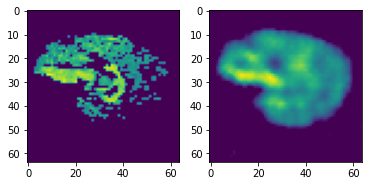

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


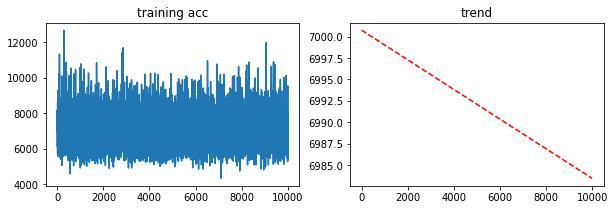

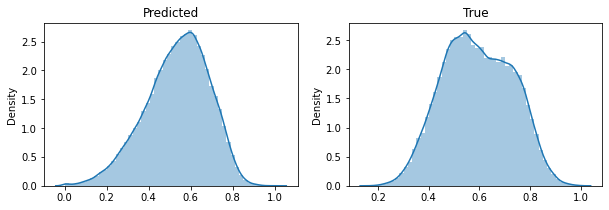

epoch 416/501 | batch 0/212.0 | time 0:36:39.765057 | loss 7237.56641
epoch 416/501 | batch 50/212.0 | time 0:36:40.999475 | loss 6756.04102
epoch 416/501 | batch 100/212.0 | time 0:36:42.114532 | loss 7097.39258
epoch 416/501 | batch 150/212.0 | time 0:36:43.229238 | loss 5748.0332
epoch 416/501 | batch 200/212.0 | time 0:36:44.345420 | loss 7082.5957
epoch 417/501 | batch 0/212.0 | time 0:36:44.624591 | loss 7322.85303
epoch 417/501 | batch 50/212.0 | time 0:36:45.744310 | loss 7463.06934
epoch 417/501 | batch 100/212.0 | time 0:36:46.867001 | loss 8159.05908
epoch 417/501 | batch 150/212.0 | time 0:36:47.989815 | loss 7059.20068
epoch 417/501 | batch 200/212.0 | time 0:36:49.109687 | loss 7348.84619
epoch 418/501 | batch 0/212.0 | time 0:36:49.388929 | loss 5809.61865
epoch 418/501 | batch 50/212.0 | time 0:36:50.504450 | loss 7535.625
epoch 418/501 | batch 100/212.0 | time 0:36:51.620004 | loss 7255.33838
epoch 418/501 | batch 150/212.0 | time 0:36:52.743850 | loss 7359.91357
epoch

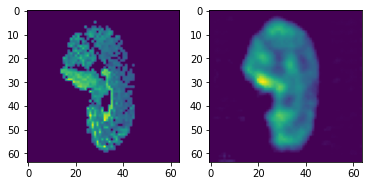

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


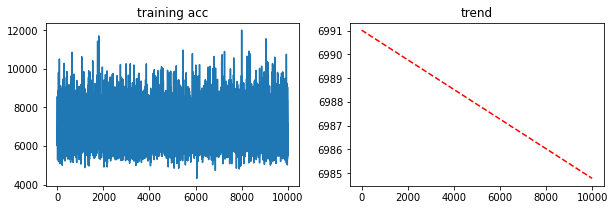

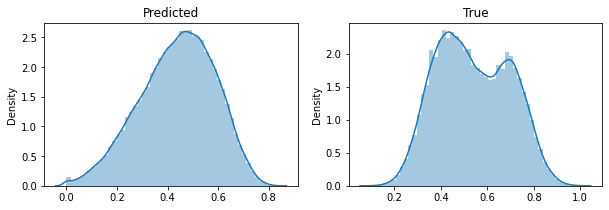

epoch 421/501 | batch 0/212.0 | time 0:37:06.171861 | loss 6992.19336
epoch 421/501 | batch 50/212.0 | time 0:37:07.390253 | loss 6221.31641
epoch 421/501 | batch 100/212.0 | time 0:37:08.505586 | loss 6416.08594
epoch 421/501 | batch 150/212.0 | time 0:37:09.620212 | loss 7958.6499
epoch 421/501 | batch 200/212.0 | time 0:37:10.736292 | loss 6730.86621
epoch 422/501 | batch 0/212.0 | time 0:37:11.015062 | loss 6927.85889
epoch 422/501 | batch 50/212.0 | time 0:37:12.131656 | loss 8267.11914
epoch 422/501 | batch 100/212.0 | time 0:37:13.246626 | loss 8428.93164
epoch 422/501 | batch 150/212.0 | time 0:37:14.366408 | loss 5486.60938
epoch 422/501 | batch 200/212.0 | time 0:37:15.481902 | loss 6441.0166
epoch 423/501 | batch 0/212.0 | time 0:37:15.761586 | loss 6803.0376
epoch 423/501 | batch 50/212.0 | time 0:37:16.877108 | loss 6630.88135
epoch 423/501 | batch 100/212.0 | time 0:37:17.992760 | loss 7348.13477
epoch 423/501 | batch 150/212.0 | time 0:37:19.111735 | loss 7015.13818
epoc

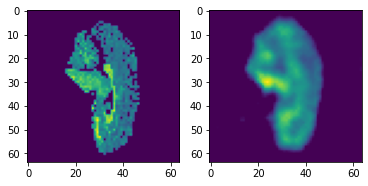

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


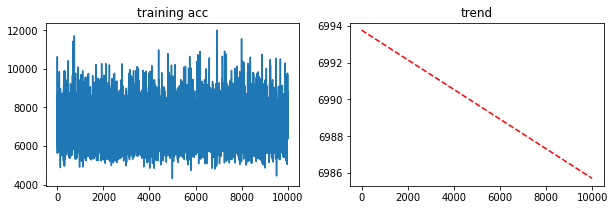

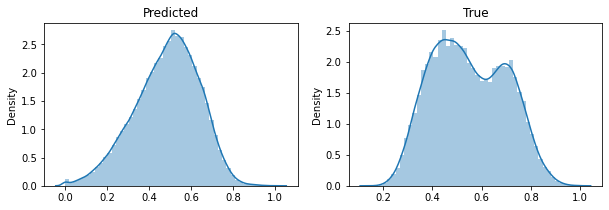

epoch 426/501 | batch 0/212.0 | time 0:37:32.752343 | loss 7088.4917
epoch 426/501 | batch 50/212.0 | time 0:37:33.978654 | loss 6881.7583
epoch 426/501 | batch 100/212.0 | time 0:37:35.096347 | loss 6226.5166
epoch 426/501 | batch 150/212.0 | time 0:37:36.212248 | loss 5320.74414
epoch 426/501 | batch 200/212.0 | time 0:37:37.327996 | loss 6486.62402
epoch 427/501 | batch 0/212.0 | time 0:37:37.609570 | loss 8507.85156
epoch 427/501 | batch 50/212.0 | time 0:37:38.737595 | loss 5846.30469
epoch 427/501 | batch 100/212.0 | time 0:37:39.851292 | loss 6597.91895
epoch 427/501 | batch 150/212.0 | time 0:37:40.966581 | loss 7178.96973
epoch 427/501 | batch 200/212.0 | time 0:37:42.081415 | loss 5213.41992
epoch 428/501 | batch 0/212.0 | time 0:37:42.360667 | loss 7043.19043
epoch 428/501 | batch 50/212.0 | time 0:37:43.475634 | loss 6367.14941
epoch 428/501 | batch 100/212.0 | time 0:37:44.590409 | loss 6482.33594
epoch 428/501 | batch 150/212.0 | time 0:37:45.705634 | loss 5315.06836
epoc

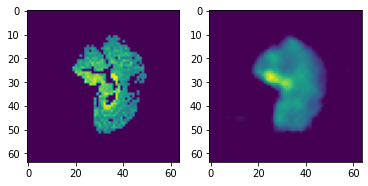

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


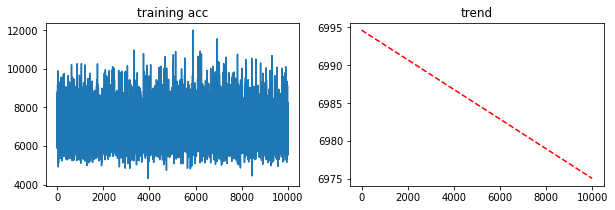

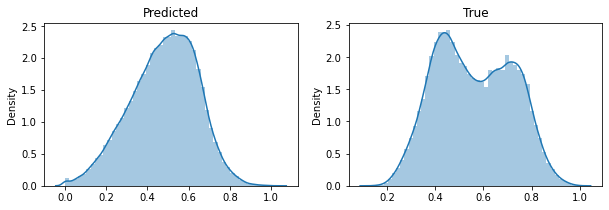

epoch 431/501 | batch 0/212.0 | time 0:37:59.153736 | loss 6307.146
epoch 431/501 | batch 50/212.0 | time 0:38:00.393224 | loss 5797.17969
epoch 431/501 | batch 100/212.0 | time 0:38:01.507362 | loss 6287.10645
epoch 431/501 | batch 150/212.0 | time 0:38:02.623522 | loss 6514.62988
epoch 431/501 | batch 200/212.0 | time 0:38:03.738360 | loss 7137.81934
epoch 432/501 | batch 0/212.0 | time 0:38:04.018091 | loss 6630.67139
epoch 432/501 | batch 50/212.0 | time 0:38:05.133892 | loss 7049.91309
epoch 432/501 | batch 100/212.0 | time 0:38:06.249315 | loss 6584.9668
epoch 432/501 | batch 150/212.0 | time 0:38:07.365566 | loss 6761.71289
epoch 432/501 | batch 200/212.0 | time 0:38:08.480443 | loss 6819.22852
epoch 433/501 | batch 0/212.0 | time 0:38:08.760014 | loss 8199.57031
epoch 433/501 | batch 50/212.0 | time 0:38:09.874315 | loss 7668.89648
epoch 433/501 | batch 100/212.0 | time 0:38:10.990153 | loss 5810.12793
epoch 433/501 | batch 150/212.0 | time 0:38:12.107332 | loss 5216.55664
epoc

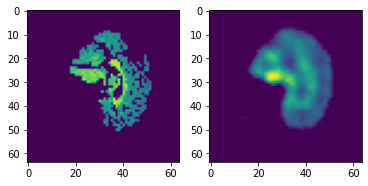

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


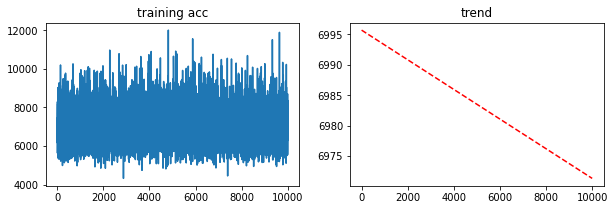

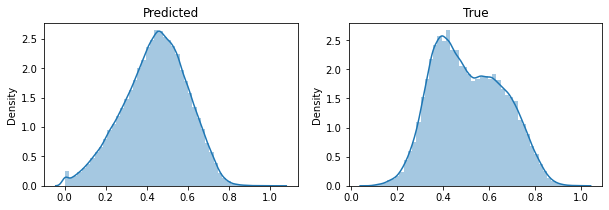

epoch 436/501 | batch 0/212.0 | time 0:38:25.547639 | loss 5808.77734
epoch 436/501 | batch 50/212.0 | time 0:38:26.767943 | loss 6457.59863
epoch 436/501 | batch 100/212.0 | time 0:38:27.889900 | loss 6606.79785
epoch 436/501 | batch 150/212.0 | time 0:38:29.003829 | loss 7586.82861
epoch 436/501 | batch 200/212.0 | time 0:38:30.117799 | loss 6079.70459
epoch 437/501 | batch 0/212.0 | time 0:38:30.396095 | loss 6965.03418
epoch 437/501 | batch 50/212.0 | time 0:38:31.512261 | loss 6749.00635
epoch 437/501 | batch 100/212.0 | time 0:38:32.626813 | loss 7016.09131
epoch 437/501 | batch 150/212.0 | time 0:38:33.743006 | loss 7746.90186
epoch 437/501 | batch 200/212.0 | time 0:38:34.858239 | loss 7008.07227
epoch 438/501 | batch 0/212.0 | time 0:38:35.138136 | loss 7105.43701
epoch 438/501 | batch 50/212.0 | time 0:38:36.253652 | loss 6656.1416
epoch 438/501 | batch 100/212.0 | time 0:38:37.368264 | loss 8816.44727
epoch 438/501 | batch 150/212.0 | time 0:38:38.485212 | loss 8253.33008
ep

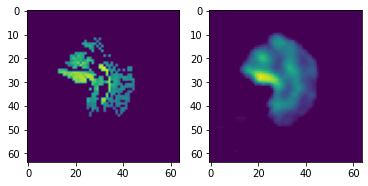

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


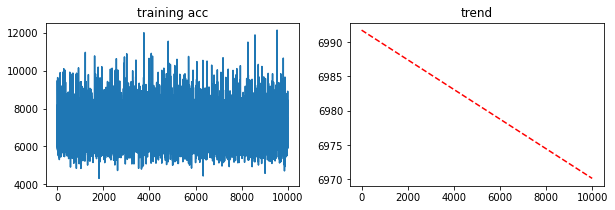

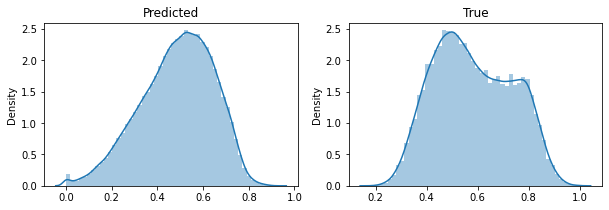

epoch 441/501 | batch 0/212.0 | time 0:38:52.061176 | loss 7299.79639
epoch 441/501 | batch 50/212.0 | time 0:38:53.284307 | loss 5555.02002
epoch 441/501 | batch 100/212.0 | time 0:38:54.398506 | loss 5773.19873
epoch 441/501 | batch 150/212.0 | time 0:38:55.515366 | loss 6829.45605
epoch 441/501 | batch 200/212.0 | time 0:38:56.633654 | loss 6343.92236
epoch 442/501 | batch 0/212.0 | time 0:38:56.912232 | loss 6455.08887
epoch 442/501 | batch 50/212.0 | time 0:38:58.028194 | loss 6522.13672
epoch 442/501 | batch 100/212.0 | time 0:38:59.145586 | loss 5977.39062
epoch 442/501 | batch 150/212.0 | time 0:39:00.259938 | loss 7959.3623
epoch 442/501 | batch 200/212.0 | time 0:39:01.373997 | loss 7633.77637
epoch 443/501 | batch 0/212.0 | time 0:39:01.654413 | loss 6705.6377
epoch 443/501 | batch 50/212.0 | time 0:39:02.773260 | loss 7226.07422
epoch 443/501 | batch 100/212.0 | time 0:39:03.888287 | loss 9288.55664
epoch 443/501 | batch 150/212.0 | time 0:39:05.004901 | loss 7727.76953
epo

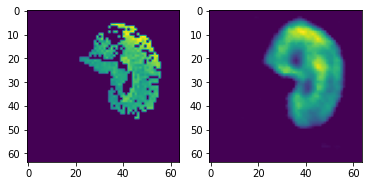

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


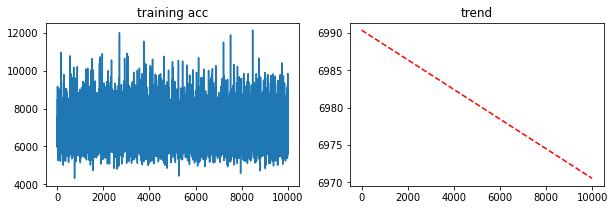

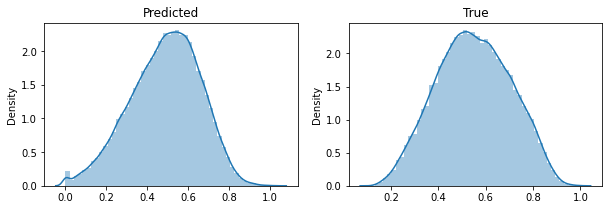

epoch 446/501 | batch 0/212.0 | time 0:39:18.523904 | loss 7326.39941
epoch 446/501 | batch 50/212.0 | time 0:39:19.740832 | loss 6669.73926
epoch 446/501 | batch 100/212.0 | time 0:39:20.856493 | loss 8235.45508
epoch 446/501 | batch 150/212.0 | time 0:39:21.972127 | loss 5876.56104
epoch 446/501 | batch 200/212.0 | time 0:39:23.087156 | loss 7477.5415
epoch 447/501 | batch 0/212.0 | time 0:39:23.366611 | loss 7951.66553
epoch 447/501 | batch 50/212.0 | time 0:39:24.481493 | loss 6383.00049
epoch 447/501 | batch 100/212.0 | time 0:39:25.607019 | loss 6086.06738
epoch 447/501 | batch 150/212.0 | time 0:39:26.731675 | loss 7167.93799
epoch 447/501 | batch 200/212.0 | time 0:39:27.856003 | loss 6500.27539
epoch 448/501 | batch 0/212.0 | time 0:39:28.135598 | loss 7104.3125
epoch 448/501 | batch 50/212.0 | time 0:39:29.250162 | loss 6538.40527
epoch 448/501 | batch 100/212.0 | time 0:39:30.365515 | loss 6165.56445
epoch 448/501 | batch 150/212.0 | time 0:39:31.480372 | loss 6693.75098
epo

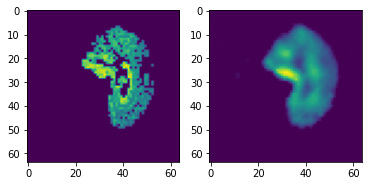

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


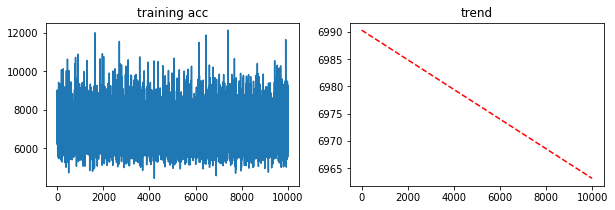

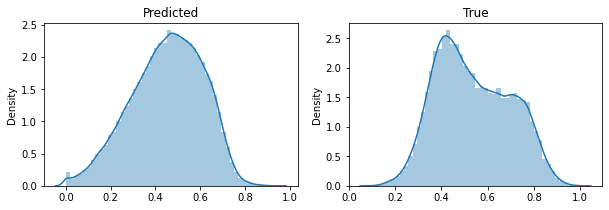

epoch 451/501 | batch 0/212.0 | time 0:39:44.849180 | loss 5940.10498
epoch 451/501 | batch 50/212.0 | time 0:39:46.068271 | loss 6389.80469
epoch 451/501 | batch 100/212.0 | time 0:39:47.185406 | loss 7271.08545
epoch 451/501 | batch 150/212.0 | time 0:39:48.304819 | loss 7428.53271
epoch 451/501 | batch 200/212.0 | time 0:39:49.419770 | loss 5969.9624
epoch 452/501 | batch 0/212.0 | time 0:39:49.701060 | loss 7790.09473
epoch 452/501 | batch 50/212.0 | time 0:39:50.821128 | loss 6526.14648
epoch 452/501 | batch 100/212.0 | time 0:39:51.938661 | loss 5406.37793
epoch 452/501 | batch 150/212.0 | time 0:39:53.052323 | loss 7415.90576
epoch 452/501 | batch 200/212.0 | time 0:39:54.167031 | loss 7600.26953
epoch 453/501 | batch 0/212.0 | time 0:39:54.447543 | loss 6425.58252
epoch 453/501 | batch 50/212.0 | time 0:39:55.568389 | loss 5450.4165
epoch 453/501 | batch 100/212.0 | time 0:39:56.683683 | loss 8397.67383
epoch 453/501 | batch 150/212.0 | time 0:39:57.797960 | loss 5817.3877
epoc

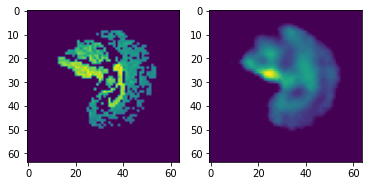

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


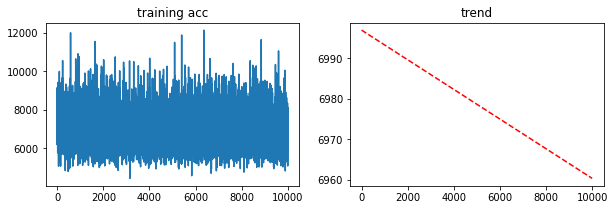

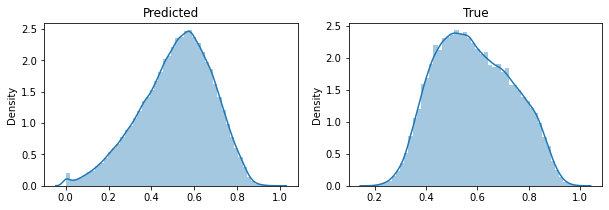

epoch 456/501 | batch 0/212.0 | time 0:40:11.493151 | loss 6381.46582
epoch 456/501 | batch 50/212.0 | time 0:40:12.729714 | loss 6135.76074
epoch 456/501 | batch 100/212.0 | time 0:40:13.844021 | loss 5560.58594
epoch 456/501 | batch 150/212.0 | time 0:40:14.957878 | loss 8181.86865
epoch 456/501 | batch 200/212.0 | time 0:40:16.074962 | loss 6813.74756
epoch 457/501 | batch 0/212.0 | time 0:40:16.353495 | loss 6181.96484
epoch 457/501 | batch 50/212.0 | time 0:40:17.468722 | loss 6775.57422
epoch 457/501 | batch 100/212.0 | time 0:40:18.584350 | loss 6723.84131
epoch 457/501 | batch 150/212.0 | time 0:40:19.699036 | loss 7663.65869
epoch 457/501 | batch 200/212.0 | time 0:40:20.816115 | loss 6816.02148
epoch 458/501 | batch 0/212.0 | time 0:40:21.096665 | loss 7422.95996
epoch 458/501 | batch 50/212.0 | time 0:40:22.217599 | loss 7367.78906
epoch 458/501 | batch 100/212.0 | time 0:40:23.336336 | loss 9537.51758
epoch 458/501 | batch 150/212.0 | time 0:40:24.450729 | loss 9244.03027
e

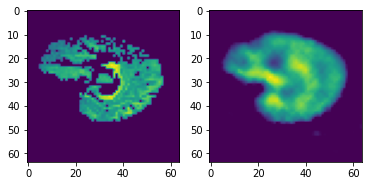

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


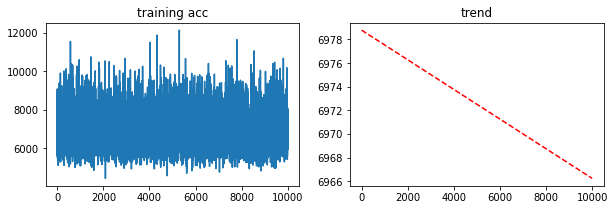

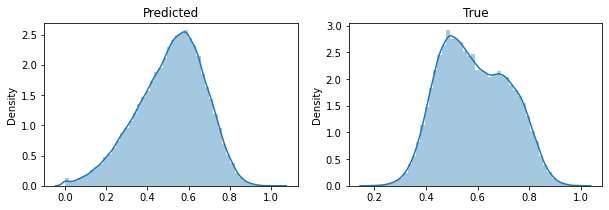

epoch 461/501 | batch 0/212.0 | time 0:40:38.096606 | loss 7320.85156
epoch 461/501 | batch 50/212.0 | time 0:40:39.321048 | loss 9449.92773
epoch 461/501 | batch 100/212.0 | time 0:40:40.437697 | loss 6543.93115
epoch 461/501 | batch 150/212.0 | time 0:40:41.553341 | loss 8312.46484
epoch 461/501 | batch 200/212.0 | time 0:40:42.668252 | loss 7249.77832
epoch 462/501 | batch 0/212.0 | time 0:40:42.947379 | loss 5209.99023
epoch 462/501 | batch 50/212.0 | time 0:40:44.065765 | loss 5421.375
epoch 462/501 | batch 100/212.0 | time 0:40:45.180958 | loss 7425.92627
epoch 462/501 | batch 150/212.0 | time 0:40:46.295731 | loss 6441.5332
epoch 462/501 | batch 200/212.0 | time 0:40:47.413445 | loss 6503.604
epoch 463/501 | batch 0/212.0 | time 0:40:47.692761 | loss 7172.97852
epoch 463/501 | batch 50/212.0 | time 0:40:48.807679 | loss 6810.47705
epoch 463/501 | batch 100/212.0 | time 0:40:49.924023 | loss 8055.74414
epoch 463/501 | batch 150/212.0 | time 0:40:51.042558 | loss 6213.89844
epoch 

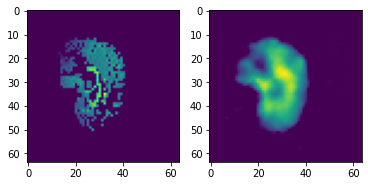

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


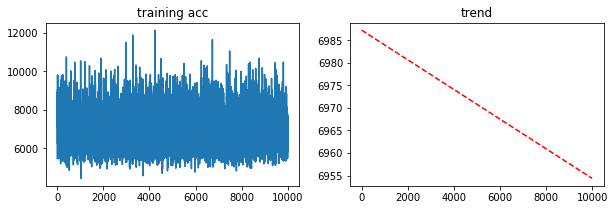

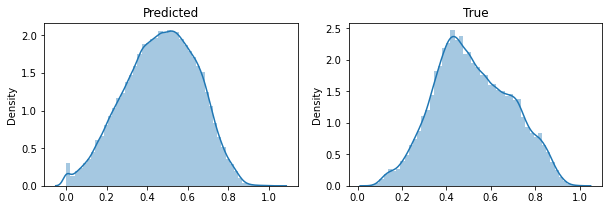

epoch 466/501 | batch 0/212.0 | time 0:41:04.321248 | loss 11800.14648
epoch 466/501 | batch 50/212.0 | time 0:41:05.550347 | loss 5843.46484
epoch 466/501 | batch 100/212.0 | time 0:41:06.679177 | loss 7946.00439
epoch 466/501 | batch 150/212.0 | time 0:41:07.797117 | loss 7622.51953
epoch 466/501 | batch 200/212.0 | time 0:41:08.912086 | loss 5880.59912
epoch 467/501 | batch 0/212.0 | time 0:41:09.192851 | loss 7834.54785
epoch 467/501 | batch 50/212.0 | time 0:41:10.307343 | loss 5114.92578
epoch 467/501 | batch 100/212.0 | time 0:41:11.423957 | loss 7643.3623
epoch 467/501 | batch 150/212.0 | time 0:41:12.538829 | loss 6598.95312
epoch 467/501 | batch 200/212.0 | time 0:41:13.654934 | loss 6970.61035
epoch 468/501 | batch 0/212.0 | time 0:41:13.933849 | loss 7714.37354
epoch 468/501 | batch 50/212.0 | time 0:41:15.050533 | loss 6908.55957
epoch 468/501 | batch 100/212.0 | time 0:41:16.166804 | loss 6131.78125
epoch 468/501 | batch 150/212.0 | time 0:41:17.282496 | loss 7638.11426
e

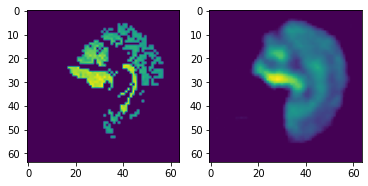

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


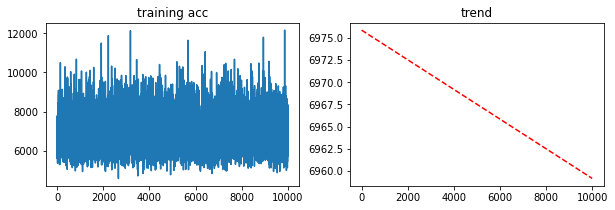

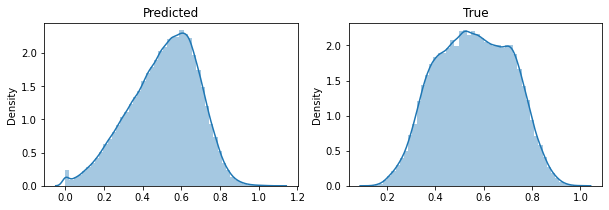

epoch 471/501 | batch 0/212.0 | time 0:41:30.963938 | loss 6249.35742
epoch 471/501 | batch 50/212.0 | time 0:41:32.203680 | loss 6106.61475
epoch 471/501 | batch 100/212.0 | time 0:41:33.319364 | loss 6943.77344
epoch 471/501 | batch 150/212.0 | time 0:41:34.436248 | loss 6466.53516
epoch 471/501 | batch 200/212.0 | time 0:41:35.552234 | loss 6444.62012
epoch 472/501 | batch 0/212.0 | time 0:41:35.833226 | loss 6207.42578
epoch 472/501 | batch 50/212.0 | time 0:41:36.954606 | loss 6232.08008
epoch 472/501 | batch 100/212.0 | time 0:41:38.077173 | loss 7430.37695
epoch 472/501 | batch 150/212.0 | time 0:41:39.192654 | loss 6726.88574
epoch 472/501 | batch 200/212.0 | time 0:41:40.314988 | loss 6323.72949
epoch 473/501 | batch 0/212.0 | time 0:41:40.595760 | loss 7574.50928
epoch 473/501 | batch 50/212.0 | time 0:41:41.711821 | loss 7033.40625
epoch 473/501 | batch 100/212.0 | time 0:41:42.829266 | loss 6453.2002
epoch 473/501 | batch 150/212.0 | time 0:41:43.946056 | loss 7092.95898
ep

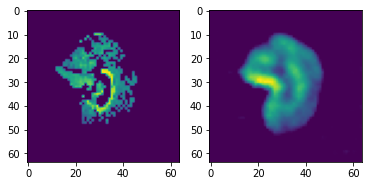

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


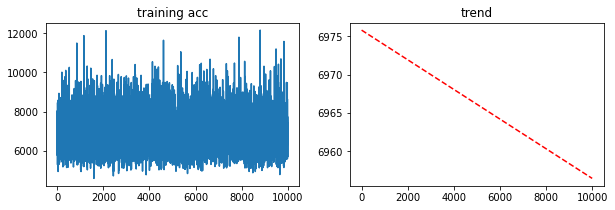

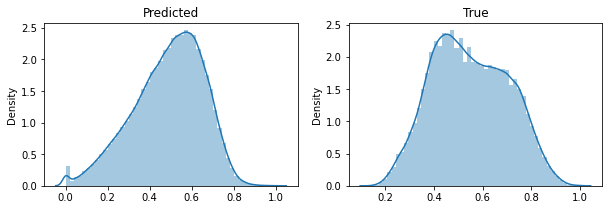

epoch 476/501 | batch 0/212.0 | time 0:41:57.442992 | loss 6679.21387
epoch 476/501 | batch 50/212.0 | time 0:41:58.674257 | loss 6543.3335
epoch 476/501 | batch 100/212.0 | time 0:41:59.795247 | loss 6440.40137
epoch 476/501 | batch 150/212.0 | time 0:42:00.909639 | loss 7864.22461
epoch 476/501 | batch 200/212.0 | time 0:42:02.030052 | loss 8971.35059
epoch 477/501 | batch 0/212.0 | time 0:42:02.311984 | loss 7002.31494
epoch 477/501 | batch 50/212.0 | time 0:42:03.428233 | loss 6713.25977
epoch 477/501 | batch 100/212.0 | time 0:42:04.541043 | loss 6597.47363
epoch 477/501 | batch 150/212.0 | time 0:42:05.656761 | loss 6558.17773
epoch 477/501 | batch 200/212.0 | time 0:42:06.773180 | loss 7134.53516
epoch 478/501 | batch 0/212.0 | time 0:42:07.052138 | loss 7151.17139
epoch 478/501 | batch 50/212.0 | time 0:42:08.179002 | loss 6984.93994
epoch 478/501 | batch 100/212.0 | time 0:42:09.296217 | loss 6234.92871
epoch 478/501 | batch 150/212.0 | time 0:42:10.410509 | loss 10715.2959
ep

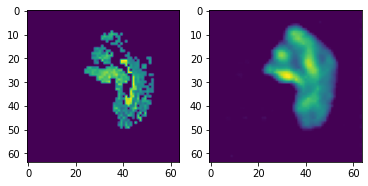

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


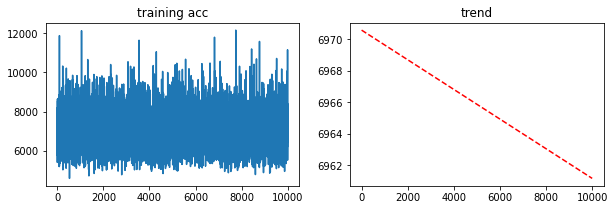

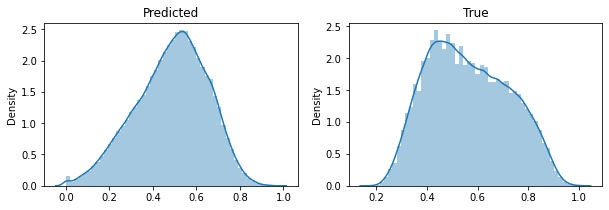

epoch 481/501 | batch 0/212.0 | time 0:42:23.878881 | loss 6311.37012
epoch 481/501 | batch 50/212.0 | time 0:42:25.087777 | loss 6504.36133
epoch 481/501 | batch 100/212.0 | time 0:42:26.201170 | loss 5877.19434
epoch 481/501 | batch 150/212.0 | time 0:42:27.323663 | loss 5800.36914
epoch 481/501 | batch 200/212.0 | time 0:42:28.441107 | loss 7683.88281
epoch 482/501 | batch 0/212.0 | time 0:42:28.720585 | loss 7319.01074
epoch 482/501 | batch 50/212.0 | time 0:42:29.836554 | loss 6369.94336
epoch 482/501 | batch 100/212.0 | time 0:42:30.951613 | loss 6788.0459
epoch 482/501 | batch 150/212.0 | time 0:42:32.070753 | loss 10588.15039
epoch 482/501 | batch 200/212.0 | time 0:42:33.186382 | loss 6620.58643
epoch 483/501 | batch 0/212.0 | time 0:42:33.466926 | loss 6693.44092
epoch 483/501 | batch 50/212.0 | time 0:42:34.584081 | loss 7273.3877
epoch 483/501 | batch 100/212.0 | time 0:42:35.699126 | loss 6416.69531
epoch 483/501 | batch 150/212.0 | time 0:42:36.815331 | loss 6710.60742
ep

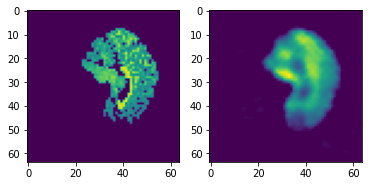

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


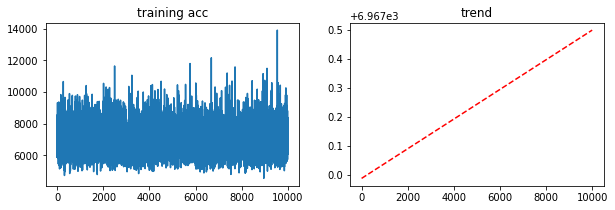

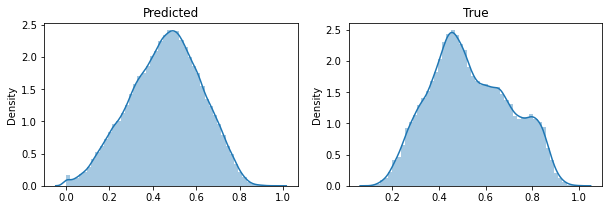

epoch 486/501 | batch 0/212.0 | time 0:42:50.028997 | loss 6974.4751
epoch 486/501 | batch 50/212.0 | time 0:42:51.249086 | loss 7027.23145
epoch 486/501 | batch 100/212.0 | time 0:42:52.364165 | loss 7159.56299
epoch 486/501 | batch 150/212.0 | time 0:42:53.481512 | loss 5816.34473
epoch 486/501 | batch 200/212.0 | time 0:42:54.607135 | loss 6544.9082
epoch 487/501 | batch 0/212.0 | time 0:42:54.887655 | loss 6234.16113
epoch 487/501 | batch 50/212.0 | time 0:42:56.003569 | loss 6961.05566
epoch 487/501 | batch 100/212.0 | time 0:42:57.123770 | loss 6508.29346
epoch 487/501 | batch 150/212.0 | time 0:42:58.245585 | loss 6183.67773
epoch 487/501 | batch 200/212.0 | time 0:42:59.362670 | loss 6914.84766
epoch 488/501 | batch 0/212.0 | time 0:42:59.642210 | loss 7429.30176
epoch 488/501 | batch 50/212.0 | time 0:43:00.758502 | loss 6698.12549
epoch 488/501 | batch 100/212.0 | time 0:43:01.873778 | loss 6740.86572
epoch 488/501 | batch 150/212.0 | time 0:43:02.988775 | loss 9487.68164
epo

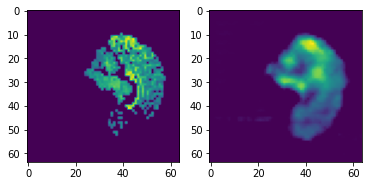

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


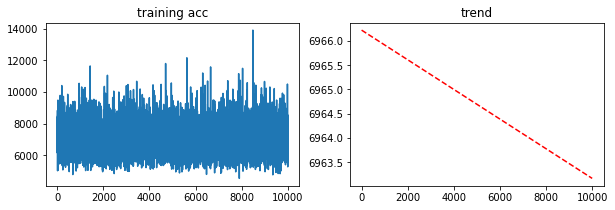

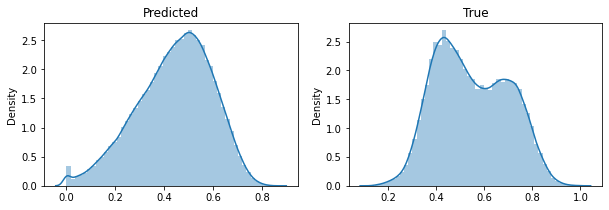

epoch 491/501 | batch 0/212.0 | time 0:43:16.402199 | loss 5685.21191
epoch 491/501 | batch 50/212.0 | time 0:43:17.645064 | loss 7828.00195
epoch 491/501 | batch 100/212.0 | time 0:43:18.761902 | loss 8230.20215
epoch 491/501 | batch 150/212.0 | time 0:43:19.878709 | loss 6730.40918
epoch 491/501 | batch 200/212.0 | time 0:43:20.993803 | loss 7487.64355
epoch 492/501 | batch 0/212.0 | time 0:43:21.272938 | loss 7362.75
epoch 492/501 | batch 50/212.0 | time 0:43:22.389670 | loss 5992.2876
epoch 492/501 | batch 100/212.0 | time 0:43:23.506266 | loss 5972.35059
epoch 492/501 | batch 150/212.0 | time 0:43:24.625004 | loss 7550.45312
epoch 492/501 | batch 200/212.0 | time 0:43:25.741543 | loss 5860.72559
epoch 493/501 | batch 0/212.0 | time 0:43:26.019791 | loss 7587.75049
epoch 493/501 | batch 50/212.0 | time 0:43:27.135324 | loss 5793.92627
epoch 493/501 | batch 100/212.0 | time 0:43:28.252338 | loss 7590.80664
epoch 493/501 | batch 150/212.0 | time 0:43:29.366964 | loss 9627.45508
epoch

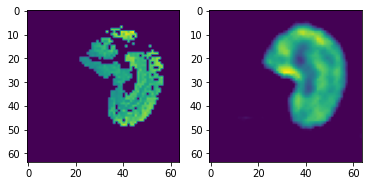

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


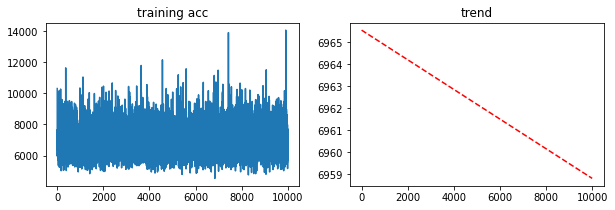

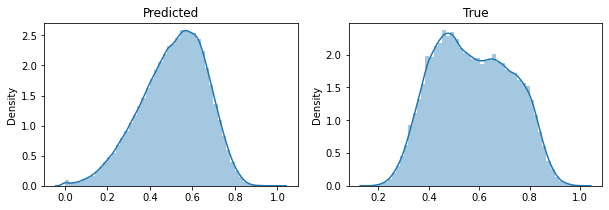

epoch 496/501 | batch 0/212.0 | time 0:43:42.965597 | loss 5718.62354
epoch 496/501 | batch 50/212.0 | time 0:43:44.199864 | loss 8483.11816
epoch 496/501 | batch 100/212.0 | time 0:43:45.314935 | loss 5144.44531
epoch 496/501 | batch 150/212.0 | time 0:43:46.430720 | loss 6062.57031
epoch 496/501 | batch 200/212.0 | time 0:43:47.549520 | loss 7192.63281
epoch 497/501 | batch 0/212.0 | time 0:43:47.829411 | loss 5727.15234
epoch 497/501 | batch 50/212.0 | time 0:43:48.944945 | loss 6382.96387
epoch 497/501 | batch 100/212.0 | time 0:43:50.062916 | loss 7925.10205
epoch 497/501 | batch 150/212.0 | time 0:43:51.181854 | loss 6539.64697
epoch 497/501 | batch 200/212.0 | time 0:43:52.302164 | loss 6483.51465
epoch 498/501 | batch 0/212.0 | time 0:43:52.581344 | loss 6531.45898
epoch 498/501 | batch 50/212.0 | time 0:43:53.701059 | loss 5633.81934
epoch 498/501 | batch 100/212.0 | time 0:43:54.816208 | loss 5863.00928
epoch 498/501 | batch 150/212.0 | time 0:43:55.935091 | loss 7673.31006
e

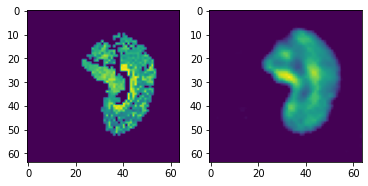

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


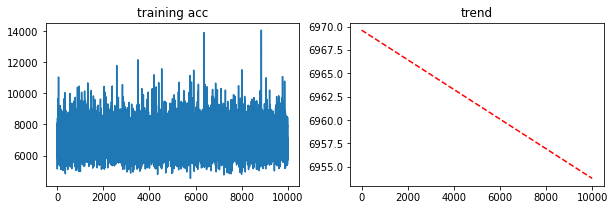

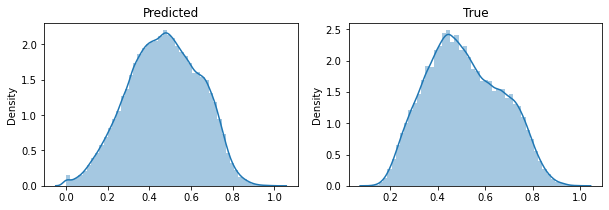

In [11]:
t0 = datetime.now();
for epoch in range(int(num_epochs)):
    permutation = np.random.permutation(ndata)
    D = D[permutation,:,:,:,:]
    for batch_idx in range(int(n_batches)):
        optimizer.zero_grad()
        data_batch = D[batches[batch_idx,:],:,:,:,:]
        outputs = model.forward(data_batch)
        #train_loss = criterion(outputs,data_batch)
        train_loss = myLoss(outputs,data_batch)
        train_loss.backward()
        optimizer.step()
        track.append(train_loss.item())
        if batch_idx%50==0:
          print(f"epoch {epoch}/{num_epochs} | batch {batch_idx}/{n_batches} | time {str(datetime.now()-t0)} | loss {round(train_loss.item(),5)}")


    track = track[-min(len(track),10000)::]

    if epoch%100==0:
      ofn = os.path.join(ofdir,f'{session_name}' + f'e{epoch}_'+str(now()))
      print('saved')
      print(ofn)
      torch.save(model.state_dict(),ofn)
     
    if epoch%5==0:
      print(outputs.view(-1))
      plt.figure()
      plt.subplot(1,2,1)
      plt.imshow(data_batch.cpu().detach().numpy()[0,0,32,:,:])
      plt.subplot(1,2,2)
      plt.imshow(outputs.cpu().detach().numpy()[0,0,32,:,:])
      plt.show()

      plt.figure(figsize=(10,3))
      plt.subplot(1,2,1)
      t = track
      plt.plot(t)
      plt.title('training acc')

      xs = np.arange(len(t))+1
      z = np.polyfit(xs, t, 1)
      p = np.poly1d(z)
      plt.subplot(1,2,2)
      plt.plot(xs,p(xs),"r--")
      plt.title('trend')


      b = outputs.cpu().detach()
      a = data_batch.cpu().detach()
      plt.figure(figsize=(10,3))
      plt.subplot(1,2,1)
      sns.distplot(np.array(b[a>0.001]).flatten())
      plt.title('Predicted')
      plt.subplot(1,2,2)
      sns.distplot(np.array(a[a>0.001]).flatten())
      plt.title('True')
      plt.show()

In [ ]:
 %print('all done')